In [6]:
!pip install arch

In [7]:
import yfinance as yf
from datetime import datetime, timedelta, timezone
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from statsmodels.tools.sm_exceptions import ValueWarning, HessianInversionWarning, ConvergenceWarning
import warnings
from time import time
from sklearn.metrics import mean_squared_error
from arch import arch_model
import csv


warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=HessianInversionWarning)
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# **Get Datas**

In [37]:
cryptos = ['BTC-USD', 'ETH-USD']

start_date = datetime(2021,7,1, tzinfo=timezone.utc)
end_date = datetime(2023,12,1, tzinfo=timezone.utc)

train_start_date = datetime(2021,7,1, tzinfo=timezone.utc)
train_end_date = datetime(2023,7,1, tzinfo=timezone.utc)

test_start_date = datetime(2023,7,1, tzinfo=timezone.utc)
test_end_date = datetime(2023,12,1, tzinfo=timezone.utc)

In [38]:
prices = {}
returns = {}

for crypto in cryptos:
    ticker = yf.Ticker(crypto)
    prices_1d = ticker.history(start=start_date, end=end_date, interval='1d').Close
    returns_1d = prices_1d.pct_change().dropna()

    if crypto not in prices:
        prices[crypto] = []
        returns[crypto] = []

    prices[crypto].append(prices_1d)
    returns[crypto].append(returns_1d)


In [39]:
train_data_price = []
test_data_price = []

train_data_return = []
test_data_return = []

data_price = []

for i, crypto in enumerate(cryptos):
  data_price.append(returns[crypto][0].loc[start_date:end_date])

  train_data_price.append(returns[crypto][0].loc[train_start_date:train_end_date]) # train_data[0] => BTC, train_data[1] => ETH
  test_data_price.append(returns[crypto][0].loc[test_start_date + timedelta(days=1):test_end_date]) # test_data[0] => BTC, test_data[1] => ETH

  train_data_return.append(returns[crypto][0].loc[train_start_date:train_end_date]) # train_data[0] => BTC, train_data[1] => ETH
  test_data_return.append(returns[crypto][0].loc[test_start_date + timedelta(days=1):test_end_date]) # test_data[0] => BTC, test_data[1] => ETH

# **Train Model with Brute Force**

In [11]:
windows = {}
test_size = len(train_data_price[0])
residuals = []

def best_arima_model(i, j):
  train_data_R = data_price[i][j:j+test_size]
  windows[f'{cryptos[i]}, {j}'] = []
  best_p = 0
  best_q = 0
  best_aic = 99999999
  best_model = None
  for p in range(1,6):
    for q in range(1,6):
      try:
          model = ARIMA(train_data_R, order=(p,0,q))
          model_fit = model.fit()
          if best_aic > model_fit.aic:
            best_p = p
            best_q = q
            best_model = model_fit
            best_aic = model_fit.aic

      except:
          pass

  residual = best_model.resid
  residuals.append(residual)
  return best_p, best_q, residual

# **Arch Model**

In [12]:
from arch import arch_model

signals_all = []
means = []

for i in range(len(train_data_price)):
  means.append([])
  for j in range(len(test_data_price[0])):
    p_val, q_val, residual = best_arima_model(i, j)
    model = arch_model(residual, vol='Garch', p=p_val, q=q_val)
    arch_model_fit = model.fit()
    arch_model_forecast = arch_model_fit.forecast(horizon=1)
    arch_mean = arch_model_forecast.mean
    means[i].append(arch_mean.iloc[-1])


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009663. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 29580319.074010603
Iteration:      2,   Func. Count:     17,   Neg. LLF: 614.577245600678
Iteration:      3,   Func. Count:     25,   Neg. LLF: -1145.7167282179737
Iteration:      4,   Func. Count:     32,   Neg. LLF: -1197.3031990744548
Iteration:      5,   Func. Count:     38,   Neg. LLF: -1200.8402431340346
Iteration:      6,   Func. Count:     45,   Neg. LLF: -1201.514931371932
Iteration:      7,   Func. Count:     51,   Neg. LLF: -1201.6051007324597
Iteration:      8,   Func. Count:     56,   Neg. LLF: -1201.6051198245914
Iteration:      9,   Func. Count:     60,   Neg. LLF: -1201.605119824701
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1201.6051198245914
            Iterations: 9
            Function evaluations: 60
            Gradient evaluations: 9


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009661. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 28459189.4910026
Iteration:      2,   Func. Count:     17,   Neg. LLF: -572.6579665513901
Iteration:      3,   Func. Count:     25,   Neg. LLF: -1145.4291002679834
Iteration:      4,   Func. Count:     32,   Neg. LLF: -1197.9182168846917
Iteration:      5,   Func. Count:     38,   Neg. LLF: -1200.0565587200042
Iteration:      6,   Func. Count:     45,   Neg. LLF: -1202.4082115872943
Iteration:      7,   Func. Count:     50,   Neg. LLF: -1202.4084486607453
Iteration:      8,   Func. Count:     55,   Neg. LLF: -1202.4084636126554
Iteration:      9,   Func. Count:     59,   Neg. LLF: -1202.4084636127636
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1202.4084636126554
            Iterations: 9
            Function evaluations: 59
            Gradient evaluations: 9


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009624. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 253435798.3247407
Iteration:      2,   Func. Count:     17,   Neg. LLF: 490.3242802209989
Iteration:      3,   Func. Count:     25,   Neg. LLF: -1147.9668891999872
Iteration:      4,   Func. Count:     32,   Neg. LLF: -1198.4074157269897
Iteration:      5,   Func. Count:     38,   Neg. LLF: -1180.2175900593006
Iteration:      6,   Func. Count:     45,   Neg. LLF: -1203.1173954219369
Iteration:      7,   Func. Count:     51,   Neg. LLF: -1203.1214888081508
Iteration:      8,   Func. Count:     56,   Neg. LLF: -1203.1214956261106
Iteration:      9,   Func. Count:     60,   Neg. LLF: -1203.121495626117
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1203.1214956261106
            Iterations: 9
            Function evaluations: 60
            Gradient evaluations: 9


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000951. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 370216090.6304934
Iteration:      2,   Func. Count:     17,   Neg. LLF: 537.8398602674876
Iteration:      3,   Func. Count:     25,   Neg. LLF: -1149.848253074198
Iteration:      4,   Func. Count:     32,   Neg. LLF: -1201.9511095798512
Iteration:      5,   Func. Count:     38,   Neg. LLF: -1182.9247324174207
Iteration:      6,   Func. Count:     45,   Neg. LLF: -1206.9196344673178
Iteration:      7,   Func. Count:     50,   Neg. LLF: -1206.9212512512756
Iteration:      8,   Func. Count:     55,   Neg. LLF: -1206.9212534507367
Iteration:      9,   Func. Count:     59,   Neg. LLF: -1206.9212534508647
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1206.9212534507367
            Iterations: 9
            Function evaluations: 59
            Gradient evaluations: 9


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009511. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 26577415.540666346
Iteration:      2,   Func. Count:     17,   Neg. LLF: 667.777646198109
Iteration:      3,   Func. Count:     25,   Neg. LLF: -1150.0649130383765
Iteration:      4,   Func. Count:     32,   Neg. LLF: -1202.0695102818984
Iteration:      5,   Func. Count:     38,   Neg. LLF: -1193.7403613877734
Iteration:      6,   Func. Count:     46,   Neg. LLF: -1206.9543286973903
Iteration:      7,   Func. Count:     51,   Neg. LLF: -1206.9543694893393
Iteration:      8,   Func. Count:     56,   Neg. LLF: -1206.9543709990153
Iteration:      9,   Func. Count:     60,   Neg. LLF: -1206.9543709990207
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1206.9543709990153
            Iterations: 9
            Function evaluations: 60
            Gradient evaluations: 9


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009507. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 28776131.247369528
Iteration:      2,   Func. Count:     17,   Neg. LLF: 448.5097846834992
Iteration:      3,   Func. Count:     25,   Neg. LLF: -1150.2630310469222
Iteration:      4,   Func. Count:     32,   Neg. LLF: -1202.1899085921584
Iteration:      5,   Func. Count:     38,   Neg. LLF: -1184.9560169912986
Iteration:      6,   Func. Count:     45,   Neg. LLF: -1207.1077306247182
Iteration:      7,   Func. Count:     51,   Neg. LLF: -1207.1119129848435
Iteration:      8,   Func. Count:     56,   Neg. LLF: -1207.1119148757616
Iteration:      9,   Func. Count:     60,   Neg. LLF: -1207.1119148757657
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1207.1119148757616
            Iterations: 9
            Function evaluations: 60
            Gradient evaluations: 9


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009511. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 357928863.4885316
Iteration:      2,   Func. Count:     17,   Neg. LLF: -724.5157940222201
Iteration:      3,   Func. Count:     25,   Neg. LLF: -1144.6207310924315
Iteration:      4,   Func. Count:     32,   Neg. LLF: -1201.873347533826
Iteration:      5,   Func. Count:     38,   Neg. LLF: -1183.1868552746325
Iteration:      6,   Func. Count:     45,   Neg. LLF: -1207.2608911041511
Iteration:      7,   Func. Count:     50,   Neg. LLF: -1207.261049825443
Iteration:      8,   Func. Count:     54,   Neg. LLF: -1207.261049825574
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1207.261049825443
            Iterations: 8
            Function evaluations: 54
            Gradient evaluations: 8


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009511. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 26066932.602510676
Iteration:      2,   Func. Count:     17,   Neg. LLF: -766.3030523097171
Iteration:      3,   Func. Count:     25,   Neg. LLF: -1145.7233483442615
Iteration:      4,   Func. Count:     31,   Neg. LLF: -730.1542197732906
Iteration:      5,   Func. Count:     39,   Neg. LLF: -1202.9725046176254
Iteration:      6,   Func. Count:     45,   Neg. LLF: -1207.5035284842006
Iteration:      7,   Func. Count:     51,   Neg. LLF: -1207.9086486192386
Iteration:      8,   Func. Count:     56,   Neg. LLF: -1207.90871425954
Iteration:      9,   Func. Count:     61,   Neg. LLF: -1207.9087163209174
Iteration:     10,   Func. Count:     65,   Neg. LLF: -1207.9087163209197
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1207.9087163209174
            Iterations: 10
            Function evaluations: 65
            Gradient evaluations: 10


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009457. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 25593365.057446513
Iteration:      2,   Func. Count:     17,   Neg. LLF: -754.3446311362495
Iteration:      3,   Func. Count:     25,   Neg. LLF: -1148.3299149264103
Iteration:      4,   Func. Count:     31,   Neg. LLF: 208.60250608526312
Iteration:      5,   Func. Count:     38,   Neg. LLF: -1204.8401062833063
Iteration:      6,   Func. Count:     44,   Neg. LLF: -1209.315934055307
Iteration:      7,   Func. Count:     50,   Neg. LLF: -1209.6338737105334
Iteration:      8,   Func. Count:     55,   Neg. LLF: -1209.6339391931365
Iteration:      9,   Func. Count:     59,   Neg. LLF: -1209.6339391932318
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1209.6339391931365
            Iterations: 9
            Function evaluations: 59
            Gradient evaluations: 9


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009457. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 24664769.857089747
Iteration:      2,   Func. Count:     17,   Neg. LLF: -725.4925233924603
Iteration:      3,   Func. Count:     25,   Neg. LLF: -1146.735005929279
Iteration:      4,   Func. Count:     31,   Neg. LLF: 1536415.5430887083
Iteration:      5,   Func. Count:     38,   Neg. LLF: -1198.9962407403755
Iteration:      6,   Func. Count:     44,   Neg. LLF: -1202.7949883245644
Iteration:      7,   Func. Count:     51,   Neg. LLF: -1209.8499300206672
Iteration:      8,   Func. Count:     57,   Neg. LLF: -1210.115389765171
Iteration:      9,   Func. Count:     62,   Neg. LLF: -1210.1155181306144
Iteration:     10,   Func. Count:     67,   Neg. LLF: -1210.1155219191537
Iteration:     11,   Func. Count:     71,   Neg. LLF: -1210.1155219191692
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1210.1155219191537
            Iterations: 11
            Function evaluations: 71
            Gradi

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009423. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 38950133.58464246
Iteration:      2,   Func. Count:     17,   Neg. LLF: -798.4858044188572
Iteration:      3,   Func. Count:     25,   Neg. LLF: -1149.4782463154804
Iteration:      4,   Func. Count:     31,   Neg. LLF: -1165.1050465577664
Iteration:      5,   Func. Count:     38,   Neg. LLF: -1206.8650804020513
Iteration:      6,   Func. Count:     44,   Neg. LLF: -1210.6746129827222
Iteration:      7,   Func. Count:     50,   Neg. LLF: -1211.136133912923
Iteration:      8,   Func. Count:     55,   Neg. LLF: -1211.1361502123536
Iteration:      9,   Func. Count:     59,   Neg. LLF: -1211.1361502121272
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1211.1361502123536
            Iterations: 9
            Function evaluations: 59
            Gradient evaluations: 9


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009307. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      9,   Neg. LLF: 221924613.58460292
Iteration:      2,   Func. Count:     23,   Neg. LLF: 1373960.4862145374
Iteration:      3,   Func. Count:     32,   Neg. LLF: -971.1043185254109
Iteration:      4,   Func. Count:     43,   Neg. LLF: -1074.0014960616013
Iteration:      5,   Func. Count:     52,   Neg. LLF: -1211.4383356284252
Iteration:      6,   Func. Count:     61,   Neg. LLF: -1216.0732755301854
Iteration:      7,   Func. Count:     69,   Neg. LLF: -1133.6817865234468
Iteration:      8,   Func. Count:     78,   Neg. LLF: -1203.8189270806934
Iteration:      9,   Func. Count:     88,   Neg. LLF: -1214.127150077705
Iteration:     10,   Func. Count:     97,   Neg. LLF: -1217.2844780961527
Iteration:     11,   Func. Count:    105,   Neg. LLF: -1217.2900616391748
Iteration:     12,   Func. Count:    113,   Neg. LLF: -1217.2361907481998
Iteration:     13,   Func. Count:    122,   Neg. LLF: -1217.2935817558023
Iteration:     14,   Func. Count:    130, 

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009365. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 43034264.21343059
Iteration:      2,   Func. Count:     17,   Neg. LLF: -783.7146717924667
Iteration:      3,   Func. Count:     25,   Neg. LLF: -1152.9749016480187
Iteration:      4,   Func. Count:     31,   Neg. LLF: -999.5915439094019
Iteration:      5,   Func. Count:     38,   Neg. LLF: -1209.4585074520785
Iteration:      6,   Func. Count:     44,   Neg. LLF: -1213.3837590581747
Iteration:      7,   Func. Count:     50,   Neg. LLF: -1213.4957042095457
Iteration:      8,   Func. Count:     55,   Neg. LLF: -1213.4957392259294
Iteration:      9,   Func. Count:     59,   Neg. LLF: -1213.4957392260992
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1213.4957392259294
            Iterations: 9
            Function evaluations: 59
            Gradient evaluations: 9


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009387. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 29975781.020620007
Iteration:      2,   Func. Count:     17,   Neg. LLF: -854.983429086151
Iteration:      3,   Func. Count:     25,   Neg. LLF: -1152.028752486524
Iteration:      4,   Func. Count:     31,   Neg. LLF: -1207.4537511942676
Iteration:      5,   Func. Count:     38,   Neg. LLF: -1207.8857094831549
Iteration:      6,   Func. Count:     44,   Neg. LLF: -1212.8196422249628
Iteration:      7,   Func. Count:     50,   Neg. LLF: -1212.9166319390765
Iteration:      8,   Func. Count:     55,   Neg. LLF: -1212.9169755444323
Iteration:      9,   Func. Count:     59,   Neg. LLF: -1212.9169755445814
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1212.9169755444323
            Iterations: 9
            Function evaluations: 59
            Gradient evaluations: 9


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009344. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 35903001.59955434
Iteration:      2,   Func. Count:     17,   Neg. LLF: -722.1312128042957
Iteration:      3,   Func. Count:     25,   Neg. LLF: -1155.0356023014772
Iteration:      4,   Func. Count:     31,   Neg. LLF: 221829.8577210722
Iteration:      5,   Func. Count:     38,   Neg. LLF: -1198.2008799500468
Iteration:      6,   Func. Count:     44,   Neg. LLF: -1209.6237078042316
Iteration:      7,   Func. Count:     50,   Neg. LLF: -1214.096883968582
Iteration:      8,   Func. Count:     56,   Neg. LLF: -1214.298780144462
Iteration:      9,   Func. Count:     61,   Neg. LLF: -1214.298865892953
Iteration:     10,   Func. Count:     66,   Neg. LLF: -1214.298871416785
Iteration:     11,   Func. Count:     70,   Neg. LLF: -1214.2988714168005
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1214.298871416785
            Iterations: 11
            Function evaluations: 70
            Gradient e

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009334. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 40734373.050208725
Iteration:      2,   Func. Count:     17,   Neg. LLF: -750.5746909155281
Iteration:      3,   Func. Count:     25,   Neg. LLF: -1156.6704475045956
Iteration:      4,   Func. Count:     31,   Neg. LLF: -396.96100437614547
Iteration:      5,   Func. Count:     39,   Neg. LLF: -1210.900551280156
Iteration:      6,   Func. Count:     45,   Neg. LLF: -1214.7272227676658
Iteration:      7,   Func. Count:     51,   Neg. LLF: -1214.7409136470174
Iteration:      8,   Func. Count:     56,   Neg. LLF: -1214.7409323064855
Iteration:      9,   Func. Count:     60,   Neg. LLF: -1214.740932306634
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1214.7409323064855
            Iterations: 9
            Function evaluations: 60
            Gradient evaluations: 9


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009318. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 43561727.51756314
Iteration:      2,   Func. Count:     17,   Neg. LLF: -780.6853516545193
Iteration:      3,   Func. Count:     25,   Neg. LLF: -1156.3559611851158
Iteration:      4,   Func. Count:     31,   Neg. LLF: -1164.950251440598
Iteration:      5,   Func. Count:     38,   Neg. LLF: -1211.7614691519468
Iteration:      6,   Func. Count:     44,   Neg. LLF: -1215.5222137968062
Iteration:      7,   Func. Count:     50,   Neg. LLF: -1215.5414840550266
Iteration:      8,   Func. Count:     55,   Neg. LLF: -1215.5414944671302
Iteration:      9,   Func. Count:     59,   Neg. LLF: -1215.5414944670456
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1215.5414944671302
            Iterations: 9
            Function evaluations: 59
            Gradient evaluations: 9


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009316. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 29318997.523296826
Iteration:      2,   Func. Count:     17,   Neg. LLF: -757.2130211266384
Iteration:      3,   Func. Count:     25,   Neg. LLF: -1156.7851739403702
Iteration:      4,   Func. Count:     31,   Neg. LLF: -1123.0166559466631
Iteration:      5,   Func. Count:     38,   Neg. LLF: -1211.763965891209
Iteration:      6,   Func. Count:     44,   Neg. LLF: -1215.6392195002027
Iteration:      7,   Func. Count:     50,   Neg. LLF: -1215.6451987612943
Iteration:      8,   Func. Count:     55,   Neg. LLF: -1215.645217867912
Iteration:      9,   Func. Count:     59,   Neg. LLF: -1215.6452178679497
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1215.645217867912
            Iterations: 9
            Function evaluations: 59
            Gradient evaluations: 9


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009316. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 28150342.85215299
Iteration:      2,   Func. Count:     17,   Neg. LLF: -785.7844808196464
Iteration:      3,   Func. Count:     25,   Neg. LLF: -1155.064085670459
Iteration:      4,   Func. Count:     31,   Neg. LLF: -1211.7459120606045
Iteration:      5,   Func. Count:     37,   Neg. LLF: -1159.2568768620135
Iteration:      6,   Func. Count:     44,   Neg. LLF: -1215.7909693581578
Iteration:      7,   Func. Count:     49,   Neg. LLF: -1215.7918678409874
Iteration:      8,   Func. Count:     54,   Neg. LLF: -1215.7918974290296
Iteration:      9,   Func. Count:     58,   Neg. LLF: -1215.7918974290767
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1215.7918974290296
            Iterations: 9
            Function evaluations: 58
            Gradient evaluations: 9


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009315. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 32526656.63977429
Iteration:      2,   Func. Count:     17,   Neg. LLF: -798.0859374992347
Iteration:      3,   Func. Count:     25,   Neg. LLF: -1155.8217454249275
Iteration:      4,   Func. Count:     31,   Neg. LLF: -1205.2467214075446
Iteration:      5,   Func. Count:     38,   Neg. LLF: -1211.4085289865054
Iteration:      6,   Func. Count:     44,   Neg. LLF: -1216.1851056861692
Iteration:      7,   Func. Count:     49,   Neg. LLF: -1216.18522740943
Iteration:      8,   Func. Count:     54,   Neg. LLF: -1216.185265003676
Iteration:      9,   Func. Count:     59,   Neg. LLF: -1216.185265345489
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1216.185265345489
            Iterations: 9
            Function evaluations: 59
            Gradient evaluations: 9


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009283. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 29315769.625699237
Iteration:      2,   Func. Count:     17,   Neg. LLF: -794.6292165571014
Iteration:      3,   Func. Count:     25,   Neg. LLF: -1157.242924443368
Iteration:      4,   Func. Count:     31,   Neg. LLF: -1205.1858984352643
Iteration:      5,   Func. Count:     38,   Neg. LLF: -1212.8556683634781
Iteration:      6,   Func. Count:     44,   Neg. LLF: -1217.4697325032596
Iteration:      7,   Func. Count:     49,   Neg. LLF: -1217.4699389325547
Iteration:      8,   Func. Count:     54,   Neg. LLF: -1217.4699649631286
Iteration:      9,   Func. Count:     59,   Neg. LLF: -1217.4699647505518
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1217.469965115712
            Iterations: 9
            Function evaluations: 60
            Gradient evaluations: 9


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009282. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 27484427.32824425
Iteration:      2,   Func. Count:     17,   Neg. LLF: -745.5235376993912
Iteration:      3,   Func. Count:     25,   Neg. LLF: -1160.0174446639408
Iteration:      4,   Func. Count:     31,   Neg. LLF: -1208.6031856826921
Iteration:      5,   Func. Count:     38,   Neg. LLF: -1213.2290339711822
Iteration:      6,   Func. Count:     44,   Neg. LLF: -1217.8649544586656
Iteration:      7,   Func. Count:     49,   Neg. LLF: -1217.867419370831
Iteration:      8,   Func. Count:     54,   Neg. LLF: -1217.867693569738
Iteration:      9,   Func. Count:     59,   Neg. LLF: -1217.86769497678
Iteration:     10,   Func. Count:     63,   Neg. LLF: -1217.8676949768105
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1217.86769497678
            Iterations: 10
            Function evaluations: 63
            Gradient evaluations: 10


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009249. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 28364506.220275976
Iteration:      2,   Func. Count:     17,   Neg. LLF: -777.7361209640526
Iteration:      3,   Func. Count:     25,   Neg. LLF: -1159.0524798427093
Iteration:      4,   Func. Count:     31,   Neg. LLF: -1199.8903719027257
Iteration:      5,   Func. Count:     38,   Neg. LLF: -1214.7604896434327
Iteration:      6,   Func. Count:     44,   Neg. LLF: -1219.4539483032345
Iteration:      7,   Func. Count:     49,   Neg. LLF: -1219.4590681788886
Iteration:      8,   Func. Count:     54,   Neg. LLF: -1219.4594789926234
Iteration:      9,   Func. Count:     59,   Neg. LLF: -1219.4594803302982
Iteration:     10,   Func. Count:     63,   Neg. LLF: -1219.4594803303048
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1219.4594803302982
            Iterations: 10
            Function evaluations: 63
            Gradient evaluations: 10


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009264. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 30298292.806002803
Iteration:      2,   Func. Count:     17,   Neg. LLF: -742.9780630005598
Iteration:      3,   Func. Count:     25,   Neg. LLF: -1163.2521835281834
Iteration:      4,   Func. Count:     31,   Neg. LLF: -1206.3875401702262
Iteration:      5,   Func. Count:     38,   Neg. LLF: -1214.1079812143316
Iteration:      6,   Func. Count:     44,   Neg. LLF: -1218.6703369808415
Iteration:      7,   Func. Count:     49,   Neg. LLF: -1218.680188785142
Iteration:      8,   Func. Count:     54,   Neg. LLF: -1218.6835663574286
Iteration:      9,   Func. Count:     59,   Neg. LLF: -1218.683660500316
Iteration:     10,   Func. Count:     64,   Neg. LLF: -1218.6836639252842
Iteration:     11,   Func. Count:     68,   Neg. LLF: -1218.6836639253484
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1218.6836639252842
            Iterations: 11
            Function evaluations: 68
            Grad

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009264. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 29243138.443582293
Iteration:      2,   Func. Count:     17,   Neg. LLF: -761.143129349046
Iteration:      3,   Func. Count:     25,   Neg. LLF: -1157.849323708955
Iteration:      4,   Func. Count:     31,   Neg. LLF: -1203.4946629002902
Iteration:      5,   Func. Count:     38,   Neg. LLF: -1213.8722769970748
Iteration:      6,   Func. Count:     44,   Neg. LLF: -1218.6752660828852
Iteration:      7,   Func. Count:     49,   Neg. LLF: -1218.6777463271778
Iteration:      8,   Func. Count:     54,   Neg. LLF: -1218.6778369845015
Iteration:      9,   Func. Count:     59,   Neg. LLF: -1218.6778372149497
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1218.6778372149497
            Iterations: 9
            Function evaluations: 59
            Gradient evaluations: 9


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009261. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 26700237.713466655
Iteration:      2,   Func. Count:     17,   Neg. LLF: -750.5912645124273
Iteration:      3,   Func. Count:     25,   Neg. LLF: -1157.5547115434651
Iteration:      4,   Func. Count:     31,   Neg. LLF: -1199.9340052340012
Iteration:      5,   Func. Count:     38,   Neg. LLF: -1214.2402324245404
Iteration:      6,   Func. Count:     44,   Neg. LLF: -1218.871640065611
Iteration:      7,   Func. Count:     49,   Neg. LLF: -1218.8764365356874
Iteration:      8,   Func. Count:     54,   Neg. LLF: -1218.8765742548358
Iteration:      9,   Func. Count:     59,   Neg. LLF: -1218.8765762356406
Iteration:     10,   Func. Count:     63,   Neg. LLF: -1218.8765762356948
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1218.8765762356406
            Iterations: 10
            Function evaluations: 63
            Gradient evaluations: 10


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000926. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 26556919.89749473
Iteration:      2,   Func. Count:     17,   Neg. LLF: -745.5602671558447
Iteration:      3,   Func. Count:     26,   Neg. LLF: -1159.3791294322082
Iteration:      4,   Func. Count:     32,   Neg. LLF: -1215.5445843059151
Iteration:      5,   Func. Count:     38,   Neg. LLF: -1211.4041292223524
Iteration:      6,   Func. Count:     45,   Neg. LLF: -1219.6896574563718
Iteration:      7,   Func. Count:     50,   Neg. LLF: -1219.704649865717
Iteration:      8,   Func. Count:     55,   Neg. LLF: -1219.7059972752245
Iteration:      9,   Func. Count:     60,   Neg. LLF: -1219.7060097687004
Iteration:     10,   Func. Count:     64,   Neg. LLF: -1219.7060097687165
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1219.7060097687004
            Iterations: 10
            Function evaluations: 64
            Gradient evaluations: 10


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009198. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 27613748.863305315
Iteration:      2,   Func. Count:     17,   Neg. LLF: -750.6349683179426
Iteration:      3,   Func. Count:     26,   Neg. LLF: -1159.9754817806092
Iteration:      4,   Func. Count:     32,   Neg. LLF: -1217.493968430401
Iteration:      5,   Func. Count:     38,   Neg. LLF: -1215.0652710147829
Iteration:      6,   Func. Count:     45,   Neg. LLF: -1222.254224006777
Iteration:      7,   Func. Count:     50,   Neg. LLF: -1222.2827131134786
Iteration:      8,   Func. Count:     55,   Neg. LLF: -1222.284916462751
Iteration:      9,   Func. Count:     60,   Neg. LLF: -1222.2851033109553
Iteration:     10,   Func. Count:     65,   Neg. LLF: -1222.285103686166
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1222.285103686166
            Iterations: 10
            Function evaluations: 65
            Gradient evaluations: 10


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009189. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 27020520.347506195
Iteration:      2,   Func. Count:     17,   Neg. LLF: -750.3300422383948
Iteration:      3,   Func. Count:     26,   Neg. LLF: -1159.6938397330998
Iteration:      4,   Func. Count:     32,   Neg. LLF: -1217.5619430842767
Iteration:      5,   Func. Count:     38,   Neg. LLF: -1215.8959421885197
Iteration:      6,   Func. Count:     45,   Neg. LLF: -1222.7987601754223
Iteration:      7,   Func. Count:     50,   Neg. LLF: -1222.8585394245831
Iteration:      8,   Func. Count:     55,   Neg. LLF: -1222.861073531954
Iteration:      9,   Func. Count:     60,   Neg. LLF: -1222.8614935173869
Iteration:     10,   Func. Count:     65,   Neg. LLF: -1222.8614952207072
Iteration:     11,   Func. Count:     69,   Neg. LLF: -1222.8614952207336
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1222.8614952207072
            Iterations: 11
            Function evaluations: 69
            Gra

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009187. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 28492824.984383903
Iteration:      2,   Func. Count:     17,   Neg. LLF: -747.1921269163558
Iteration:      3,   Func. Count:     26,   Neg. LLF: -1157.41089542263
Iteration:      4,   Func. Count:     32,   Neg. LLF: -1217.045578879286
Iteration:      5,   Func. Count:     38,   Neg. LLF: -1215.9031160116724
Iteration:      6,   Func. Count:     44,   Neg. LLF: -1223.2316892771576
Iteration:      7,   Func. Count:     50,   Neg. LLF: -1223.3822237113197
Iteration:      8,   Func. Count:     55,   Neg. LLF: -1223.3866195609075
Iteration:      9,   Func. Count:     60,   Neg. LLF: -1223.3866910965585
Iteration:     10,   Func. Count:     64,   Neg. LLF: -1223.3866910966753
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1223.3866910965585
            Iterations: 10
            Function evaluations: 64
            Gradient evaluations: 10


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009182. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 27746929.324199483
Iteration:      2,   Func. Count:     17,   Neg. LLF: -748.6901588462554
Iteration:      3,   Func. Count:     26,   Neg. LLF: -1157.3840568288192
Iteration:      4,   Func. Count:     32,   Neg. LLF: -1216.8968198822704
Iteration:      5,   Func. Count:     39,   Neg. LLF: -1216.5956848695118
Iteration:      6,   Func. Count:     45,   Neg. LLF: -1223.8279796330307
Iteration:      7,   Func. Count:     50,   Neg. LLF: -1223.8474091705655
Iteration:      8,   Func. Count:     55,   Neg. LLF: -1223.8477621279744
Iteration:      9,   Func. Count:     60,   Neg. LLF: -1223.847790659775
Iteration:     10,   Func. Count:     64,   Neg. LLF: -1223.847790659815
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1223.847790659775
            Iterations: 10
            Function evaluations: 64
            Gradient evaluations: 10


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009168. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 26880907.726064514
Iteration:      2,   Func. Count:     17,   Neg. LLF: -747.4271997648409
Iteration:      3,   Func. Count:     26,   Neg. LLF: -1159.8876153719116
Iteration:      4,   Func. Count:     32,   Neg. LLF: -1217.6034947119497
Iteration:      5,   Func. Count:     39,   Neg. LLF: -1217.8760491461978
Iteration:      6,   Func. Count:     46,   Neg. LLF: -1224.2092650242332
Iteration:      7,   Func. Count:     51,   Neg. LLF: -1224.2299542259689
Iteration:      8,   Func. Count:     56,   Neg. LLF: -1224.2304321266333
Iteration:      9,   Func. Count:     61,   Neg. LLF: -1224.230474666043
Iteration:     10,   Func. Count:     66,   Neg. LLF: -1224.2304757761221
Iteration:     11,   Func. Count:     70,   Neg. LLF: -1224.230475776093
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1224.2304757761221
            Iterations: 11
            Function evaluations: 70
            Grad

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009171. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 27190541.253383216
Iteration:      2,   Func. Count:     17,   Neg. LLF: -747.8101431207276
Iteration:      3,   Func. Count:     26,   Neg. LLF: -1159.7162047901738
Iteration:      4,   Func. Count:     32,   Neg. LLF: -1217.1899179929424
Iteration:      5,   Func. Count:     39,   Neg. LLF: -1217.8477970776269
Iteration:      6,   Func. Count:     46,   Neg. LLF: -1224.1153655843625
Iteration:      7,   Func. Count:     51,   Neg. LLF: -1224.1384442755523
Iteration:      8,   Func. Count:     56,   Neg. LLF: -1224.1387253703174
Iteration:      9,   Func. Count:     61,   Neg. LLF: -1224.1387428772236
Iteration:     10,   Func. Count:     66,   Neg. LLF: -1224.1387439990976
Iteration:     11,   Func. Count:     70,   Neg. LLF: -1224.138743999109
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1224.1387439990976
            Iterations: 11
            Function evaluations: 70
            Gra

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008953. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     12,   Neg. LLF: 33763064.045478806
Iteration:      2,   Func. Count:     29,   Neg. LLF: -1044.8723841770038
Iteration:      3,   Func. Count:     41,   Neg. LLF: -997.725416103684
Iteration:      4,   Func. Count:     54,   Neg. LLF: -1159.1168200610389
Iteration:      5,   Func. Count:     67,   Neg. LLF: -1221.3561320394924
Iteration:      6,   Func. Count:     79,   Neg. LLF: -1060.353880370646
Iteration:      7,   Func. Count:     92,   Neg. LLF: 221751.44650923728
Iteration:      8,   Func. Count:    109,   Neg. LLF: 134790.81381440815
Iteration:      9,   Func. Count:    121,   Neg. LLF: -1214.668724013513
Iteration:     10,   Func. Count:    134,   Neg. LLF: -1153.895620285572
Iteration:     11,   Func. Count:    147,   Neg. LLF: -1217.7541134859293
Iteration:     12,   Func. Count:    159,   Neg. LLF: -1196.7532603578065
Iteration:     13,   Func. Count:    172,   Neg. LLF: -1226.599023401225
Iteration:     14,   Func. Count:    184,   Neg

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009163. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 27324916.491423864
Iteration:      2,   Func. Count:     17,   Neg. LLF: 1682761.9563559396
Iteration:      3,   Func. Count:     23,   Neg. LLF: -1198.582694963598
Iteration:      4,   Func. Count:     30,   Neg. LLF: 834241948.3930521
Iteration:      5,   Func. Count:     41,   Neg. LLF: 725.04460869318
Iteration:      6,   Func. Count:     49,   Neg. LLF: -1032.252666490502
Iteration:      7,   Func. Count:     56,   Neg. LLF: -1184.2189183740888
Iteration:      8,   Func. Count:     62,   Neg. LLF: -1218.9118693321395
Iteration:      9,   Func. Count:     68,   Neg. LLF: -1215.64837712037
Iteration:     10,   Func. Count:     75,   Neg. LLF: -1225.2611666682378
Iteration:     11,   Func. Count:     81,   Neg. LLF: -1225.2695086854483
Iteration:     12,   Func. Count:     85,   Neg. LLF: -1225.2695086851968
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1225.2695086854483
            It

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009121. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 26795945.142567676
Iteration:      2,   Func. Count:     17,   Neg. LLF: 1145772.9865099315
Iteration:      3,   Func. Count:     23,   Neg. LLF: -869.1560962829491
Iteration:      4,   Func. Count:     31,   Neg. LLF: -1196.9446529425106
Iteration:      5,   Func. Count:     37,   Neg. LLF: -574.1224283285945
Iteration:      6,   Func. Count:     45,   Neg. LLF: -1176.1853913993384
Iteration:      7,   Func. Count:     51,   Neg. LLF: -1219.5702648306235
Iteration:      8,   Func. Count:     57,   Neg. LLF: -1212.8628721329012
Iteration:      9,   Func. Count:     63,   Neg. LLF: -1227.128483327803
Iteration:     10,   Func. Count:     68,   Neg. LLF: -1227.135955536865
Iteration:     11,   Func. Count:     73,   Neg. LLF: -1227.1361058253103
Iteration:     12,   Func. Count:     78,   Neg. LLF: -1227.136111741699
Iteration:     13,   Func. Count:     82,   Neg. LLF: -1227.1361117417382
Optimization terminated successfully    (Exit

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000912. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 27176713.115560487
Iteration:      2,   Func. Count:     17,   Neg. LLF: 16331.666262854576
Iteration:      3,   Func. Count:     23,   Neg. LLF: -1195.8467795659121
Iteration:      4,   Func. Count:     30,   Neg. LLF: -1179.9268748412853
Iteration:      5,   Func. Count:     36,   Neg. LLF: -1166.5073025292115
Iteration:      6,   Func. Count:     42,   Neg. LLF: -1092.1317167024067
Iteration:      7,   Func. Count:     49,   Neg. LLF: -1216.7825942730758
Iteration:      8,   Func. Count:     55,   Neg. LLF: -1161.583083743076
Iteration:      9,   Func. Count:     62,   Neg. LLF: -1227.4211899498657
Iteration:     10,   Func. Count:     68,   Neg. LLF: -1227.5907035199002
Iteration:     11,   Func. Count:     73,   Neg. LLF: -1227.5907153986736
Iteration:     12,   Func. Count:     77,   Neg. LLF: -1227.5907153986977
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1227.5907153986736
     

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009094. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 27764142.308138724
Iteration:      2,   Func. Count:     17,   Neg. LLF: 973338.8223197921
Iteration:      3,   Func. Count:     23,   Neg. LLF: -1196.1501833638708
Iteration:      4,   Func. Count:     30,   Neg. LLF: 249871248.08060777
Iteration:      5,   Func. Count:     41,   Neg. LLF: 621.2398519786796
Iteration:      6,   Func. Count:     49,   Neg. LLF: 26280.268330378993
Iteration:      7,   Func. Count:     60,   Neg. LLF: -1190.935493002201
Iteration:      8,   Func. Count:     66,   Neg. LLF: -1221.8231398644925
Iteration:      9,   Func. Count:     72,   Neg. LLF: -1197.4439766047622
Iteration:     10,   Func. Count:     78,   Neg. LLF: -1228.8647894639735
Iteration:     11,   Func. Count:     83,   Neg. LLF: -1228.8664902188725
Iteration:     12,   Func. Count:     88,   Neg. LLF: -1228.8667299379879
Iteration:     13,   Func. Count:     93,   Neg. LLF: -1228.8667416587941
Iteration:     14,   Func. Count:     97,   Ne

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009103. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 27877852.405240294
Iteration:      2,   Func. Count:     17,   Neg. LLF: 828373.457224258
Iteration:      3,   Func. Count:     23,   Neg. LLF: -1200.7987477408076
Iteration:      4,   Func. Count:     30,   Neg. LLF: 12485822.004877489
Iteration:      5,   Func. Count:     41,   Neg. LLF: 126448.01712044311
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1227.2219472965837
            Iterations: 7
            Function evaluations: 47
            Gradient evaluations: 5


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009103. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 271761152.6938566
Iteration:      2,   Func. Count:     17,   Neg. LLF: 6719.704210453846
Iteration:      3,   Func. Count:     23,   Neg. LLF: -1197.2507161743047
Iteration:      4,   Func. Count:     30,   Neg. LLF: 2472.2958627061867
Iteration:      5,   Func. Count:     39,   Neg. LLF: -1198.66518147731
Iteration:      6,   Func. Count:     47,   Neg. LLF: -1199.2478558914045
Iteration:      7,   Func. Count:     54,   Neg. LLF: -998.5542684836196
Iteration:      8,   Func. Count:     62,   Neg. LLF: 107828.72053971046
Iteration:      9,   Func. Count:     73,   Neg. LLF: -766.1891323639721
Iteration:     10,   Func. Count:     82,   Neg. LLF: -1185.1653231307414
Iteration:     11,   Func. Count:     88,   Neg. LLF: -1218.0569868514083
Iteration:     12,   Func. Count:     94,   Neg. LLF: -1225.641522282407
Iteration:     13,   Func. Count:    101,   Neg. LLF: -1228.3931428815831
Iteration:     14,   Func. Count:    106,   Neg. 

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009103. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 248406079.15019107
Iteration:      2,   Func. Count:     17,   Neg. LLF: 7697882.593767745
Iteration:      3,   Func. Count:     23,   Neg. LLF: -1196.6224398823065
Iteration:      4,   Func. Count:     30,   Neg. LLF: -1146.0625579146085
Iteration:      5,   Func. Count:     37,   Neg. LLF: -1184.8765768527915
Iteration:      6,   Func. Count:     43,   Neg. LLF: -1221.9505070327125
Iteration:      7,   Func. Count:     49,   Neg. LLF: -958.7653396297937
Iteration:      8,   Func. Count:     56,   Neg. LLF: -1184.7763978105368
Iteration:      9,   Func. Count:     63,   Neg. LLF: -1228.164349343655
Iteration:     10,   Func. Count:     69,   Neg. LLF: -1228.5963189427353
Iteration:     11,   Func. Count:     74,   Neg. LLF: -1228.5963194579963
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1228.5963194579963
            Iterations: 11
            Function evaluations: 74
            Gradi

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009095. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 242770125.48838073
Iteration:      2,   Func. Count:     17,   Neg. LLF: 761949.2328759292
Iteration:      3,   Func. Count:     23,   Neg. LLF: -1161.9519220811367
Iteration:      4,   Func. Count:     30,   Neg. LLF: -872.2908365257553
Iteration:      5,   Func. Count:     38,   Neg. LLF: 62849.15214276753
Iteration:      6,   Func. Count:     49,   Neg. LLF: -1194.7477923566967
Iteration:      7,   Func. Count:     57,   Neg. LLF: -349.70984750911646
Iteration:      8,   Func. Count:     65,   Neg. LLF: -1142.4736990628287
Iteration:      9,   Func. Count:     71,   Neg. LLF: -1220.2371149355267
Iteration:     10,   Func. Count:     77,   Neg. LLF: -1221.6591680422302
Iteration:     11,   Func. Count:     83,   Neg. LLF: -859.351276339027
Iteration:     12,   Func. Count:     89,   Neg. LLF: -1198.519439717726
Iteration:     13,   Func. Count:     96,   Neg. LLF: -1229.1308824392136
Iteration:     14,   Func. Count:    102,   Neg

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009081. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 246180856.19867066
Iteration:      2,   Func. Count:     17,   Neg. LLF: 7793118.067275209
Iteration:      3,   Func. Count:     23,   Neg. LLF: -1191.2437764747433
Iteration:      4,   Func. Count:     30,   Neg. LLF: 4933131.200986911
Iteration:      5,   Func. Count:     40,   Neg. LLF: -1228.604420399704
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1228.604419763808
            Iterations: 9
            Function evaluations: 40
            Gradient evaluations: 5


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009065. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 241447798.27154028
Iteration:      2,   Func. Count:     17,   Neg. LLF: 7794461.952097236
Iteration:      3,   Func. Count:     23,   Neg. LLF: -930.8503860981875
Iteration:      4,   Func. Count:     31,   Neg. LLF: 2208238.661019749
Iteration:      5,   Func. Count:     42,   Neg. LLF: 740.520542484935
Iteration:      6,   Func. Count:     52,   Neg. LLF: 65905.0575546878
Iteration:      7,   Func. Count:     58,   Neg. LLF: -1216.5507075700061
Iteration:      8,   Func. Count:     65,   Neg. LLF: -1199.5698836250058
Iteration:      9,   Func. Count:     72,   Neg. LLF: -1202.4528125396187
Iteration:     10,   Func. Count:     79,   Neg. LLF: -1104.9885160110948
Iteration:     11,   Func. Count:     86,   Neg. LLF: 2473.8917381353817
Iteration:     12,   Func. Count:     93,   Neg. LLF: -1230.6968853342355
Iteration:     13,   Func. Count:     98,   Neg. LLF: -1230.6970997513956
Iteration:     14,   Func. Count:    102,   Neg. LL

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000906. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 232478283.41822755
Iteration:      2,   Func. Count:     17,   Neg. LLF: -717.1222462629603
Iteration:      3,   Func. Count:     23,   Neg. LLF: 2131401274.603314
Iteration:      4,   Func. Count:     34,   Neg. LLF: 592.9548146555892
Iteration:      5,   Func. Count:     42,   Neg. LLF: -1194.0513165851612
Iteration:      6,   Func. Count:     48,   Neg. LLF: -1223.5499838940218
Iteration:      7,   Func. Count:     55,   Neg. LLF: -1205.424049624927
Iteration:      8,   Func. Count:     61,   Neg. LLF: -1230.8416805249453
Iteration:      9,   Func. Count:     67,   Neg. LLF: -1230.8566113935005
Iteration:     10,   Func. Count:     73,   Neg. LLF: -1230.8673194031437
Iteration:     11,   Func. Count:     78,   Neg. LLF: -1230.8673263947082
Iteration:     12,   Func. Count:     82,   Neg. LLF: -1230.8673263947494
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1230.8673263947082
         

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009063. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 219776815.45231432
Iteration:      2,   Func. Count:     17,   Neg. LLF: 7780281.891572325
Iteration:      3,   Func. Count:     23,   Neg. LLF: -1181.2176821631574
Iteration:      4,   Func. Count:     30,   Neg. LLF: -521.0040514940378
Iteration:      5,   Func. Count:     38,   Neg. LLF: -1152.107592753985
Iteration:      6,   Func. Count:     46,   Neg. LLF: -1093.804318905104
Iteration:      7,   Func. Count:     54,   Neg. LLF: -928.4528128046295
Iteration:      8,   Func. Count:     62,   Neg. LLF: -1216.9385265518454
Iteration:      9,   Func. Count:     68,   Neg. LLF: -1226.931685406526
Iteration:     10,   Func. Count:     75,   Neg. LLF: -1184.528770033105
Iteration:     11,   Func. Count:     82,   Neg. LLF: -1223.3553839261644
Iteration:     12,   Func. Count:     89,   Neg. LLF: -1230.8500651886611
Iteration:     13,   Func. Count:     95,   Neg. LLF: -1230.8596328208564
Iteration:     14,   Func. Count:     99,   Neg

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009068. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 207263821.29718715
Iteration:      2,   Func. Count:     17,   Neg. LLF: 2044.6296693985362
Iteration:      3,   Func. Count:     23,   Neg. LLF: -973.6514572367857
Iteration:      4,   Func. Count:     31,   Neg. LLF: -1191.71399480949
Iteration:      5,   Func. Count:     37,   Neg. LLF: 75437.24324808743
Iteration:      6,   Func. Count:     45,   Neg. LLF: -1227.916843669997
Iteration:      7,   Func. Count:     51,   Neg. LLF: -1229.248190053178
Iteration:      8,   Func. Count:     57,   Neg. LLF: -1230.8679509390831
Iteration:      9,   Func. Count:     62,   Neg. LLF: -1230.86857910373
Iteration:     10,   Func. Count:     67,   Neg. LLF: -1230.868652193397
Iteration:     11,   Func. Count:     71,   Neg. LLF: -1230.8686521935067
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1230.868652193397
            Iterations: 11
            Function evaluations: 71
            Gradient eval

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000915. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 209557479.90879598
Iteration:      2,   Func. Count:     17,   Neg. LLF: 18226.94578425419
Iteration:      3,   Func. Count:     23,   Neg. LLF: -1173.1448283330374
Iteration:      4,   Func. Count:     29,   Neg. LLF: -1011.0711004175995
Iteration:      5,   Func. Count:     36,   Neg. LLF: -1209.5904661356285
Iteration:      6,   Func. Count:     43,   Neg. LLF: -1174.1374862808498
Iteration:      7,   Func. Count:     49,   Neg. LLF: -1220.3432362967399
Iteration:      8,   Func. Count:     55,   Neg. LLF: 895.8303630423663
Iteration:      9,   Func. Count:     62,   Neg. LLF: -1187.3182832915418
Iteration:     10,   Func. Count:     69,   Neg. LLF: -1227.086186231193
Iteration:     11,   Func. Count:     75,   Neg. LLF: -1227.1282688267113
Iteration:     12,   Func. Count:     80,   Neg. LLF: -1227.1282712886796
Iteration:     13,   Func. Count:     84,   Neg. LLF: -1227.1282712886405
Optimization terminated successfully    (Exi

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009159. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 207368313.0520765
Iteration:      2,   Func. Count:     17,   Neg. LLF: -774.7651650342673
Iteration:      3,   Func. Count:     23,   Neg. LLF: -1166.1441270839148
Iteration:      4,   Func. Count:     29,   Neg. LLF: -1166.193372821242
Iteration:      5,   Func. Count:     35,   Neg. LLF: -975.0063630859688
Iteration:      6,   Func. Count:     43,   Neg. LLF: 43285.25398120402
Iteration:      7,   Func. Count:     54,   Neg. LLF: 12666.515153503951
Iteration:      8,   Func. Count:     61,   Neg. LLF: -1225.5733495159916
Iteration:      9,   Func. Count:     68,   Neg. LLF: -1012.8809304743585
Iteration:     10,   Func. Count:     75,   Neg. LLF: -1179.1241322012283
Iteration:     11,   Func. Count:     82,   Neg. LLF: 1764.7145095496176
Iteration:     12,   Func. Count:     89,   Neg. LLF: -1227.3246967871028
Iteration:     13,   Func. Count:     94,   Neg. LLF: -1227.3247260300786
Iteration:     14,   Func. Count:     98,   Neg

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009152. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 172799525.80140042
Iteration:      2,   Func. Count:     17,   Neg. LLF: -1175.6269021616545
Iteration:      3,   Func. Count:     23,   Neg. LLF: -1164.9735090568693
Iteration:      4,   Func. Count:     29,   Neg. LLF: 2287189.777440736
Iteration:      5,   Func. Count:     40,   Neg. LLF: 724.072367813167
Iteration:      6,   Func. Count:     49,   Neg. LLF: -1197.3961062796423
Iteration:      7,   Func. Count:     56,   Neg. LLF: -1219.493060179088
Iteration:      8,   Func. Count:     62,   Neg. LLF: -1179.9014843873983
Iteration:      9,   Func. Count:     69,   Neg. LLF: -1228.1961815577843
Iteration:     10,   Func. Count:     74,   Neg. LLF: -1228.1961854162942
Iteration:     11,   Func. Count:     78,   Neg. LLF: -1228.1961854162544
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1228.1961854162942
            Iterations: 12
            Function evaluations: 78
            Gradien

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009141. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 107692402.13700078
Iteration:      2,   Func. Count:     17,   Neg. LLF: 959368.0936423171
Iteration:      3,   Func. Count:     23,   Neg. LLF: -1152.5638803228844
Iteration:      4,   Func. Count:     30,   Neg. LLF: -1138.3094016101404
Iteration:      5,   Func. Count:     37,   Neg. LLF: -1144.5822814940302
Iteration:      6,   Func. Count:     45,   Neg. LLF: -1074.3214775062022
Iteration:      7,   Func. Count:     53,   Neg. LLF: -1220.3575822376731
Iteration:      8,   Func. Count:     59,   Neg. LLF: -1224.3004062333212
Iteration:      9,   Func. Count:     65,   Neg. LLF: -1215.6108719967488
Iteration:     10,   Func. Count:     71,   Neg. LLF: -1219.3121184641614
Iteration:     11,   Func. Count:     78,   Neg. LLF: -1229.764456512697
Iteration:     12,   Func. Count:     83,   Neg. LLF: -1229.7713319756433
Iteration:     13,   Func. Count:     88,   Neg. LLF: -1229.771333991168
Iteration:     14,   Func. Count:     92,  

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008955. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 183843109.1317551
Iteration:      2,   Func. Count:     17,   Neg. LLF: 597701.0847180274
Iteration:      3,   Func. Count:     23,   Neg. LLF: -1199.3915556235029
Iteration:      4,   Func. Count:     29,   Neg. LLF: -1197.5030484690346
Iteration:      5,   Func. Count:     36,   Neg. LLF: 743510649.0911381
Iteration:      6,   Func. Count:     47,   Neg. LLF: 768.4534415904702
Iteration:      7,   Func. Count:     57,   Neg. LLF: -966.9106216608295
Iteration:      8,   Func. Count:     66,   Neg. LLF: 16135074.1084789
Iteration:      9,   Func. Count:     77,   Neg. LLF: 720.3599904092946
Iteration:     10,   Func. Count:     85,   Neg. LLF: 1094.2034567076532
Iteration:     11,   Func. Count:     94,   Neg. LLF: -1190.319234392332
Iteration:     12,   Func. Count:    100,   Neg. LLF: -1226.1834969104486
Iteration:     13,   Func. Count:    107,   Neg. LLF: -1184.9598577316606
Iteration:     14,   Func. Count:    114,   Neg. LLF: 

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008928. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 202557868.31111005
Iteration:      2,   Func. Count:     17,   Neg. LLF: -980.9153024864853
Iteration:      3,   Func. Count:     23,   Neg. LLF: -1200.5729108698156
Iteration:      4,   Func. Count:     29,   Neg. LLF: -822.7875238100427
Iteration:      5,   Func. Count:     37,   Neg. LLF: 6930562.868386183
Iteration:      6,   Func. Count:     48,   Neg. LLF: -1197.6619555595266
Iteration:      7,   Func. Count:     54,   Neg. LLF: 17091.46088419436
Iteration:      8,   Func. Count:     62,   Neg. LLF: -1222.0074207217365
Iteration:      9,   Func. Count:     69,   Neg. LLF: -1210.3799762970875
Iteration:     10,   Func. Count:     76,   Neg. LLF: -1235.0752819399681
Iteration:     11,   Func. Count:     83,   Neg. LLF: -1235.6574082423977
Iteration:     12,   Func. Count:     88,   Neg. LLF: -1235.6574157406199
Iteration:     13,   Func. Count:     92,   Neg. LLF: -1235.657415740621
Optimization terminated successfully    (Exit 

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008911. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 199411971.4366023
Iteration:      2,   Func. Count:     17,   Neg. LLF: -1113.3044932803364
Iteration:      3,   Func. Count:     23,   Neg. LLF: -1199.069881710346
Iteration:      4,   Func. Count:     30,   Neg. LLF: -881.3584462154497
Iteration:      5,   Func. Count:     38,   Neg. LLF: -1227.9503881345488
Iteration:      6,   Func. Count:     44,   Neg. LLF: -1226.13069811459
Iteration:      7,   Func. Count:     51,   Neg. LLF: -1184.7032523339806
Iteration:      8,   Func. Count:     58,   Neg. LLF: -1124.1927640236086
Iteration:      9,   Func. Count:     65,   Neg. LLF: -1236.4408418436356
Iteration:     10,   Func. Count:     70,   Neg. LLF: -1236.440868859134
Iteration:     11,   Func. Count:     74,   Neg. LLF: -1236.4408688591398
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1236.440868859134
            Iterations: 11
            Function evaluations: 74
            Gradient

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008911. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 181639899.8496118
Iteration:      2,   Func. Count:     17,   Neg. LLF: -1101.9720642460843
Iteration:      3,   Func. Count:     23,   Neg. LLF: 268847.7326001585
Iteration:      4,   Func. Count:     34,   Neg. LLF: -804.9299559169037
Iteration:      5,   Func. Count:     42,   Neg. LLF: -1198.7132773662158
Iteration:      6,   Func. Count:     48,   Neg. LLF: -1230.643314719031
Iteration:      7,   Func. Count:     54,   Neg. LLF: -1006.0096555585017
Iteration:      8,   Func. Count:     61,   Neg. LLF: -1236.3237442757004
Iteration:      9,   Func. Count:     66,   Neg. LLF: -1236.3240229756184
Iteration:     10,   Func. Count:     71,   Neg. LLF: -1236.3240246129685
Iteration:     11,   Func. Count:     75,   Neg. LLF: -1236.324024612972
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1236.3240246129685
            Iterations: 12
            Function evaluations: 75
            Gradien

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000891. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 179790438.31615093
Iteration:      2,   Func. Count:     17,   Neg. LLF: 651308.9574642596
Iteration:      3,   Func. Count:     23,   Neg. LLF: -1195.5430422491777
Iteration:      4,   Func. Count:     29,   Neg. LLF: -1100.8316324001962
Iteration:      5,   Func. Count:     37,   Neg. LLF: -1228.3888949735406
Iteration:      6,   Func. Count:     43,   Neg. LLF: -1217.7272666607973
Iteration:      7,   Func. Count:     49,   Neg. LLF: -1230.2951917583564
Iteration:      8,   Func. Count:     55,   Neg. LLF: -1219.1437799022979
Iteration:      9,   Func. Count:     61,   Neg. LLF: -1219.669113016732
Iteration:     10,   Func. Count:     68,   Neg. LLF: -1236.1881476518886
Iteration:     11,   Func. Count:     74,   Neg. LLF: -1236.2875781463454
Iteration:     12,   Func. Count:     78,   Neg. LLF: -1236.287578146534
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1236.2875781463454
       

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000891. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 157980586.26083487
Iteration:      2,   Func. Count:     17,   Neg. LLF: -984.7038073195172
Iteration:      3,   Func. Count:     23,   Neg. LLF: -1189.0049115346199
Iteration:      4,   Func. Count:     29,   Neg. LLF: 2220948.167215856
Iteration:      5,   Func. Count:     40,   Neg. LLF: -814.3403481059834
Iteration:      6,   Func. Count:     48,   Neg. LLF: -1193.485300346502
Iteration:      7,   Func. Count:     54,   Neg. LLF: -1211.1700978717695
Iteration:      8,   Func. Count:     62,   Neg. LLF: -1218.319283219454
Iteration:      9,   Func. Count:     69,   Neg. LLF: -1236.325185699942
Iteration:     10,   Func. Count:     74,   Neg. LLF: -1236.3272219685741
Iteration:     11,   Func. Count:     79,   Neg. LLF: -1236.3272350814404
Iteration:     12,   Func. Count:     83,   Neg. LLF: -1236.3272350813481
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1236.3272350814404
          

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008909. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 130286009.17253709
Iteration:      2,   Func. Count:     17,   Neg. LLF: -692.4694854945413
Iteration:      3,   Func. Count:     23,   Neg. LLF: -1184.4517469933182
Iteration:      4,   Func. Count:     29,   Neg. LLF: -1184.7297333056727
Iteration:      5,   Func. Count:     36,   Neg. LLF: 652214.1135089601
Iteration:      6,   Func. Count:     47,   Neg. LLF: -894.6783281266864
Iteration:      7,   Func. Count:     55,   Neg. LLF: -1190.6129751806975
Iteration:      8,   Func. Count:     61,   Neg. LLF: -1191.5387642870462
Iteration:      9,   Func. Count:     69,   Neg. LLF: -1229.4947124171526
Iteration:     10,   Func. Count:     76,   Neg. LLF: -1236.4770870733253
Iteration:     11,   Func. Count:     81,   Neg. LLF: -1236.477177560837
Iteration:     12,   Func. Count:     86,   Neg. LLF: -1236.4771786925762
Iteration:     13,   Func. Count:     90,   Neg. LLF: -1236.4771786925753
Optimization terminated successfully    (Exi

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008904. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 125202607.51501392
Iteration:      2,   Func. Count:     17,   Neg. LLF: 373.6368112366163
Iteration:      3,   Func. Count:     23,   Neg. LLF: -1178.6317421532108
Iteration:      4,   Func. Count:     29,   Neg. LLF: -1160.2066551644052
Iteration:      5,   Func. Count:     36,   Neg. LLF: -1155.4051135833058
Iteration:      6,   Func. Count:     43,   Neg. LLF: -1178.6754333868457
Iteration:      7,   Func. Count:     49,   Neg. LLF: 14944084.457431043
Iteration:      8,   Func. Count:     60,   Neg. LLF: -765.8562708184386
Iteration:      9,   Func. Count:     68,   Neg. LLF: -1189.6804025280949
Iteration:     10,   Func. Count:     74,   Neg. LLF: 986.4773107904
Iteration:     11,   Func. Count:     82,   Neg. LLF: -1224.851918469341
Iteration:     12,   Func. Count:     88,   Neg. LLF: -1231.8559753637078
Iteration:     13,   Func. Count:     94,   Neg. LLF: -1236.8554632759508
Iteration:     14,   Func. Count:     99,   Neg. 

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008969. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 144906495.89111248
Iteration:      2,   Func. Count:     17,   Neg. LLF: 316.6120157513023
Iteration:      3,   Func. Count:     23,   Neg. LLF: -1169.0459007420122
Iteration:      4,   Func. Count:     29,   Neg. LLF: -1010.1554252191389
Iteration:      5,   Func. Count:     37,   Neg. LLF: -1218.31318158616
Iteration:      6,   Func. Count:     43,   Neg. LLF: -1153.1617466210262
Iteration:      7,   Func. Count:     49,   Neg. LLF: -1227.0806543163337
Iteration:      8,   Func. Count:     55,   Neg. LLF: -1195.6261624299113
Iteration:      9,   Func. Count:     62,   Neg. LLF: -1179.0529682819902
Iteration:     10,   Func. Count:     68,   Neg. LLF: -1233.1255429479174
Iteration:     11,   Func. Count:     73,   Neg. LLF: -1233.1261503815072
Iteration:     12,   Func. Count:     78,   Neg. LLF: -1233.126170772929
Iteration:     13,   Func. Count:     82,   Neg. LLF: -1233.126170772847
Optimization terminated successfully    (Exit

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008974. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 23719997.873908274
Iteration:      2,   Func. Count:     16,   Neg. LLF: -1231.9659408680711
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1231.9659413823365
            Iterations: 6
            Function evaluations: 16
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009013. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 23384073.140146144
Iteration:      2,   Func. Count:     16,   Neg. LLF: -1231.2269224341308
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1231.226923016774
            Iterations: 6
            Function evaluations: 16
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0009013. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 73397140.67939922
Iteration:      2,   Func. Count:     17,   Neg. LLF: 10.928481373752618
Iteration:      3,   Func. Count:     23,   Neg. LLF: -1148.824724323379
Iteration:      4,   Func. Count:     29,   Neg. LLF: -1148.8324259028916
Iteration:      5,   Func. Count:     35,   Neg. LLF: -1148.836168221157
Iteration:      6,   Func. Count:     41,   Neg. LLF: -1148.838010307552
Iteration:      7,   Func. Count:     47,   Neg. LLF: 171515.32370016907
Iteration:      8,   Func. Count:     58,   Neg. LLF: -724.8753936188477
Iteration:      9,   Func. Count:     67,   Neg. LLF: -1169.8839574820831
Iteration:     10,   Func. Count:     73,   Neg. LLF: -1226.9474261937103
Iteration:     11,   Func. Count:     79,   Neg. LLF: -1227.321832533022
Iteration:     12,   Func. Count:     86,   Neg. LLF: -1234.0857141220804
Iteration:     13,   Func. Count:     91,   Neg. LLF: -1234.1048313958647
Iteration:     14,   Func. Count:     96,   Neg

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008975. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 53203296.78714003
Iteration:      2,   Func. Count:     17,   Neg. LLF: -1185.8101026651598
Iteration:      3,   Func. Count:     23,   Neg. LLF: -1172.8501446554374
Iteration:      4,   Func. Count:     29,   Neg. LLF: -1104.5381343854096
Iteration:      5,   Func. Count:     36,   Neg. LLF: -1126.7093690511263
Iteration:      6,   Func. Count:     42,   Neg. LLF: -1219.1188610119734
Iteration:      7,   Func. Count:     48,   Neg. LLF: 8830.123459729271
Iteration:      8,   Func. Count:     54,   Neg. LLF: -1226.6267518294926
Iteration:      9,   Func. Count:     60,   Neg. LLF: -1155.4912743045356
Iteration:     10,   Func. Count:     66,   Neg. LLF: -1234.934165226962
Iteration:     11,   Func. Count:     71,   Neg. LLF: -1234.9057997342416
Iteration:     12,   Func. Count:     77,   Neg. LLF: -1234.9373969543017
Iteration:     13,   Func. Count:     82,   Neg. LLF: -1234.9379757666852
Iteration:     14,   Func. Count:     87,  

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008975. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 87736828.4164902
Iteration:      2,   Func. Count:     16,   Neg. LLF: -1235.6014109785242
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1235.6014110764402
            Iterations: 6
            Function evaluations: 16
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008739. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 201924660.43875617
Iteration:      2,   Func. Count:     17,   Neg. LLF: -1224.9251320600922
Iteration:      3,   Func. Count:     23,   Neg. LLF: -1241.8593631049066
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1241.8593636700048
            Iterations: 7
            Function evaluations: 23
            Gradient evaluations: 3


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000874. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 157141465.76590568
Iteration:      2,   Func. Count:     17,   Neg. LLF: -467.5167404102339
Iteration:      3,   Func. Count:     23,   Neg. LLF: -1063.9692488935732
Iteration:      4,   Func. Count:     31,   Neg. LLF: -1239.1567941784776
Iteration:      5,   Func. Count:     37,   Neg. LLF: 13812.51584621804
Iteration:      6,   Func. Count:     45,   Neg. LLF: -1237.2883385418097
Iteration:      7,   Func. Count:     52,   Neg. LLF: -1209.301267299127
Iteration:      8,   Func. Count:     59,   Neg. LLF: -1243.5570715087579
Iteration:      9,   Func. Count:     64,   Neg. LLF: -1243.5570761662432
Iteration:     10,   Func. Count:     68,   Neg. LLF: -1243.5570761662148
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1243.5570761662432
            Iterations: 10
            Function evaluations: 68
            Gradient evaluations: 10


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000873. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 186589236.5096595
Iteration:      2,   Func. Count:     17,   Neg. LLF: -1222.0519891178883
Iteration:      3,   Func. Count:     24,   Neg. LLF: 24017561687518.535
Iteration:      4,   Func. Count:     34,   Neg. LLF: -1242.5255624958456
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1242.525563038453
            Iterations: 8
            Function evaluations: 34
            Gradient evaluations: 4


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008716. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 203251923.0895152
Iteration:      2,   Func. Count:     17,   Neg. LLF: -1143.2858918982697
Iteration:      3,   Func. Count:     25,   Neg. LLF: -1221.7621236705443
Iteration:      4,   Func. Count:     31,   Neg. LLF: -1220.2716546893803
Iteration:      5,   Func. Count:     38,   Neg. LLF: -1204.3769711713787
Iteration:      6,   Func. Count:     45,   Neg. LLF: -1238.5048167428959
Iteration:      7,   Func. Count:     51,   Neg. LLF: -1244.0929544532194
Iteration:      8,   Func. Count:     57,   Neg. LLF: -1244.7026787360487
Iteration:      9,   Func. Count:     62,   Neg. LLF: -1244.7027862492646
Iteration:     10,   Func. Count:     67,   Neg. LLF: -1244.7027907596241
Iteration:     11,   Func. Count:     71,   Neg. LLF: -1244.7027907596216
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1244.7027907596241
            Iterations: 11
            Function evaluations: 71
            Gr

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008718. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 197428665.32390347
Iteration:      2,   Func. Count:     17,   Neg. LLF: -1194.6257761996749
Iteration:      3,   Func. Count:     23,   Neg. LLF: -1242.8425515582571
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1242.8425517985713
            Iterations: 7
            Function evaluations: 23
            Gradient evaluations: 3


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008718. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 174305068.34921783
Iteration:      2,   Func. Count:     17,   Neg. LLF: 7783665.728663047
Iteration:      3,   Func. Count:     23,   Neg. LLF: -907.7038639848594
Iteration:      4,   Func. Count:     31,   Neg. LLF: -1228.2645000644156
Iteration:      5,   Func. Count:     37,   Neg. LLF: 21785.540764775287
Iteration:      6,   Func. Count:     44,   Neg. LLF: -1185.3447205320238
Iteration:      7,   Func. Count:     51,   Neg. LLF: -1233.9953772649208
Iteration:      8,   Func. Count:     58,   Neg. LLF: -1244.7438619267716
Iteration:      9,   Func. Count:     63,   Neg. LLF: -1244.7444617043288
Iteration:     10,   Func. Count:     67,   Neg. LLF: -1244.7444617043313
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1244.7444617043288
            Iterations: 10
            Function evaluations: 67
            Gradient evaluations: 10


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008713. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 105412185.47204797
Iteration:      2,   Func. Count:     17,   Neg. LLF: -1164.8411046541264
Iteration:      3,   Func. Count:     23,   Neg. LLF: -1231.390888254651
Iteration:      4,   Func. Count:     30,   Neg. LLF: -1198.1520331478582
Iteration:      5,   Func. Count:     36,   Neg. LLF: 55214.97252731944
Iteration:      6,   Func. Count:     44,   Neg. LLF: -1235.2146462083351
Iteration:      7,   Func. Count:     50,   Neg. LLF: -1244.7914583598053
Iteration:      8,   Func. Count:     56,   Neg. LLF: -1245.161216743646
Iteration:      9,   Func. Count:     61,   Neg. LLF: -1245.1614326612457
Iteration:     10,   Func. Count:     66,   Neg. LLF: -1245.1614587379497
Iteration:     11,   Func. Count:     71,   Neg. LLF: -1245.1614594490202
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1245.1614594490202
            Iterations: 11
            Function evaluations: 71
            Gradi

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008712. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 166007959.90926728
Iteration:      2,   Func. Count:     17,   Neg. LLF: -1233.085994156337
Iteration:      3,   Func. Count:     24,   Neg. LLF: 12064317.16308774
Iteration:      4,   Func. Count:     35,   Neg. LLF: 46674871.859951004
Iteration:      5,   Func. Count:     42,   Neg. LLF: 906.9554409594111
Iteration:      6,   Func. Count:     50,   Neg. LLF: -1131.111639115522
Iteration:      7,   Func. Count:     56,   Neg. LLF: -1231.9731848944793
Iteration:      8,   Func. Count:     63,   Neg. LLF: -1191.3304073942027
Iteration:      9,   Func. Count:     69,   Neg. LLF: -1210.0166956631365
Iteration:     10,   Func. Count:     76,   Neg. LLF: 2639.034275736634
Iteration:     11,   Func. Count:     82,   Neg. LLF: -1245.0340676277
Iteration:     12,   Func. Count:     87,   Neg. LLF: -1245.0354216537025
Iteration:     13,   Func. Count:     92,   Neg. LLF: -1245.0354288904468
Iteration:     14,   Func. Count:     97,   Neg. LL

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008725. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 153089967.06271723
Iteration:      2,   Func. Count:     17,   Neg. LLF: 17761.25826640067
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1193.127150742529
Iteration:      4,   Func. Count:     34,   Neg. LLF: -1243.0299013947283
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1243.0299015737828
            Iterations: 8
            Function evaluations: 34
            Gradient evaluations: 4


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008729. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 107501716.09718034
Iteration:      2,   Func. Count:     17,   Neg. LLF: 15520.449472526972
Iteration:      3,   Func. Count:     28,   Neg. LLF: 82426.4707023424
Iteration:      4,   Func. Count:     34,   Neg. LLF: -969.9070509542776
Iteration:      5,   Func. Count:     41,   Neg. LLF: -1146.9191903458996
Iteration:      6,   Func. Count:     49,   Neg. LLF: -1202.43444635191
Iteration:      7,   Func. Count:     55,   Neg. LLF: -1237.742840898868
Iteration:      8,   Func. Count:     61,   Neg. LLF: -511.70714473178435
Iteration:      9,   Func. Count:     67,   Neg. LLF: -1209.0846572272703
Iteration:     10,   Func. Count:     74,   Neg. LLF: -1181.5913803149326
Iteration:     11,   Func. Count:     80,   Neg. LLF: -1245.3577341343344
Iteration:     12,   Func. Count:     85,   Neg. LLF: -1245.3593420412158
Iteration:     13,   Func. Count:     90,   Neg. LLF: -1245.3594715212128
Iteration:     14,   Func. Count:     95,   Neg

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000873. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 35882249.644956775
Iteration:      2,   Func. Count:     17,   Neg. LLF: 50036.001352018626
Iteration:      3,   Func. Count:     28,   Neg. LLF: 2683.0844952415164
Iteration:      4,   Func. Count:     38,   Neg. LLF: 41078.59000573539
Iteration:      5,   Func. Count:     49,   Neg. LLF: 472490.0919971395
Iteration:      6,   Func. Count:     55,   Neg. LLF: -1149.043271982365
Iteration:      7,   Func. Count:     63,   Neg. LLF: -1208.827070606765
Iteration:      8,   Func. Count:     69,   Neg. LLF: 3247.653501255548
Iteration:      9,   Func. Count:     77,   Neg. LLF: -1215.6214263594468
Iteration:     10,   Func. Count:     83,   Neg. LLF: -1234.2846685985296
Iteration:     11,   Func. Count:     89,   Neg. LLF: -1245.5503521256107
Iteration:     12,   Func. Count:     95,   Neg. LLF: -1246.1318615370308
Iteration:     13,   Func. Count:    100,   Neg. LLF: -1246.1381530765434
Iteration:     14,   Func. Count:    105,   Neg. 

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008525. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     10,   Neg. LLF: 200969282.03948915
Iteration:      2,   Func. Count:     25,   Neg. LLF: 30207.728083044592
Iteration:      3,   Func. Count:     39,   Neg. LLF: -1244.6414199307762
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1244.6414201702212
            Iterations: 7
            Function evaluations: 39
            Gradient evaluations: 3


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008623. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 970572877.2445416
Iteration:      2,   Func. Count:     21,   Neg. LLF: 267.77387779567
Iteration:      3,   Func. Count:     31,   Neg. LLF: -1201.5310319902865
Iteration:      4,   Func. Count:     40,   Neg. LLF: -1233.1798835912712
Iteration:      5,   Func. Count:     48,   Neg. LLF: -1235.5369193029856
Iteration:      6,   Func. Count:     56,   Neg. LLF: -1247.428564978422
Iteration:      7,   Func. Count:     64,   Neg. LLF: -1235.4210501843572
Iteration:      8,   Func. Count:     72,   Neg. LLF: -1250.0125455995326
Iteration:      9,   Func. Count:     80,   Neg. LLF: -1256.329919762832
Iteration:     10,   Func. Count:     88,   Neg. LLF: -1256.6192969781807
Iteration:     11,   Func. Count:     96,   Neg. LLF: -1256.6686505519438
Iteration:     12,   Func. Count:    103,   Neg. LLF: -1256.6694185556314
Iteration:     13,   Func. Count:    110,   Neg. LLF: -1256.6694603239032
Iteration:     14,   Func. Count:    117,   Ne

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008585. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 27338907.637220643
Iteration:      2,   Func. Count:     17,   Neg. LLF: 53814.40256712784
Iteration:      3,   Func. Count:     28,   Neg. LLF: -1232.4298230950048
Iteration:      4,   Func. Count:     34,   Neg. LLF: -1249.5817902849144
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1249.5817909225934
            Iterations: 8
            Function evaluations: 34
            Gradient evaluations: 4


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008513. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 99592783593.34369
Iteration:      2,   Func. Count:     21,   Neg. LLF: 634595.8898922524
Iteration:      3,   Func. Count:     34,   Neg. LLF: -943.4052000617189
Iteration:      4,   Func. Count:     44,   Neg. LLF: -418.98383557385205
Iteration:      5,   Func. Count:     55,   Neg. LLF: 1239.0686550852386
Iteration:      6,   Func. Count:     66,   Neg. LLF: -1204.4825975401222
Iteration:      7,   Func. Count:     75,   Neg. LLF: -1233.0076320407825
Iteration:      8,   Func. Count:     83,   Neg. LLF: -1247.629872556607
Iteration:      9,   Func. Count:     91,   Neg. LLF: -1250.8666336259346
Iteration:     10,   Func. Count:     99,   Neg. LLF: -1241.1399828490976
Iteration:     11,   Func. Count:    107,   Neg. LLF: -1259.2327392020452
Iteration:     12,   Func. Count:    115,   Neg. LLF: -1257.9581889499611
Iteration:     13,   Func. Count:    123,   Neg. LLF: -1257.285972439311
Iteration:     14,   Func. Count:    131,   Ne

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008588. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 43289959.71056309
Iteration:      2,   Func. Count:     17,   Neg. LLF: 70135.9697641731
Iteration:      3,   Func. Count:     23,   Neg. LLF: -1065.75965140361
Iteration:      4,   Func. Count:     30,   Neg. LLF: -1015.7033825610296
Iteration:      5,   Func. Count:     38,   Neg. LLF: 717519.5104444269
Iteration:      6,   Func. Count:     49,   Neg. LLF: 2136.8531595393256
Iteration:      7,   Func. Count:     56,   Neg. LLF: -1152.13197141714
Iteration:      8,   Func. Count:     62,   Neg. LLF: 59160.35221322872
Iteration:      9,   Func. Count:     73,   Neg. LLF: -795.6374944248962
Iteration:     10,   Func. Count:     82,   Neg. LLF: -1224.3104656892033
Iteration:     11,   Func. Count:     88,   Neg. LLF: -1246.0108476505943
Iteration:     12,   Func. Count:     94,   Neg. LLF: -1252.7273653931675
Iteration:     13,   Func. Count:    100,   Neg. LLF: -1252.8399714988154
Iteration:     14,   Func. Count:    105,   Neg. LLF:

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008527. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 133934706650.12003
Iteration:      2,   Func. Count:     19,   Neg. LLF: 47510187263.075195
Iteration:      3,   Func. Count:     31,   Neg. LLF: -1042.451836555723
Iteration:      4,   Func. Count:     41,   Neg. LLF: 1810679.571603585
Iteration:      5,   Func. Count:     53,   Neg. LLF: 558.2967660016124
Iteration:      6,   Func. Count:     63,   Neg. LLF: 4305.641994023655
Iteration:      7,   Func. Count:     73,   Neg. LLF: -1200.600341414232
Iteration:      8,   Func. Count:     81,   Neg. LLF: -1232.232357418317
Iteration:      9,   Func. Count:     88,   Neg. LLF: -1253.3300769275934
Iteration:     10,   Func. Count:     95,   Neg. LLF: -1224.6207624896954
Iteration:     11,   Func. Count:    103,   Neg. LLF: -1253.8191387745755
Iteration:     12,   Func. Count:    110,   Neg. LLF: -1257.6352916407916
Iteration:     13,   Func. Count:    116,   Neg. LLF: -1257.683473902192
Iteration:     14,   Func. Count:    122,   Neg. L

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008544. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 294591162843.70276
Iteration:      2,   Func. Count:     18,   Neg. LLF: 855.3671751404564
Iteration:      3,   Func. Count:     27,   Neg. LLF: 823.9601870956614
Iteration:      4,   Func. Count:     35,   Neg. LLF: -1206.7022511019754
Iteration:      5,   Func. Count:     42,   Neg. LLF: -1230.6988199220698
Iteration:      6,   Func. Count:     48,   Neg. LLF: -1245.0379764104578
Iteration:      7,   Func. Count:     54,   Neg. LLF: -1244.159242370236
Iteration:      8,   Func. Count:     60,   Neg. LLF: -1245.1644283240532
Iteration:      9,   Func. Count:     66,   Neg. LLF: -1248.5933926210837
Iteration:     10,   Func. Count:     72,   Neg. LLF: -1254.2775949726124
Iteration:     11,   Func. Count:     77,   Neg. LLF: -1254.287328802296
Iteration:     12,   Func. Count:     82,   Neg. LLF: -1254.2932227969889
Iteration:     13,   Func. Count:     87,   Neg. LLF: -1254.2990337061133
Iteration:     14,   Func. Count:     92,   N

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008458. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 67743116238.72579
Iteration:      2,   Func. Count:     21,   Neg. LLF: 236.92644020993154
Iteration:      3,   Func. Count:     32,   Neg. LLF: -1198.790706599878
Iteration:      4,   Func. Count:     41,   Neg. LLF: -1216.0230634066975
Iteration:      5,   Func. Count:     49,   Neg. LLF: -1002.6477205365854
Iteration:      6,   Func. Count:     58,   Neg. LLF: -1249.6559377143594
Iteration:      7,   Func. Count:     66,   Neg. LLF: -1254.0708018397638
Iteration:      8,   Func. Count:     74,   Neg. LLF: -1233.5215575509073
Iteration:      9,   Func. Count:     82,   Neg. LLF: -1259.9948053464047
Iteration:     10,   Func. Count:     90,   Neg. LLF: -1263.1743711655083
Iteration:     11,   Func. Count:     97,   Neg. LLF: -1263.3215773863133
Iteration:     12,   Func. Count:    104,   Neg. LLF: -1262.683980004279
Iteration:     13,   Func. Count:    112,   Neg. LLF: -1263.401789503476
Iteration:     14,   Func. Count:    119,   

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008514. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 61978368.58566855
Iteration:      2,   Func. Count:     18,   Neg. LLF: 8588.217794212747
Iteration:      3,   Func. Count:     28,   Neg. LLF: 2600435752.25926
Iteration:      4,   Func. Count:     39,   Neg. LLF: 8089.928381746226
Iteration:      5,   Func. Count:     48,   Neg. LLF: 7034.478024067517
Iteration:      6,   Func. Count:     57,   Neg. LLF: 28351648094.816067
Iteration:      7,   Func. Count:     68,   Neg. LLF: 73979.89947227473
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1255.7366368710705
            Iterations: 10
            Function evaluations: 75
            Gradient evaluations: 7


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008406. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 50910075.43199646
Iteration:      2,   Func. Count:     22,   Neg. LLF: 295.8652140283364
Iteration:      3,   Func. Count:     33,   Neg. LLF: -699.9904498401538
Iteration:      4,   Func. Count:     44,   Neg. LLF: 41.46877240542744
Iteration:      5,   Func. Count:     54,   Neg. LLF: -1138.9394325902076
Iteration:      6,   Func. Count:     62,   Neg. LLF: -866.5305990535701
Iteration:      7,   Func. Count:     71,   Neg. LLF: -1233.0454799969943
Iteration:      8,   Func. Count:     80,   Neg. LLF: -1179.4519357234103
Iteration:      9,   Func. Count:     88,   Neg. LLF: -1260.3281069054526
Iteration:     10,   Func. Count:     96,   Neg. LLF: -1264.823945497964
Iteration:     11,   Func. Count:    103,   Neg. LLF: -1264.6513256115109
Iteration:     12,   Func. Count:    111,   Neg. LLF: -1264.9661867954812
Iteration:     13,   Func. Count:    118,   Neg. LLF: -1264.9743624354585
Iteration:     14,   Func. Count:    125,   Neg

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008421. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 14446540500.904217
Iteration:      2,   Func. Count:     21,   Neg. LLF: -792.0812945182768
Iteration:      3,   Func. Count:     32,   Neg. LLF: -1205.3286332348703
Iteration:      4,   Func. Count:     41,   Neg. LLF: -958.9225156019344
Iteration:      5,   Func. Count:     50,   Neg. LLF: -1209.0627730690903
Iteration:      6,   Func. Count:     58,   Neg. LLF: -1254.4816587946725
Iteration:      7,   Func. Count:     66,   Neg. LLF: -1265.7697318543035
Iteration:      8,   Func. Count:     74,   Neg. LLF: -1267.1405624782847
Iteration:      9,   Func. Count:     82,   Neg. LLF: -1254.9599166724242
Iteration:     10,   Func. Count:     90,   Neg. LLF: -1267.3436283780711
Iteration:     11,   Func. Count:     98,   Neg. LLF: -1267.4169875812968
Iteration:     12,   Func. Count:    105,   Neg. LLF: -1267.4178899564804
Iteration:     13,   Func. Count:    112,   Neg. LLF: -1267.4179111872072
Iteration:     14,   Func. Count:    119,

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000835. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     10,   Neg. LLF: 20991196.29945423
Iteration:      2,   Func. Count:     24,   Neg. LLF: -1258.1651917781483
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1258.165192322373
            Iterations: 6
            Function evaluations: 24
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000833. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 38388153.36862907
Iteration:      2,   Func. Count:     22,   Neg. LLF: 226.76270344677036
Iteration:      3,   Func. Count:     33,   Neg. LLF: 4005532.8337501343
Iteration:      4,   Func. Count:     46,   Neg. LLF: 22.05798299606287
Iteration:      5,   Func. Count:     57,   Neg. LLF: 1989.7654268139597
Iteration:      6,   Func. Count:     68,   Neg. LLF: -1161.5734677560863
Iteration:      7,   Func. Count:     76,   Neg. LLF: -1187.836475185064
Iteration:      8,   Func. Count:     85,   Neg. LLF: -1035.0858578432644
Iteration:      9,   Func. Count:     94,   Neg. LLF: -1247.475021607399
Iteration:     10,   Func. Count:    102,   Neg. LLF: -1264.1374544291987
Iteration:     11,   Func. Count:    110,   Neg. LLF: -1269.809998275785
Iteration:     12,   Func. Count:    117,   Neg. LLF: -1269.8230747989278
Iteration:     13,   Func. Count:    124,   Neg. LLF: -1269.8269793093996
Iteration:     14,   Func. Count:    131,   Neg.

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008046. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 143556004383.1131
Iteration:      2,   Func. Count:     21,   Neg. LLF: -722.1613139186461
Iteration:      3,   Func. Count:     31,   Neg. LLF: -166.68583573016844
Iteration:      4,   Func. Count:     42,   Neg. LLF: 9984.604371002566
Iteration:      5,   Func. Count:     53,   Neg. LLF: -1221.4204583865462
Iteration:      6,   Func. Count:     62,   Neg. LLF: -1249.22072287076
Iteration:      7,   Func. Count:     70,   Neg. LLF: -1260.8718419323345
Iteration:      8,   Func. Count:     78,   Neg. LLF: -1264.192711785636
Iteration:      9,   Func. Count:     86,   Neg. LLF: -1260.116438664756
Iteration:     10,   Func. Count:     94,   Neg. LLF: -1273.5350688275016
Iteration:     11,   Func. Count:    102,   Neg. LLF: -1273.8228580576947
Iteration:     12,   Func. Count:    110,   Neg. LLF: -1269.7047848583957
Iteration:     13,   Func. Count:    118,   Neg. LLF: -1274.3369606049328
Iteration:     14,   Func. Count:    125,   Neg

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008063. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 52173579.85660279
Iteration:      2,   Func. Count:     19,   Neg. LLF: 33798191262.301468
Iteration:      3,   Func. Count:     31,   Neg. LLF: 8614.35096511589
Iteration:      4,   Func. Count:     43,   Neg. LLF: 967.2616228270267
Iteration:      5,   Func. Count:     53,   Neg. LLF: 464.95224732157374
Iteration:      6,   Func. Count:     62,   Neg. LLF: -1221.5745101240846
Iteration:      7,   Func. Count:     70,   Neg. LLF: -1243.919781829769
Iteration:      8,   Func. Count:     77,   Neg. LLF: -1152.6501799606788
Iteration:      9,   Func. Count:     85,   Neg. LLF: -1269.076736038961
Iteration:     10,   Func. Count:     92,   Neg. LLF: -1265.6014153439182
Iteration:     11,   Func. Count:    100,   Neg. LLF: -1270.3097374425722
Iteration:     12,   Func. Count:    107,   Neg. LLF: -1273.063412777794
Iteration:     13,   Func. Count:    113,   Neg. LLF: -1273.0638578406017
Iteration:     14,   Func. Count:    119,   Neg. L

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008063. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 213703376929.6424
Iteration:      2,   Func. Count:     19,   Neg. LLF: 522.0818768835962
Iteration:      3,   Func. Count:     29,   Neg. LLF: 43882535090.20589
Iteration:      4,   Func. Count:     38,   Neg. LLF: -1217.3216797771465
Iteration:      5,   Func. Count:     46,   Neg. LLF: -1248.9872202729462
Iteration:      6,   Func. Count:     53,   Neg. LLF: -1269.470379449876
Iteration:      7,   Func. Count:     61,   Neg. LLF: -1258.3172125521032
Iteration:      8,   Func. Count:     69,   Neg. LLF: -1272.3280131014615
Iteration:      9,   Func. Count:     77,   Neg. LLF: -1273.9220402898693
Iteration:     10,   Func. Count:     83,   Neg. LLF: -1273.9229964350925
Iteration:     11,   Func. Count:     89,   Neg. LLF: -1273.9230841501017
Iteration:     12,   Func. Count:     95,   Neg. LLF: -1273.9230860590942
Iteration:     13,   Func. Count:    100,   Neg. LLF: -1273.9230860590249
Optimization terminated successfully    (Exit

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008033. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 136356148797.4384
Iteration:      2,   Func. Count:     21,   Neg. LLF: 446.1992580346391
Iteration:      3,   Func. Count:     31,   Neg. LLF: 1795.3888522846128
Iteration:      4,   Func. Count:     43,   Neg. LLF: -1222.8746915104148
Iteration:      5,   Func. Count:     52,   Neg. LLF: -1248.9888873908442
Iteration:      6,   Func. Count:     60,   Neg. LLF: -1262.7697785261857
Iteration:      7,   Func. Count:     68,   Neg. LLF: -1267.287164008948
Iteration:      8,   Func. Count:     76,   Neg. LLF: -1263.5304500092248
Iteration:      9,   Func. Count:     84,   Neg. LLF: -1274.6952384986644
Iteration:     10,   Func. Count:     92,   Neg. LLF: -1274.501818978922
Iteration:     11,   Func. Count:    100,   Neg. LLF: -1275.3986210050134
Iteration:     12,   Func. Count:    107,   Neg. LLF: -1275.4039099664174
Iteration:     13,   Func. Count:    114,   Neg. LLF: -1275.4043917588529
Iteration:     14,   Func. Count:    121,   N

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007971. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 137441751.74962366
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1816020.2138483003
Iteration:      3,   Func. Count:     27,   Neg. LLF: -1095.4197682063896
Iteration:      4,   Func. Count:     34,   Neg. LLF: -1233.1315357284288
Iteration:      5,   Func. Count:     42,   Neg. LLF: -243.1399038080741
Iteration:      6,   Func. Count:     50,   Neg. LLF: 253916884.94807678
Iteration:      7,   Func. Count:     58,   Neg. LLF: -1227.685421714278
Iteration:      8,   Func. Count:     66,   Neg. LLF: -1019.037229074592
Iteration:      9,   Func. Count:     74,   Neg. LLF: -1275.6296898509377
Iteration:     10,   Func. Count:     81,   Neg. LLF: -1275.8875653714927
Iteration:     11,   Func. Count:     87,   Neg. LLF: -1275.8875712205004
Iteration:     12,   Func. Count:     92,   Neg. LLF: -1275.88757122049
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1275.8875712205004
          

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007971. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 320376830.2089874
Iteration:      2,   Func. Count:     19,   Neg. LLF: 397693.72958096344
Iteration:      3,   Func. Count:     26,   Neg. LLF: 7542950.265077237
Iteration:      4,   Func. Count:     38,   Neg. LLF: 344422.42223103135
Iteration:      5,   Func. Count:     47,   Neg. LLF: -592.0286926487473
Iteration:      6,   Func. Count:     56,   Neg. LLF: -1234.5944127891116
Iteration:      7,   Func. Count:     63,   Neg. LLF: -1093.0574053199573
Iteration:      8,   Func. Count:     71,   Neg. LLF: -1267.4095794238451
Iteration:      9,   Func. Count:     78,   Neg. LLF: -1271.9559824610874
Iteration:     10,   Func. Count:     85,   Neg. LLF: -1272.7158010404266
Iteration:     11,   Func. Count:     92,   Neg. LLF: -1274.3483839387268
Iteration:     12,   Func. Count:     98,   Neg. LLF: -1274.3977518622032
Iteration:     13,   Func. Count:    104,   Neg. LLF: -1274.3994231765616
Iteration:     14,   Func. Count:    110,   N

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007962. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 14487980.554513171
Iteration:      2,   Func. Count:     19,   Neg. LLF: 8226.737972617026
Iteration:      3,   Func. Count:     30,   Neg. LLF: -1275.0381118964447
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1275.038112225881
            Iterations: 7
            Function evaluations: 30
            Gradient evaluations: 3


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007963. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 60211667.751715824
Iteration:      2,   Func. Count:     19,   Neg. LLF: 164838.29556886884
Iteration:      3,   Func. Count:     31,   Neg. LLF: 3469.296589629332
Iteration:      4,   Func. Count:     43,   Neg. LLF: 3587.6914241485965
Iteration:      5,   Func. Count:     54,   Neg. LLF: -1172.0751618442005
Iteration:      6,   Func. Count:     63,   Neg. LLF: 449803.6186276748
Iteration:      7,   Func. Count:     70,   Neg. LLF: -1029.8592495935618
Iteration:      8,   Func. Count:     78,   Neg. LLF: -1015.5630975553142
Iteration:      9,   Func. Count:     86,   Neg. LLF: -1261.2894494281734
Iteration:     10,   Func. Count:     93,   Neg. LLF: -1269.018386157417
Iteration:     11,   Func. Count:    100,   Neg. LLF: -1276.122043842855
Iteration:     12,   Func. Count:    106,   Neg. LLF: -1275.8162174542128
Iteration:     13,   Func. Count:    113,   Neg. LLF: -1276.1572475192074
Iteration:     14,   Func. Count:    119,   Neg

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007919. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 1072255338.8682146
Iteration:      2,   Func. Count:     21,   Neg. LLF: 216475.88387685432
Iteration:      3,   Func. Count:     34,   Neg. LLF: -1058.6480555501876
Iteration:      4,   Func. Count:     44,   Neg. LLF: -1233.3457141486751
Iteration:      5,   Func. Count:     53,   Neg. LLF: -1259.4946546638657
Iteration:      6,   Func. Count:     61,   Neg. LLF: -1268.6890380658872
Iteration:      7,   Func. Count:     69,   Neg. LLF: -1272.413106920977
Iteration:      8,   Func. Count:     77,   Neg. LLF: -1258.8024119118156
Iteration:      9,   Func. Count:     86,   Neg. LLF: -1272.7836013681724
Iteration:     10,   Func. Count:     94,   Neg. LLF: -1280.1429626306276
Iteration:     11,   Func. Count:    102,   Neg. LLF: -1280.8603219346733
Iteration:     12,   Func. Count:    109,   Neg. LLF: -1280.89589791468
Iteration:     13,   Func. Count:    116,   Neg. LLF: -1280.8983216241877
Iteration:     14,   Func. Count:    123,  

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007834. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 183655110.97988468
Iteration:      2,   Func. Count:     19,   Neg. LLF: 17972.626941948154
Iteration:      3,   Func. Count:     31,   Neg. LLF: 39071.48278641829
Iteration:      4,   Func. Count:     38,   Neg. LLF: -1276.2810656531797
Iteration:      5,   Func. Count:     46,   Neg. LLF: 36759998.90950772
Iteration:      6,   Func. Count:     58,   Neg. LLF: 679.8923792246868
Iteration:      7,   Func. Count:     67,   Neg. LLF: -1226.8815760571815
Iteration:      8,   Func. Count:     74,   Neg. LLF: -1233.4866709655012
Iteration:      9,   Func. Count:     82,   Neg. LLF: -1267.3250773529674
Iteration:     10,   Func. Count:     89,   Neg. LLF: -1229.0415713463444
Iteration:     11,   Func. Count:     96,   Neg. LLF: 5997.400134845635
Iteration:     12,   Func. Count:    104,   Neg. LLF: -1274.9132770529004
Iteration:     13,   Func. Count:    111,   Neg. LLF: -1281.5695796777131
Iteration:     14,   Func. Count:    118,   Neg.

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007771. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 33437416.975534458
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1282.262292432927
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1282.262292747113
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000777. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 32132711.235667266
Iteration:      2,   Func. Count:     19,   Neg. LLF: 18053.34710203715
Iteration:      3,   Func. Count:     30,   Neg. LLF: -1282.4123544817662
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1282.4123548041007
            Iterations: 7
            Function evaluations: 30
            Gradient evaluations: 3


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007771. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 16182545.568924535
Iteration:      2,   Func. Count:     19,   Neg. LLF: 14334.03277788548
Iteration:      3,   Func. Count:     31,   Neg. LLF: 60746.37924745164
Iteration:      4,   Func. Count:     42,   Neg. LLF: -1282.570478327586
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1282.5704786727065
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 4


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007764. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 363891766216.84174
Iteration:      2,   Func. Count:     19,   Neg. LLF: 24364759988.97442
Iteration:      3,   Func. Count:     31,   Neg. LLF: 12150.792316078621
Iteration:      4,   Func. Count:     43,   Neg. LLF: 1143406.349763041
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1283.1785180056643
            Iterations: 5
            Function evaluations: 50
            Gradient evaluations: 4


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000773. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 53929297.20999247
Iteration:      2,   Func. Count:     19,   Neg. LLF: 29453480815.67276
Iteration:      3,   Func. Count:     31,   Neg. LLF: 7618.653971608068
Iteration:      4,   Func. Count:     42,   Neg. LLF: 126590.94678385401
Iteration:      5,   Func. Count:     54,   Neg. LLF: 668.0096128835585
Iteration:      6,   Func. Count:     64,   Neg. LLF: 2172.7135382393085
Iteration:      7,   Func. Count:     73,   Neg. LLF: -1228.3925801471596
Iteration:      8,   Func. Count:     81,   Neg. LLF: -1255.6963237300836
Iteration:      9,   Func. Count:     88,   Neg. LLF: -1260.0048033191579
Iteration:     10,   Func. Count:     95,   Neg. LLF: -1285.2946195743068
Iteration:     11,   Func. Count:    102,   Neg. LLF: -1282.5376209716544
Iteration:     12,   Func. Count:    109,   Neg. LLF: -1285.171103762565
Iteration:     13,   Func. Count:    116,   Neg. LLF: -1286.8563260869146
Iteration:     14,   Func. Count:    122,   Neg. 

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007729. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 374807841697.79193
Iteration:      2,   Func. Count:     19,   Neg. LLF: 23793420704.133457
Iteration:      3,   Func. Count:     31,   Neg. LLF: 7499.991423525842
Iteration:      4,   Func. Count:     42,   Neg. LLF: -1285.4757307502932
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1285.475730034511
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 4


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007694. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 445315817121.8228
Iteration:      2,   Func. Count:     19,   Neg. LLF: 4730.597871339878
Iteration:      3,   Func. Count:     29,   Neg. LLF: 3971161.2276281216
Iteration:      4,   Func. Count:     41,   Neg. LLF: 1882.6474467313597
Iteration:      5,   Func. Count:     51,   Neg. LLF: 2558.3276087683953
Iteration:      6,   Func. Count:     61,   Neg. LLF: 105509181.1082315
Iteration:      7,   Func. Count:     73,   Neg. LLF: 610.835176647348
Iteration:      8,   Func. Count:     82,   Neg. LLF: 2099.2771794511423
Iteration:      9,   Func. Count:     93,   Neg. LLF: -1235.1400546832674
Iteration:     10,   Func. Count:    101,   Neg. LLF: -1269.2917521152895
Iteration:     11,   Func. Count:    108,   Neg. LLF: -1287.8207116277981
Iteration:     12,   Func. Count:    115,   Neg. LLF: -1281.0698598069325
Iteration:     13,   Func. Count:    122,   Neg. LLF: -1289.4650873150104
Iteration:     14,   Func. Count:    128,   Neg. LL

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007667. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 304542593945.5535
Iteration:      2,   Func. Count:     21,   Neg. LLF: 65159.18534927681
Iteration:      3,   Func. Count:     34,   Neg. LLF: -829.4259015108527
Iteration:      4,   Func. Count:     44,   Neg. LLF: -41.378552250907134
Iteration:      5,   Func. Count:     54,   Neg. LLF: -1201.9770919666544
Iteration:      6,   Func. Count:     62,   Neg. LLF: -1278.4247619741461
Iteration:      7,   Func. Count:     70,   Neg. LLF: -1199.4990660268436
Iteration:      8,   Func. Count:     78,   Neg. LLF: -1278.8783042812886
Iteration:      9,   Func. Count:     86,   Neg. LLF: -1284.696262689242
Iteration:     10,   Func. Count:     94,   Neg. LLF: -1283.9322989088525
Iteration:     11,   Func. Count:    102,   Neg. LLF: -1290.8132441169485
Iteration:     12,   Func. Count:    110,   Neg. LLF: -1258.5795605701703
Iteration:     13,   Func. Count:    119,   Neg. LLF: -1291.6288232599463
Iteration:     14,   Func. Count:    126,   

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007731. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 187852646.7698181
Iteration:      2,   Func. Count:     19,   Neg. LLF: 13775.901538367434
Iteration:      3,   Func. Count:     31,   Neg. LLF: 85309.11125628698
Iteration:      4,   Func. Count:     43,   Neg. LLF: 93981.39159234197
Iteration:      5,   Func. Count:     50,   Neg. LLF: 2299.990158292028
Iteration:      6,   Func. Count:     58,   Neg. LLF: -1267.5202965228214
Iteration:      7,   Func. Count:     66,   Neg. LLF: -1203.6734598328594
Iteration:      8,   Func. Count:     74,   Neg. LLF: -1285.1920400644435
Iteration:      9,   Func. Count:     81,   Neg. LLF: -1284.2697086440244
Iteration:     10,   Func. Count:     88,   Neg. LLF: -1282.7499955311732
Iteration:     11,   Func. Count:     96,   Neg. LLF: -1265.8029405522673
Iteration:     12,   Func. Count:    104,   Neg. LLF: -1287.1164966358394
Iteration:     13,   Func. Count:    111,   Neg. LLF: -1287.1262426109079
Iteration:     14,   Func. Count:    117,   Neg

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000773. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 14536420.285013748
Iteration:      2,   Func. Count:     19,   Neg. LLF: 10840.745109739897
Iteration:      3,   Func. Count:     30,   Neg. LLF: -1284.656720806288
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1284.6567211224833
            Iterations: 7
            Function evaluations: 30
            Gradient evaluations: 3


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007692. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 313990389316.8933
Iteration:      2,   Func. Count:     21,   Neg. LLF: 2432240279.418197
Iteration:      3,   Func. Count:     34,   Neg. LLF: 4118.029910093536
Iteration:      4,   Func. Count:     46,   Neg. LLF: 16781268.179786984
Iteration:      5,   Func. Count:     59,   Neg. LLF: 731.4415926056552
Iteration:      6,   Func. Count:     71,   Neg. LLF: 32762259.59567444
Iteration:      7,   Func. Count:     84,   Neg. LLF: 391.82856718601533
Iteration:      8,   Func. Count:     94,   Neg. LLF: 2191.265337558931
Iteration:      9,   Func. Count:    106,   Neg. LLF: -1236.263959335809
Iteration:     10,   Func. Count:    115,   Neg. LLF: -1264.5550685034075
Iteration:     11,   Func. Count:    123,   Neg. LLF: -1272.9029608566184
Iteration:     12,   Func. Count:    131,   Neg. LLF: -1283.9071381607923
Iteration:     13,   Func. Count:    139,   Neg. LLF: -1130.7555728218877
Iteration:     14,   Func. Count:    148,   Neg. LLF:

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007724. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 503947301.40788424
Iteration:      2,   Func. Count:     19,   Neg. LLF: 417875.18716479285
Iteration:      3,   Func. Count:     31,   Neg. LLF: -1110.5548215875992
Iteration:      4,   Func. Count:     40,   Neg. LLF: 8156.765762299624
Iteration:      5,   Func. Count:     51,   Neg. LLF: 269822.62729372963
Iteration:      6,   Func. Count:     58,   Neg. LLF: 872.5967598210934
Iteration:      7,   Func. Count:     66,   Neg. LLF: -729.0953298032298
Iteration:      8,   Func. Count:     75,   Neg. LLF: -1249.4757341737445
Iteration:      9,   Func. Count:     82,   Neg. LLF: -1279.6224512328185
Iteration:     10,   Func. Count:     89,   Neg. LLF: -1278.1890052115114
Iteration:     11,   Func. Count:     96,   Neg. LLF: -1285.5910508353452
Iteration:     12,   Func. Count:    102,   Neg. LLF: -1285.6241852154515
Iteration:     13,   Func. Count:    108,   Neg. LLF: -1285.6245403202001
Iteration:     14,   Func. Count:    115,   Ne

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007728. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 14131887.073567366
Iteration:      2,   Func. Count:     19,   Neg. LLF: 29994.92360667956
Iteration:      3,   Func. Count:     26,   Neg. LLF: -1241.4075042829322
Iteration:      4,   Func. Count:     34,   Neg. LLF: 527169137.8858279
Iteration:      5,   Func. Count:     42,   Neg. LLF: -1273.0807203405795
Iteration:      6,   Func. Count:     49,   Neg. LLF: -1275.4343748780489
Iteration:      7,   Func. Count:     57,   Neg. LLF: -1285.1745095250953
Iteration:      8,   Func. Count:     65,   Neg. LLF: -1198.8624463984456
Iteration:      9,   Func. Count:     73,   Neg. LLF: -1287.252482992784
Iteration:     10,   Func. Count:     79,   Neg. LLF: -1287.2446821253575
Iteration:     11,   Func. Count:     86,   Neg. LLF: -1287.252525709516
Iteration:     12,   Func. Count:     91,   Neg. LLF: -1287.252525709475
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1287.252525709516
           

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007726. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 165928243.93340304
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1284.8521355792802
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1284.852135905664
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007716. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 14721136.64869384
Iteration:      2,   Func. Count:     19,   Neg. LLF: 158168.6820417463
Iteration:      3,   Func. Count:     27,   Neg. LLF: 1988.4274724393083
Iteration:      4,   Func. Count:     34,   Neg. LLF: 112973157.18580326
Iteration:      5,   Func. Count:     41,   Neg. LLF: 2328.347920607456
Iteration:      6,   Func. Count:     50,   Neg. LLF: -1048.7489873010672
Iteration:      7,   Func. Count:     58,   Neg. LLF: -1276.202690944378
Iteration:      8,   Func. Count:     65,   Neg. LLF: -1285.0298510056414
Iteration:      9,   Func. Count:     72,   Neg. LLF: -1280.9129343691934
Iteration:     10,   Func. Count:     79,   Neg. LLF: -1284.3428457245898
Iteration:     11,   Func. Count:     87,   Neg. LLF: -1282.3130012318536
Iteration:     12,   Func. Count:     95,   Neg. LLF: -1287.756490450381
Iteration:     13,   Func. Count:    101,   Neg. LLF: -1287.75663113597
Iteration:     14,   Func. Count:    107,   Neg. L

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007895. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 9192422.691069014
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1276.0296616525495
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1276.0296618125158
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007905. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 7031521.204280401
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1769.0834661684212
Iteration:      3,   Func. Count:     30,   Neg. LLF: 57480.717827454806
Iteration:      4,   Func. Count:     42,   Neg. LLF: 692383.673502349
Iteration:      5,   Func. Count:     49,   Neg. LLF: 2302.519908523688
Iteration:      6,   Func. Count:     57,   Neg. LLF: -1219.9327767489197
Iteration:      7,   Func. Count:     65,   Neg. LLF: -1253.3751721584551
Iteration:      8,   Func. Count:     72,   Neg. LLF: -1264.7946678988433
Iteration:      9,   Func. Count:     80,   Neg. LLF: -1273.8716371999194
Iteration:     10,   Func. Count:     88,   Neg. LLF: -1236.3124458441825
Iteration:     11,   Func. Count:     96,   Neg. LLF: -1277.1524107586156
Iteration:     12,   Func. Count:    103,   Neg. LLF: -1277.0252306879613
Iteration:     13,   Func. Count:    111,   Neg. LLF: -1277.1535099250582
Iteration:     14,   Func. Count:    116,   Neg

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000786. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 7640647.638353225
Iteration:      2,   Func. Count:     19,   Neg. LLF: 1906.1737378963728
Iteration:      3,   Func. Count:     30,   Neg. LLF: 10520.96096115185
Iteration:      4,   Func. Count:     37,   Neg. LLF: 2298.8422148077607
Iteration:      5,   Func. Count:     45,   Neg. LLF: -1221.946239662946
Iteration:      6,   Func. Count:     53,   Neg. LLF: -1247.6268743060705
Iteration:      7,   Func. Count:     60,   Neg. LLF: -1266.0847061747913
Iteration:      8,   Func. Count:     68,   Neg. LLF: -1235.9432535915723
Iteration:      9,   Func. Count:     76,   Neg. LLF: -1272.0127609626052
Iteration:     10,   Func. Count:     84,   Neg. LLF: -1279.0713220885732
Iteration:     11,   Func. Count:     90,   Neg. LLF: -1279.0713571277684
Iteration:     12,   Func. Count:     95,   Neg. LLF: -1279.0713571277724
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1279.0713571277684
         

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007862. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 37296091.44462759
Iteration:      2,   Func. Count:     19,   Neg. LLF: 3157.2785245914993
Iteration:      3,   Func. Count:     30,   Neg. LLF: 13151.401165635649
Iteration:      4,   Func. Count:     37,   Neg. LLF: 2299.8973960930152
Iteration:      5,   Func. Count:     45,   Neg. LLF: -1219.8157772450786
Iteration:      6,   Func. Count:     53,   Neg. LLF: -1250.4001606578654
Iteration:      7,   Func. Count:     60,   Neg. LLF: -1258.5276317918942
Iteration:      8,   Func. Count:     68,   Neg. LLF: -1275.2671763584553
Iteration:      9,   Func. Count:     76,   Neg. LLF: -1271.1621307384628
Iteration:     10,   Func. Count:     84,   Neg. LLF: -1275.2410569548388
Iteration:     11,   Func. Count:     92,   Neg. LLF: -1278.5987873732875
Iteration:     12,   Func. Count:     98,   Neg. LLF: -1278.598793583542
Iteration:     13,   Func. Count:    103,   Neg. LLF: -1278.5987935835396
Optimization terminated successfully    (Exi

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007863. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 96936260.45563698
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1276.88150015054
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1276.881500332719
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007862. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 93855375.78327325
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1276.9206077360236
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1276.9206079391752
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007847. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 8913227.661386741
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1277.6571802383428
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1277.657180446045
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007843. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 96078759.66772363
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1277.8008677123044
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1277.8008679289305
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007842. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 92653163.58346206
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1278.005942965497
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1278.005943198934
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007846. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 10158874.147364276
Iteration:      2,   Func. Count:     19,   Neg. LLF: 826647.1415135916
Iteration:      3,   Func. Count:     26,   Neg. LLF: -736.241202163222
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2304.670366877979
Iteration:      5,   Func. Count:     42,   Neg. LLF: -1061.7180117728415
Iteration:      6,   Func. Count:     50,   Neg. LLF: -1216.0060213271286
Iteration:      7,   Func. Count:     58,   Neg. LLF: -1268.8530523426948
Iteration:      8,   Func. Count:     65,   Neg. LLF: -1049.31431077025
Iteration:      9,   Func. Count:     73,   Neg. LLF: -1275.6613097380032
Iteration:     10,   Func. Count:     81,   Neg. LLF: -1239.7009618751963
Iteration:     11,   Func. Count:     89,   Neg. LLF: -1271.8933338022694
Iteration:     12,   Func. Count:     97,   Neg. LLF: -1279.5088526193736
Iteration:     13,   Func. Count:    103,   Neg. LLF: -1279.5088584753983
Iteration:     14,   Func. Count:    108,   Neg

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007849. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 10996094.45797172
Iteration:      2,   Func. Count:     19,   Neg. LLF: 98471.89080351761
Iteration:      3,   Func. Count:     26,   Neg. LLF: -1229.9570543192867
Iteration:      4,   Func. Count:     34,   Neg. LLF: -1219.054847762234
Iteration:      5,   Func. Count:     42,   Neg. LLF: 3547.909461298048
Iteration:      6,   Func. Count:     51,   Neg. LLF: 134847005.49081215
Iteration:      7,   Func. Count:     58,   Neg. LLF: -1277.8241192272835
Iteration:      8,   Func. Count:     66,   Neg. LLF: -1268.2080738686009
Iteration:      9,   Func. Count:     74,   Neg. LLF: -1265.5985844249858
Iteration:     10,   Func. Count:     82,   Neg. LLF: -1279.5019715499643
Iteration:     11,   Func. Count:     89,   Neg. LLF: -1279.5032874855026
Iteration:     12,   Func. Count:     95,   Neg. LLF: -1279.503289879252
Iteration:     13,   Func. Count:    100,   Neg. LLF: -1279.5032898792485
Optimization terminated successfully    (Exit m

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007841. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 42344289.39841169
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1278.5660539593405
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1278.5660542292262
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00078. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 14184131.22551364
Iteration:      2,   Func. Count:     19,   Neg. LLF: 3727.552998141599
Iteration:      3,   Func. Count:     30,   Neg. LLF: 172682.28728927753
Iteration:      4,   Func. Count:     42,   Neg. LLF: 2854.328150268799
Iteration:      5,   Func. Count:     52,   Neg. LLF: -1280.326812569715
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1280.3268128335858
            Iterations: 9
            Function evaluations: 52
            Gradient evaluations: 5


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007799. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 10275484.964887306
Iteration:      2,   Func. Count:     19,   Neg. LLF: 604766.8232926341
Iteration:      3,   Func. Count:     26,   Neg. LLF: -1242.217773428133
Iteration:      4,   Func. Count:     33,   Neg. LLF: -1206.7747138573593
Iteration:      5,   Func. Count:     41,   Neg. LLF: 216948983.08309373
Iteration:      6,   Func. Count:     48,   Neg. LLF: -1250.5163554282922
Iteration:      7,   Func. Count:     56,   Neg. LLF: -1275.7078067838981
Iteration:      8,   Func. Count:     64,   Neg. LLF: -1165.7124393229165
Iteration:      9,   Func. Count:     72,   Neg. LLF: -1282.3609388323734
Iteration:     10,   Func. Count:     79,   Neg. LLF: -1282.3711296146832
Iteration:     11,   Func. Count:     85,   Neg. LLF: -1282.3711372897706
Iteration:     12,   Func. Count:     90,   Neg. LLF: -1282.3711372897606
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1282.3711372897706
       

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007814. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 27323779.68285917
Iteration:      2,   Func. Count:     16,   Neg. LLF: -1279.8894118022909
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1279.889411920126
            Iterations: 6
            Function evaluations: 16
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007787. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 10673022.141539618
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1281.7983656563429
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1281.7983659850784
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007783. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 84443517.928339
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1282.6253166423955
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1282.6253170076702
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007723. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 10487051.2932617
Iteration:      2,   Func. Count:     19,   Neg. LLF: 85280.44851692574
Iteration:      3,   Func. Count:     27,   Neg. LLF: 189314549.93487662
Iteration:      4,   Func. Count:     39,   Neg. LLF: 2547744.3645277442
Iteration:      5,   Func. Count:     51,   Neg. LLF: -402.26379666688786
Iteration:      6,   Func. Count:     60,   Neg. LLF: 661020.7045004634
Iteration:      7,   Func. Count:     67,   Neg. LLF: 2304.5146073261203
Iteration:      8,   Func. Count:     75,   Neg. LLF: -38.064696610027696
Iteration:      9,   Func. Count:     84,   Neg. LLF: -1252.25779622149
Iteration:     10,   Func. Count:     92,   Neg. LLF: -1273.791055404954
Iteration:     11,   Func. Count:    100,   Neg. LLF: -1140.48987015322
Iteration:     12,   Func. Count:    108,   Neg. LLF: -1284.664168471788
Iteration:     13,   Func. Count:    116,   Neg. LLF: -1245.3092182561766
Iteration:     14,   Func. Count:    125,   Neg. LLF: 

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007723. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 10780142.202603202
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1284.8245826804775
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1284.824582997925
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007713. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 104284215.30941087
Iteration:      2,   Func. Count:     19,   Neg. LLF: 266304.5619473754
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2301.1770212473502
Iteration:      4,   Func. Count:     34,   Neg. LLF: -1259.9314350523885
Iteration:      5,   Func. Count:     41,   Neg. LLF: -1281.2524646047918
Iteration:      6,   Func. Count:     48,   Neg. LLF: -1264.303336149734
Iteration:      7,   Func. Count:     56,   Neg. LLF: -1285.4442677149843
Iteration:      8,   Func. Count:     64,   Neg. LLF: -1280.0642199236902
Iteration:      9,   Func. Count:     72,   Neg. LLF: -1287.565042277357
Iteration:     10,   Func. Count:     78,   Neg. LLF: -1287.5650561166835
Iteration:     11,   Func. Count:     83,   Neg. LLF: -1287.5650561167836
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1287.5650561166835
            Iterations: 11
            Function evaluations: 83
            Gradie

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007698. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 11554190.311011974
Iteration:      2,   Func. Count:     19,   Neg. LLF: 5324.008454378978
Iteration:      3,   Func. Count:     30,   Neg. LLF: 34261.646962584186
Iteration:      4,   Func. Count:     42,   Neg. LLF: -1286.021287276246
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1286.0212875927878
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 4


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007698. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 11477746.614448154
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1286.0014483245886
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1286.001448641604
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007709. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 88985584.5819774
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1285.4337953147456
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1285.4337956308555
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007781. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 12771884.388158144
Iteration:      2,   Func. Count:     19,   Neg. LLF: 6177.04406832138
Iteration:      3,   Func. Count:     31,   Neg. LLF: 34495.04630868284
Iteration:      4,   Func. Count:     38,   Neg. LLF: 2301.2887216170484
Iteration:      5,   Func. Count:     46,   Neg. LLF: -1265.7950619271892
Iteration:      6,   Func. Count:     53,   Neg. LLF: -1273.7837602280688
Iteration:      7,   Func. Count:     60,   Neg. LLF: -1251.7920138805525
Iteration:      8,   Func. Count:     68,   Neg. LLF: -1282.5256977420236
Iteration:      9,   Func. Count:     75,   Neg. LLF: -1273.0987376672535
Iteration:     10,   Func. Count:     83,   Neg. LLF: -1280.515124120315
Iteration:     11,   Func. Count:     91,   Neg. LLF: -1284.5877319755123
Iteration:     12,   Func. Count:     98,   Neg. LLF: -1284.7724512875366
Iteration:     13,   Func. Count:    104,   Neg. LLF: -1284.772452920857
Iteration:     14,   Func. Count:    109,   Neg

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007799. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 15400162.11828037
Iteration:      2,   Func. Count:     19,   Neg. LLF: 11803.147646779538
Iteration:      3,   Func. Count:     31,   Neg. LLF: 12334.325621715132
Iteration:      4,   Func. Count:     38,   Neg. LLF: 2301.449965314346
Iteration:      5,   Func. Count:     46,   Neg. LLF: -1270.7028763484523
Iteration:      6,   Func. Count:     53,   Neg. LLF: -1120.1093662108083
Iteration:      7,   Func. Count:     60,   Neg. LLF: -1276.3410773647847
Iteration:      8,   Func. Count:     67,   Neg. LLF: -1227.7892147843436
Iteration:      9,   Func. Count:     74,   Neg. LLF: -1213.948150527488
Iteration:     10,   Func. Count:     82,   Neg. LLF: -1244.99344248954
Iteration:     11,   Func. Count:     90,   Neg. LLF: -1280.3390504404592
Iteration:     12,   Func. Count:     98,   Neg. LLF: -1284.3239526413595
Iteration:     13,   Func. Count:    104,   Neg. LLF: -1284.3239667138052
Iteration:     14,   Func. Count:    109,   Neg

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007794. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 67539990.47786264
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1281.6096430802381
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1281.6096433815337
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007794. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 90767213.59969269
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1281.5112279791624
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1281.511228287745
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007795. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 105916882.75156662
Iteration:      2,   Func. Count:     19,   Neg. LLF: 170869.30709571257
Iteration:      3,   Func. Count:     26,   Neg. LLF: 2262.9658719591866
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2301.7505222363498
Iteration:      5,   Func. Count:     43,   Neg. LLF: -1261.8915204217983
Iteration:      6,   Func. Count:     51,   Neg. LLF: -1189.3343625745479
Iteration:      7,   Func. Count:     58,   Neg. LLF: -1275.7373132946782
Iteration:      8,   Func. Count:     65,   Neg. LLF: -1237.6078280135864
Iteration:      9,   Func. Count:     72,   Neg. LLF: -1269.8311579253177
Iteration:     10,   Func. Count:     80,   Neg. LLF: -1276.6626245902385
Iteration:     11,   Func. Count:     87,   Neg. LLF: -1283.5756163331234
Iteration:     12,   Func. Count:     94,   Neg. LLF: -1282.989228099382
Iteration:     13,   Func. Count:    101,   Neg. LLF: -1283.8562892176192
Iteration:     14,   Func. Count:    107,  

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007788. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 101654148.8810043
Iteration:      2,   Func. Count:     19,   Neg. LLF: 13425.316102986655
Iteration:      3,   Func. Count:     30,   Neg. LLF: -1281.8952041131427
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1281.8952044337566
            Iterations: 7
            Function evaluations: 30
            Gradient evaluations: 3


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007825. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 94813533.66150674
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1280.4784022961016
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1280.4784025962695
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007858. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 83469092.02124114
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1279.7096984242105
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1279.7096987529512
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000785. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 16724425.066889068
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1280.1638278651062
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1280.1638282091842
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007792. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 14734509.459436784
Iteration:      2,   Func. Count:     19,   Neg. LLF: 9979.479442305363
Iteration:      3,   Func. Count:     30,   Neg. LLF: -1281.8017456482175
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1281.801745969813
            Iterations: 7
            Function evaluations: 30
            Gradient evaluations: 3


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007775. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 16435690.21990868
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1282.4288800416632
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1282.42888036718
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007773. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 98502090.61222439
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1282.7901382908287
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1282.7901386262702
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007757. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 16068458.623519406
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1283.55765726846
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1283.557657604298
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007752. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 44821554.83596381
Iteration:      2,   Func. Count:     18,   Neg. LLF: -1284.08611412452
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1284.0861144600262
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0007745. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 16006947.313785966
Iteration:      2,   Func. Count:     19,   Neg. LLF: 10701.944268650652
Iteration:      3,   Func. Count:     30,   Neg. LLF: -1284.788821159492
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1284.7888215013554
            Iterations: 7
            Function evaluations: 30
            Gradient evaluations: 3


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001556. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 15751455.378394999
Iteration:      2,   Func. Count:     21,   Neg. LLF: -553.7815671726833
Iteration:      3,   Func. Count:     32,   Neg. LLF: -898.4940578741147
Iteration:      4,   Func. Count:     41,   Neg. LLF: -1050.2298971785522
Iteration:      5,   Func. Count:     49,   Neg. LLF: -1076.0230914965668
Iteration:      6,   Func. Count:     57,   Neg. LLF: -1079.685139993451
Iteration:      7,   Func. Count:     65,   Neg. LLF: -1080.4157350926776
Iteration:      8,   Func. Count:     73,   Neg. LLF: -1075.539599204918
Iteration:      9,   Func. Count:     82,   Neg. LLF: -1080.4830489863364
Iteration:     10,   Func. Count:     89,   Neg. LLF: -1080.4832021008192
Iteration:     11,   Func. Count:     97,   Neg. LLF: -1080.4838820028708
Iteration:     12,   Func. Count:    104,   Neg. LLF: -1080.4839091239046
Iteration:     13,   Func. Count:    110,   Neg. LLF: -1080.4839091239503
Optimization terminated successfully    (Ex

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001557. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 22426992988.91414
Iteration:      2,   Func. Count:     19,   Neg. LLF: -647.194899283628
Iteration:      3,   Func. Count:     28,   Neg. LLF: 281265665.1111648
Iteration:      4,   Func. Count:     40,   Neg. LLF: 1952.4115910860637
Iteration:      5,   Func. Count:     51,   Neg. LLF: 353.0767186816013
Iteration:      6,   Func. Count:     60,   Neg. LLF: -1023.7012391451572
Iteration:      7,   Func. Count:     69,   Neg. LLF: -911.1060540054455
Iteration:      8,   Func. Count:     77,   Neg. LLF: -1076.6130118608676
Iteration:      9,   Func. Count:     83,   Neg. LLF: -1057.6308010878734
Iteration:     10,   Func. Count:     90,   Neg. LLF: -1067.7896291053194
Iteration:     11,   Func. Count:     97,   Neg. LLF: -1076.4219993655188
Iteration:     12,   Func. Count:    104,   Neg. LLF: -1076.8449644293034
Iteration:     13,   Func. Count:    110,   Neg. LLF: -1076.845296673997
Iteration:     14,   Func. Count:    116,   Neg. 

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001546. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 18561358.813451193
Iteration:      2,   Func. Count:     21,   Neg. LLF: -558.0014247248378
Iteration:      3,   Func. Count:     32,   Neg. LLF: -909.7513817888973
Iteration:      4,   Func. Count:     41,   Neg. LLF: -1053.5918394511623
Iteration:      5,   Func. Count:     49,   Neg. LLF: -1078.0252133333795
Iteration:      6,   Func. Count:     57,   Neg. LLF: -1081.5271024710141
Iteration:      7,   Func. Count:     65,   Neg. LLF: -1081.7828537164146
Iteration:      8,   Func. Count:     73,   Neg. LLF: -1080.7573451004805
Iteration:      9,   Func. Count:     81,   Neg. LLF: -1082.2480190437204
Iteration:     10,   Func. Count:     89,   Neg. LLF: -1082.2911699111505
Iteration:     11,   Func. Count:     97,   Neg. LLF: -1082.292699069087
Iteration:     12,   Func. Count:    105,   Neg. LLF: -1082.2942661896216
Iteration:     13,   Func. Count:    112,   Neg. LLF: -1082.2942705242976
Iteration:     14,   Func. Count:    118, 

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001547. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 15781332.733660202
Iteration:      2,   Func. Count:     21,   Neg. LLF: -561.6520991911516
Iteration:      3,   Func. Count:     32,   Neg. LLF: -901.3228807366179
Iteration:      4,   Func. Count:     41,   Neg. LLF: -1052.9966377746557
Iteration:      5,   Func. Count:     49,   Neg. LLF: -1078.9157026226308
Iteration:      6,   Func. Count:     57,   Neg. LLF: -1082.584345094121
Iteration:      7,   Func. Count:     65,   Neg. LLF: -1070.0830297779166
Iteration:      8,   Func. Count:     73,   Neg. LLF: -1083.2070458466933
Iteration:      9,   Func. Count:     81,   Neg. LLF: -1083.3704912656115
Iteration:     10,   Func. Count:     88,   Neg. LLF: -1083.3703438966127
Iteration:     11,   Func. Count:     96,   Neg. LLF: -1083.3711707473904
Iteration:     12,   Func. Count:    103,   Neg. LLF: -1083.371200491098
Iteration:     13,   Func. Count:    109,   Neg. LLF: -1083.3712004908632
Optimization terminated successfully    (Ex

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00155. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 23824695054.88442
Iteration:      2,   Func. Count:     19,   Neg. LLF: -1018.0135898725698
Iteration:      3,   Func. Count:     27,   Neg. LLF: 2361369075.1779423
Iteration:      4,   Func. Count:     39,   Neg. LLF: 4605.030511665373
Iteration:      5,   Func. Count:     50,   Neg. LLF: 5548263.102955729
Iteration:      6,   Func. Count:     62,   Neg. LLF: 680.6255519546032
Iteration:      7,   Func. Count:     73,   Neg. LLF: 802.8863064909592
Iteration:      8,   Func. Count:     83,   Neg. LLF: 217323.43308848017
Iteration:      9,   Func. Count:     93,   Neg. LLF: -1012.5513869285173
Iteration:     10,   Func. Count:    102,   Neg. LLF: -915.5640502625408
Iteration:     11,   Func. Count:    110,   Neg. LLF: -1079.1065647482026
Iteration:     12,   Func. Count:    116,   Neg. LLF: -1071.571412387134
Iteration:     13,   Func. Count:    123,   Neg. LLF: -1070.936137604017
Iteration:     14,   Func. Count:    130,   Neg. LLF:

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001554. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 27396818274.911697
Iteration:      2,   Func. Count:     19,   Neg. LLF: -384.1364307924552
Iteration:      3,   Func. Count:     28,   Neg. LLF: 165326397.93401378
Iteration:      4,   Func. Count:     40,   Neg. LLF: 1460.2405850130094
Iteration:      5,   Func. Count:     51,   Neg. LLF: 851.5221951891194
Iteration:      6,   Func. Count:     61,   Neg. LLF: 17178.248123116704
Iteration:      7,   Func. Count:     72,   Neg. LLF: -1024.1651280156598
Iteration:      8,   Func. Count:     81,   Neg. LLF: -916.8756695058955
Iteration:      9,   Func. Count:     89,   Neg. LLF: -1079.3916948778608
Iteration:     10,   Func. Count:     95,   Neg. LLF: -1070.2145590352263
Iteration:     11,   Func. Count:    102,   Neg. LLF: -1079.788338758579
Iteration:     12,   Func. Count:    108,   Neg. LLF: -1079.8310548849777
Iteration:     13,   Func. Count:    114,   Neg. LLF: -1079.833757521259
Iteration:     14,   Func. Count:    120,   Neg.

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001555. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      7,   Neg. LLF: 116776396.32821245
Iteration:      2,   Func. Count:     19,   Neg. LLF: -1026.1420317112363
Iteration:      3,   Func. Count:     27,   Neg. LLF: 275271.78837914474
Iteration:      4,   Func. Count:     39,   Neg. LLF: 43429036.003194064
Iteration:      5,   Func. Count:     51,   Neg. LLF: 8218.491037544598
Iteration:      6,   Func. Count:     62,   Neg. LLF: 468.0107434479514
Iteration:      7,   Func. Count:     71,   Neg. LLF: -1024.1567801406172
Iteration:      8,   Func. Count:     80,   Neg. LLF: -919.2772313843086
Iteration:      9,   Func. Count:     88,   Neg. LLF: -1079.5086470472675
Iteration:     10,   Func. Count:     94,   Neg. LLF: -1072.8682365870925
Iteration:     11,   Func. Count:    101,   Neg. LLF: -1070.219936882981
Iteration:     12,   Func. Count:    108,   Neg. LLF: -1079.59512981133
Iteration:     13,   Func. Count:    115,   Neg. LLF: -1079.7743810104807
Iteration:     14,   Func. Count:    121,   Neg. 

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001547. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 16475120.402306285
Iteration:      2,   Func. Count:     21,   Neg. LLF: -568.4605354273228
Iteration:      3,   Func. Count:     32,   Neg. LLF: -901.4892628616725
Iteration:      4,   Func. Count:     41,   Neg. LLF: -1053.952392349963
Iteration:      5,   Func. Count:     49,   Neg. LLF: -1080.1567716240481
Iteration:      6,   Func. Count:     57,   Neg. LLF: -1083.5144554564981
Iteration:      7,   Func. Count:     65,   Neg. LLF: -1083.6885564848906
Iteration:      8,   Func. Count:     73,   Neg. LLF: -1084.0958862169716
Iteration:      9,   Func. Count:     81,   Neg. LLF: -1084.2741278500826
Iteration:     10,   Func. Count:     88,   Neg. LLF: -1084.2766555023022
Iteration:     11,   Func. Count:     95,   Neg. LLF: -1084.277862952176
Iteration:     12,   Func. Count:    102,   Neg. LLF: -1084.277866955111
Iteration:     13,   Func. Count:    109,   Neg. LLF: -1084.277868759905
Iteration:     14,   Func. Count:    115,   N

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001535. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 15864406.000665683
Iteration:      2,   Func. Count:     21,   Neg. LLF: -574.3557221609676
Iteration:      3,   Func. Count:     32,   Neg. LLF: -901.8974460363775
Iteration:      4,   Func. Count:     41,   Neg. LLF: -1055.9097183943938
Iteration:      5,   Func. Count:     49,   Neg. LLF: -1082.851682831355
Iteration:      6,   Func. Count:     57,   Neg. LLF: -1086.6483482764133
Iteration:      7,   Func. Count:     65,   Neg. LLF: -1076.6353364526085
Iteration:      8,   Func. Count:     73,   Neg. LLF: -1087.1142494180817
Iteration:      9,   Func. Count:     81,   Neg. LLF: -1087.1941827671785
Iteration:     10,   Func. Count:     88,   Neg. LLF: -1087.1937607633097
Iteration:     11,   Func. Count:     96,   Neg. LLF: -1087.1944900492017
Iteration:     12,   Func. Count:    103,   Neg. LLF: -1087.1944934230487
Iteration:     13,   Func. Count:    109,   Neg. LLF: -1087.1944934228986
Optimization terminated successfully    (E

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001532. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 15203828.063879117
Iteration:      2,   Func. Count:     21,   Neg. LLF: -580.3747908871696
Iteration:      3,   Func. Count:     32,   Neg. LLF: -909.9734248159389
Iteration:      4,   Func. Count:     41,   Neg. LLF: -1058.5915591975936
Iteration:      5,   Func. Count:     49,   Neg. LLF: -1082.7091830578886
Iteration:      6,   Func. Count:     57,   Neg. LLF: -1085.8609908800631
Iteration:      7,   Func. Count:     65,   Neg. LLF: -1082.9080447757087
Iteration:      8,   Func. Count:     73,   Neg. LLF: -1086.6104676775765
Iteration:      9,   Func. Count:     81,   Neg. LLF: -1086.7380088396144
Iteration:     10,   Func. Count:     88,   Neg. LLF: -1086.7390607926227
Iteration:     11,   Func. Count:     95,   Neg. LLF: -1086.739372002243
Iteration:     12,   Func. Count:    102,   Neg. LLF: -1086.7394016535231
Iteration:     13,   Func. Count:    109,   Neg. LLF: -1086.7394041555904
Iteration:     14,   Func. Count:    115, 

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001528. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 15689756.126260411
Iteration:      2,   Func. Count:     21,   Neg. LLF: -578.8565204222482
Iteration:      3,   Func. Count:     32,   Neg. LLF: -904.7045373607998
Iteration:      4,   Func. Count:     41,   Neg. LLF: -1059.4842481169976
Iteration:      5,   Func. Count:     49,   Neg. LLF: -1083.7270566423383
Iteration:      6,   Func. Count:     57,   Neg. LLF: -1086.9912917533402
Iteration:      7,   Func. Count:     65,   Neg. LLF: -1076.447328219176
Iteration:      8,   Func. Count:     73,   Neg. LLF: -1087.6451016428464
Iteration:      9,   Func. Count:     81,   Neg. LLF: -1087.6875697586172
Iteration:     10,   Func. Count:     88,   Neg. LLF: -1087.6861324920167
Iteration:     11,   Func. Count:     96,   Neg. LLF: -1087.6924132648646
Iteration:     12,   Func. Count:    103,   Neg. LLF: -1087.7168624192361
Iteration:     13,   Func. Count:    110,   Neg. LLF: -1087.744362627764
Iteration:     14,   Func. Count:    117,  

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001528. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 16140662.348479742
Iteration:      2,   Func. Count:     21,   Neg. LLF: -574.3236211716354
Iteration:      3,   Func. Count:     32,   Neg. LLF: -907.3060289156904
Iteration:      4,   Func. Count:     41,   Neg. LLF: -1058.7973612850724
Iteration:      5,   Func. Count:     49,   Neg. LLF: -1084.8347674618653
Iteration:      6,   Func. Count:     57,   Neg. LLF: -1087.9305484432039
Iteration:      7,   Func. Count:     65,   Neg. LLF: -1077.8029569325217
Iteration:      8,   Func. Count:     73,   Neg. LLF: -1088.4757129452257
Iteration:      9,   Func. Count:     81,   Neg. LLF: -1088.5124680185224
Iteration:     10,   Func. Count:     89,   Neg. LLF: -1088.5155772524536
Iteration:     11,   Func. Count:     97,   Neg. LLF: -1088.5252930298768
Iteration:     12,   Func. Count:    104,   Neg. LLF: -1088.5673476352335
Iteration:     13,   Func. Count:    111,   Neg. LLF: -1088.5686141659041
Iteration:     14,   Func. Count:    118,

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001532. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 91396911.65829177
Iteration:      2,   Func. Count:     21,   Neg. LLF: 712.9428682303371
Iteration:      3,   Func. Count:     31,   Neg. LLF: 9656382.734184064
Iteration:      4,   Func. Count:     39,   Neg. LLF: -1017.7626198241182
Iteration:      5,   Func. Count:     47,   Neg. LLF: -1075.9829188041429
Iteration:      6,   Func. Count:     55,   Neg. LLF: -1075.6153798625908
Iteration:      7,   Func. Count:     63,   Neg. LLF: -1008.734572953902
Iteration:      8,   Func. Count:     71,   Neg. LLF: -1077.3006175889118
Iteration:      9,   Func. Count:     79,   Neg. LLF: -1086.4060036079236
Iteration:     10,   Func. Count:     86,   Neg. LLF: -1086.3776342879946
Iteration:     11,   Func. Count:     94,   Neg. LLF: -1086.4233690945834
Iteration:     12,   Func. Count:    101,   Neg. LLF: -1086.4302235761643
Iteration:     13,   Func. Count:    108,   Neg. LLF: -1086.4302398411212
Iteration:     14,   Func. Count:    115,   N

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001535. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 241449873.99137345
Iteration:      2,   Func. Count:     21,   Neg. LLF: -203.6749883776524
Iteration:      3,   Func. Count:     32,   Neg. LLF: 674.5113694224053
Iteration:      4,   Func. Count:     43,   Neg. LLF: -915.307998497254
Iteration:      5,   Func. Count:     52,   Neg. LLF: -872.0357751114813
Iteration:      6,   Func. Count:     61,   Neg. LLF: -1070.9785648384752
Iteration:      7,   Func. Count:     69,   Neg. LLF: -1075.8881007213577
Iteration:      8,   Func. Count:     77,   Neg. LLF: -1002.928299022581
Iteration:      9,   Func. Count:     85,   Neg. LLF: -1084.673056770408
Iteration:     10,   Func. Count:     92,   Neg. LLF: -1083.8804775153817
Iteration:     11,   Func. Count:    100,   Neg. LLF: -1080.7350421353253
Iteration:     12,   Func. Count:    108,   Neg. LLF: -1085.2338539884795
Iteration:     13,   Func. Count:    115,   Neg. LLF: -1085.2545131363263
Iteration:     14,   Func. Count:    122,   Neg

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001516. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      9,   Neg. LLF: 15874427.842015507
Iteration:      2,   Func. Count:     23,   Neg. LLF: -698.7373288341055
Iteration:      3,   Func. Count:     35,   Neg. LLF: -867.9917192472167
Iteration:      4,   Func. Count:     45,   Neg. LLF: -1025.8188552940032
Iteration:      5,   Func. Count:     55,   Neg. LLF: -1064.4687161309284
Iteration:      6,   Func. Count:     64,   Neg. LLF: -1082.4797495930445
Iteration:      7,   Func. Count:     73,   Neg. LLF: -1088.7300564226323
Iteration:      8,   Func. Count:     82,   Neg. LLF: -1091.8238273325776
Iteration:      9,   Func. Count:     90,   Neg. LLF: -1088.8972591561123
Iteration:     10,   Func. Count:     99,   Neg. LLF: -1078.6626992752658
Iteration:     11,   Func. Count:    108,   Neg. LLF: -1092.213984570901
Iteration:     12,   Func. Count:    116,   Neg. LLF: -1092.2470912418592
Iteration:     13,   Func. Count:    124,   Neg. LLF: -1092.24766651847
Iteration:     14,   Func. Count:    132,   

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001524. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 102997766.92677936
Iteration:      2,   Func. Count:     21,   Neg. LLF: 720.8923347980497
Iteration:      3,   Func. Count:     31,   Neg. LLF: 527013.3375459587
Iteration:      4,   Func. Count:     39,   Neg. LLF: -1017.0891720447802
Iteration:      5,   Func. Count:     47,   Neg. LLF: -1048.4157848591412
Iteration:      6,   Func. Count:     55,   Neg. LLF: -1084.7873507079994
Iteration:      7,   Func. Count:     63,   Neg. LLF: -1044.1238914295632
Iteration:      8,   Func. Count:     71,   Neg. LLF: -1089.0570709110648
Iteration:      9,   Func. Count:     79,   Neg. LLF: -1089.5095020344484
Iteration:     10,   Func. Count:     86,   Neg. LLF: -1088.4648296675823
Iteration:     11,   Func. Count:     94,   Neg. LLF: -1089.5431097029295
Iteration:     12,   Func. Count:    101,   Neg. LLF: -1089.5501548908892
Iteration:     13,   Func. Count:    108,   Neg. LLF: -1089.550432752641
Iteration:     14,   Func. Count:    115,   

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001523. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 220675083.31760898
Iteration:      2,   Func. Count:     21,   Neg. LLF: 837.3755746476998
Iteration:      3,   Func. Count:     31,   Neg. LLF: 9958570.499664137
Iteration:      4,   Func. Count:     39,   Neg. LLF: -1016.5420555256267
Iteration:      5,   Func. Count:     47,   Neg. LLF: -1067.548272979006
Iteration:      6,   Func. Count:     55,   Neg. LLF: -1085.2854757105977
Iteration:      7,   Func. Count:     63,   Neg. LLF: -1037.900361393203
Iteration:      8,   Func. Count:     71,   Neg. LLF: -1078.6676702089617
Iteration:      9,   Func. Count:     79,   Neg. LLF: -1089.2338500406154
Iteration:     10,   Func. Count:     87,   Neg. LLF: -1089.5388683896572
Iteration:     11,   Func. Count:     94,   Neg. LLF: -1086.04573101859
Iteration:     12,   Func. Count:    102,   Neg. LLF: -1089.5888475008826
Iteration:     13,   Func. Count:    109,   Neg. LLF: -1089.588953511939
Iteration:     14,   Func. Count:    116,   Neg.

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001519. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 274225988.02522385
Iteration:      2,   Func. Count:     21,   Neg. LLF: -319.8616400007362
Iteration:      3,   Func. Count:     32,   Neg. LLF: -936.8422679500566
Iteration:      4,   Func. Count:     41,   Neg. LLF: -1057.9426944677825
Iteration:      5,   Func. Count:     49,   Neg. LLF: -1077.0556914838232
Iteration:      6,   Func. Count:     57,   Neg. LLF: -1053.241864504412
Iteration:      7,   Func. Count:     65,   Neg. LLF: -1087.9641531833952
Iteration:      8,   Func. Count:     74,   Neg. LLF: -1065.4771335533947
Iteration:      9,   Func. Count:     82,   Neg. LLF: -1090.6675274097229
Iteration:     10,   Func. Count:     89,   Neg. LLF: -1090.697645707931
Iteration:     11,   Func. Count:     96,   Neg. LLF: -1090.7006672859434
Iteration:     12,   Func. Count:    103,   Neg. LLF: -1090.706343717432
Iteration:     13,   Func. Count:    110,   Neg. LLF: -1090.7063779094906
Iteration:     14,   Func. Count:    117,   

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001524. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 132800862.4139355
Iteration:      2,   Func. Count:     21,   Neg. LLF: 824.7950014174905
Iteration:      3,   Func. Count:     31,   Neg. LLF: 2672916.9313016543
Iteration:      4,   Func. Count:     39,   Neg. LLF: -1065.5144352107477
Iteration:      5,   Func. Count:     47,   Neg. LLF: -1050.8209744724454
Iteration:      6,   Func. Count:     55,   Neg. LLF: -1086.7836040100456
Iteration:      7,   Func. Count:     63,   Neg. LLF: 153486642.6513574
Iteration:      8,   Func. Count:     71,   Neg. LLF: -1089.5883622389954
Iteration:      9,   Func. Count:     79,   Neg. LLF: -1089.8849757657986
Iteration:     10,   Func. Count:     86,   Neg. LLF: -1089.7678766087088
Iteration:     11,   Func. Count:     94,   Neg. LLF: -1089.9097921515458
Iteration:     12,   Func. Count:    101,   Neg. LLF: -1089.9170076458854
Iteration:     13,   Func. Count:    108,   Neg. LLF: -1089.9170263901458
Iteration:     14,   Func. Count:    114,   N

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001519. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 21906663.732225582
Iteration:      2,   Func. Count:     21,   Neg. LLF: -600.0422979467535
Iteration:      3,   Func. Count:     32,   Neg. LLF: -922.9087939685251
Iteration:      4,   Func. Count:     41,   Neg. LLF: -1061.5385801011155
Iteration:      5,   Func. Count:     49,   Neg. LLF: -1085.5324357944023
Iteration:      6,   Func. Count:     57,   Neg. LLF: -967.9974207864
Iteration:      7,   Func. Count:     65,   Neg. LLF: -1086.4160149522304
Iteration:      8,   Func. Count:     73,   Neg. LLF: -1089.7282842010386
Iteration:      9,   Func. Count:     81,   Neg. LLF: -1087.7425596830558
Iteration:     10,   Func. Count:     89,   Neg. LLF: -1089.8361339286723
Iteration:     11,   Func. Count:     96,   Neg. LLF: -1089.875500500556
Iteration:     12,   Func. Count:    103,   Neg. LLF: -1089.8809640533727
Iteration:     13,   Func. Count:    110,   Neg. LLF: -1089.8840585323114
Iteration:     14,   Func. Count:    117,   Ne

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00152. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 19677093.312486812
Iteration:      2,   Func. Count:     21,   Neg. LLF: -530.3682544692683
Iteration:      3,   Func. Count:     32,   Neg. LLF: -925.4751365399345
Iteration:      4,   Func. Count:     41,   Neg. LLF: -1061.166974123968
Iteration:      5,   Func. Count:     49,   Neg. LLF: -1087.5558079676348
Iteration:      6,   Func. Count:     57,   Neg. LLF: -997.1468786349798
Iteration:      7,   Func. Count:     65,   Neg. LLF: -1088.5143995687436
Iteration:      8,   Func. Count:     73,   Neg. LLF: -1092.0432653840444
Iteration:      9,   Func. Count:     81,   Neg. LLF: -1089.327539583393
Iteration:     10,   Func. Count:     89,   Neg. LLF: -1092.1430847798756
Iteration:     11,   Func. Count:     96,   Neg. LLF: -1092.1975142979234
Iteration:     12,   Func. Count:    103,   Neg. LLF: -1092.1992518005686
Iteration:     13,   Func. Count:    110,   Neg. LLF: -1092.2027043172434
Iteration:     14,   Func. Count:    117,   

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001523. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 6079694.11166639
Iteration:      2,   Func. Count:     21,   Neg. LLF: -521.0664173785409
Iteration:      3,   Func. Count:     33,   Neg. LLF: -1033.103999201943
Iteration:      4,   Func. Count:     43,   Neg. LLF: -956.7616784428644
Iteration:      5,   Func. Count:     51,   Neg. LLF: -1085.8421129874232
Iteration:      6,   Func. Count:     59,   Neg. LLF: -1085.6678807639637
Iteration:      7,   Func. Count:     67,   Neg. LLF: -1061.0604091716077
Iteration:      8,   Func. Count:     75,   Neg. LLF: -1089.9927578678862
Iteration:      9,   Func. Count:     82,   Neg. LLF: -1089.7307705012015
Iteration:     10,   Func. Count:     90,   Neg. LLF: -1090.0905793012423
Iteration:     11,   Func. Count:     97,   Neg. LLF: -1090.104668441798
Iteration:     12,   Func. Count:    104,   Neg. LLF: -1090.1047244960564
Iteration:     13,   Func. Count:    111,   Neg. LLF: -1090.1047445209294
Iteration:     14,   Func. Count:    118,   N

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001516. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 281582881.8793344
Iteration:      2,   Func. Count:     21,   Neg. LLF: -560.3762999680198
Iteration:      3,   Func. Count:     32,   Neg. LLF: -928.2663090183561
Iteration:      4,   Func. Count:     41,   Neg. LLF: -1062.3477196161466
Iteration:      5,   Func. Count:     49,   Neg. LLF: -1087.1157601986542
Iteration:      6,   Func. Count:     57,   Neg. LLF: -983.338174549943
Iteration:      7,   Func. Count:     65,   Neg. LLF: -1086.8410715137297
Iteration:      8,   Func. Count:     73,   Neg. LLF: -1090.9067624963525
Iteration:      9,   Func. Count:     81,   Neg. LLF: -1090.9061239451898
Iteration:     10,   Func. Count:     89,   Neg. LLF: -1091.089525490852
Iteration:     11,   Func. Count:     97,   Neg. LLF: -1091.1799075718286
Iteration:     12,   Func. Count:    104,   Neg. LLF: -1090.377229565383
Iteration:     13,   Func. Count:    112,   Neg. LLF: -1091.2901849777834
Iteration:     14,   Func. Count:    119,   Ne

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001522. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 5873591.899574584
Iteration:      2,   Func. Count:     21,   Neg. LLF: -526.8065078055047
Iteration:      3,   Func. Count:     33,   Neg. LLF: -1032.875827908857
Iteration:      4,   Func. Count:     43,   Neg. LLF: -959.0187099765195
Iteration:      5,   Func. Count:     51,   Neg. LLF: -1086.1550157647564
Iteration:      6,   Func. Count:     59,   Neg. LLF: -1086.0552426298505
Iteration:      7,   Func. Count:     67,   Neg. LLF: -1061.3843295877205
Iteration:      8,   Func. Count:     75,   Neg. LLF: -1090.396974868726
Iteration:      9,   Func. Count:     82,   Neg. LLF: -1090.1857144116148
Iteration:     10,   Func. Count:     90,   Neg. LLF: -1090.5305690326988
Iteration:     11,   Func. Count:     97,   Neg. LLF: -1090.5634151856088
Iteration:     12,   Func. Count:    104,   Neg. LLF: -1090.5636420798926
Iteration:     13,   Func. Count:    111,   Neg. LLF: -1090.5637175864574
Iteration:     14,   Func. Count:    118,   

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001523. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 209705981.16693428
Iteration:      2,   Func. Count:     21,   Neg. LLF: 165071.76650734665
Iteration:      3,   Func. Count:     30,   Neg. LLF: 1188.002488426348
Iteration:      4,   Func. Count:     40,   Neg. LLF: 14152403.365547182
Iteration:      5,   Func. Count:     53,   Neg. LLF: 2176.257621757671
Iteration:      6,   Func. Count:     63,   Neg. LLF: 395.56767852098477
Iteration:      7,   Func. Count:     74,   Neg. LLF: 56.553628936609485
Iteration:      8,   Func. Count:     84,   Neg. LLF: -905.0596644367632
Iteration:      9,   Func. Count:     93,   Neg. LLF: -1087.3000800006278
Iteration:     10,   Func. Count:    100,   Neg. LLF: -1012.2438620166909
Iteration:     11,   Func. Count:    108,   Neg. LLF: -1047.8930455538275
Iteration:     12,   Func. Count:    117,   Neg. LLF: -1082.4140573301206
Iteration:     13,   Func. Count:    126,   Neg. LLF: -1087.6188462418286
Iteration:     14,   Func. Count:    134,   Neg.

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001522. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 1017082487.1894753
Iteration:      2,   Func. Count:     21,   Neg. LLF: -1021.4198877916583
Iteration:      3,   Func. Count:     31,   Neg. LLF: 3113.172982978379
Iteration:      4,   Func. Count:     40,   Neg. LLF: 2458.544528455095
Iteration:      5,   Func. Count:     50,   Neg. LLF: -703.2622963541083
Iteration:      6,   Func. Count:     61,   Neg. LLF: 1567695811.79711
Iteration:      7,   Func. Count:     74,   Neg. LLF: 270186451.6333676
Iteration:      8,   Func. Count:     84,   Neg. LLF: -1052.4002159805627
Iteration:      9,   Func. Count:     94,   Neg. LLF: -945.3534646846639
Iteration:     10,   Func. Count:    103,   Neg. LLF: -974.8085607827879
Iteration:     11,   Func. Count:    112,   Neg. LLF: 105931980.47157398
Iteration:     12,   Func. Count:    120,   Neg. LLF: -1087.7662035504516
Iteration:     13,   Func. Count:    128,   Neg. LLF: -1082.1866502827133
Iteration:     14,   Func. Count:    136,   Neg. LLF

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001522. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 266170312.50513095
Iteration:      2,   Func. Count:     21,   Neg. LLF: -1023.9784758918671
Iteration:      3,   Func. Count:     31,   Neg. LLF: -1013.3565874938956
Iteration:      4,   Func. Count:     39,   Neg. LLF: -1090.3947024113677
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1090.3947039433988
            Iterations: 8
            Function evaluations: 39
            Gradient evaluations: 4


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001515. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 394889163.443048
Iteration:      2,   Func. Count:     21,   Neg. LLF: 351256308.12342083
Iteration:      3,   Func. Count:     31,   Neg. LLF: -1014.297915649456
Iteration:      4,   Func. Count:     41,   Neg. LLF: -790.8842979742385
Iteration:      5,   Func. Count:     50,   Neg. LLF: -820.6488719727495
Iteration:      6,   Func. Count:     61,   Neg. LLF: -1027.7436466633176
Iteration:      7,   Func. Count:     73,   Neg. LLF: -1056.8768945132242
Iteration:      8,   Func. Count:     82,   Neg. LLF: -669.6083183698818
Iteration:      9,   Func. Count:     92,   Neg. LLF: -774.9291325396616
Iteration:     10,   Func. Count:    101,   Neg. LLF: 6965.336157822641
Iteration:     11,   Func. Count:    111,   Neg. LLF: -921.3165403492442
Iteration:     12,   Func. Count:    119,   Neg. LLF: -1089.2563404885784
Iteration:     13,   Func. Count:    127,   Neg. LLF: -1089.0153178421342
Iteration:     14,   Func. Count:    135,   Neg. L

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001505. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      9,   Neg. LLF: 13090894.929807043
Iteration:      2,   Func. Count:     23,   Neg. LLF: -587.5423916735363
Iteration:      3,   Func. Count:     35,   Neg. LLF: -886.2886890064392
Iteration:      4,   Func. Count:     45,   Neg. LLF: -1032.8860562413724
Iteration:      5,   Func. Count:     54,   Neg. LLF: -1093.3480551388707
Iteration:      6,   Func. Count:     63,   Neg. LLF: -1077.3276052403296
Iteration:      7,   Func. Count:     72,   Neg. LLF: -1080.9205555388335
Iteration:      8,   Func. Count:     81,   Neg. LLF: -1081.5330599120666
Iteration:      9,   Func. Count:     90,   Neg. LLF: -1093.0489451748642
Iteration:     10,   Func. Count:     99,   Neg. LLF: -1097.5483528916075
Iteration:     11,   Func. Count:    107,   Neg. LLF: -1097.5034577972087
Iteration:     12,   Func. Count:    116,   Neg. LLF: -1097.615372836513
Iteration:     13,   Func. Count:    124,   Neg. LLF: -1097.6181451555103
Iteration:     14,   Func. Count:    132, 

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001512. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 5.01211739820355e+16
Iteration:      2,   Func. Count:     21,   Neg. LLF: 402679118.5324359
Iteration:      3,   Func. Count:     31,   Neg. LLF: -764.7242324163734
Iteration:      4,   Func. Count:     40,   Neg. LLF: -759.1000679958154
Iteration:      5,   Func. Count:     50,   Neg. LLF: -1054.1514202647566
Iteration:      6,   Func. Count:     61,   Neg. LLF: -833.292449086073
Iteration:      7,   Func. Count:     71,   Neg. LLF: 6536351164.911413
Iteration:      8,   Func. Count:     84,   Neg. LLF: 309684222.2683266
Iteration:      9,   Func. Count:     94,   Neg. LLF: -1013.6141680836017
Iteration:     10,   Func. Count:    104,   Neg. LLF: -1013.732691463514
Iteration:     11,   Func. Count:    113,   Neg. LLF: -121.33421760650927
Iteration:     12,   Func. Count:    122,   Neg. LLF: -1073.4267305631156
Iteration:     13,   Func. Count:    130,   Neg. LLF: -1091.2178414563389
Iteration:     14,   Func. Count:    138,   Neg.

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001513. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 103406149.82313499
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1094.7359184170302
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1094.7359195524016
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001501. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      9,   Neg. LLF: 130988818.99217013
Iteration:      2,   Func. Count:     23,   Neg. LLF: 722009.299158459
Iteration:      3,   Func. Count:     33,   Neg. LLF: -1050.4969441880492
Iteration:      4,   Func. Count:     44,   Neg. LLF: -879.453960184466
Iteration:      5,   Func. Count:     54,   Neg. LLF: -1066.3687187515288
Iteration:      6,   Func. Count:     63,   Neg. LLF: -1095.0868740826545
Iteration:      7,   Func. Count:     72,   Neg. LLF: -1093.3308044409782
Iteration:      8,   Func. Count:     81,   Neg. LLF: -1078.1496361914913
Iteration:      9,   Func. Count:     90,   Neg. LLF: -1093.1434693190226
Iteration:     10,   Func. Count:     99,   Neg. LLF: -1099.7897219648237
Iteration:     11,   Func. Count:    107,   Neg. LLF: -1081.1109105980222
Iteration:     12,   Func. Count:    116,   Neg. LLF: -1095.847897948885
Iteration:     13,   Func. Count:    125,   Neg. LLF: -1100.0936640698353
Iteration:     14,   Func. Count:    133,   N

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001511. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 86975239.5569145
Iteration:      2,   Func. Count:     21,   Neg. LLF: -257.62608294282865
Iteration:      3,   Func. Count:     30,   Neg. LLF: -318.6342254817456
Iteration:      4,   Func. Count:     42,   Neg. LLF: 977297595829366.0
Iteration:      5,   Func. Count:     55,   Neg. LLF: -1040.0530569553646
Iteration:      6,   Func. Count:     64,   Neg. LLF: -1095.313978099287
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1095.3139789617514
            Iterations: 10
            Function evaluations: 64
            Gradient evaluations: 6


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001504. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 7899349.373492891
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1097.776807457375
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1097.7768083028534
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001503. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 9819714.790884329
Iteration:      2,   Func. Count:     21,   Neg. LLF: 7075.613900431628
Iteration:      3,   Func. Count:     32,   Neg. LLF: -1100.0684499311797
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1100.068450967512
            Iterations: 7
            Function evaluations: 32
            Gradient evaluations: 3


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001496. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 8695509.869582817
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1100.9829507205013
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1100.9829516220993
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001493. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 66711505.72226666
Iteration:      2,   Func. Count:     21,   Neg. LLF: 219228.7591816745
Iteration:      3,   Func. Count:     30,   Neg. LLF: 2726.5830435998823
Iteration:      4,   Func. Count:     41,   Neg. LLF: 843.1072227689308
Iteration:      5,   Func. Count:     52,   Neg. LLF: 72666292.25754091
Iteration:      6,   Func. Count:     65,   Neg. LLF: -1020.7460870780574
Iteration:      7,   Func. Count:     73,   Neg. LLF: -1104.5785367239405
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1104.57853683761
            Iterations: 11
            Function evaluations: 73
            Gradient evaluations: 7


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001485. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 6605423.213833322
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1104.2309697517153
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1104.2309707443333
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001485. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 6734437.34659327
Iteration:      2,   Func. Count:     21,   Neg. LLF: 105.59158008376218
Iteration:      3,   Func. Count:     30,   Neg. LLF: 104339804.14861852
Iteration:      4,   Func. Count:     43,   Neg. LLF: 1623854.6297080566
Iteration:      5,   Func. Count:     52,   Neg. LLF: -727.2123066897191
Iteration:      6,   Func. Count:     64,   Neg. LLF: -1005.1470728271573
Iteration:      7,   Func. Count:     75,   Neg. LLF: 569676745.8638449
Iteration:      8,   Func. Count:     88,   Neg. LLF: 20648.316187957254
Iteration:      9,   Func. Count:     98,   Neg. LLF: -922.7252288377915
Iteration:     10,   Func. Count:    107,   Neg. LLF: 2457.030507135118
Iteration:     11,   Func. Count:    117,   Neg. LLF: -1060.3138418482865
Iteration:     12,   Func. Count:    126,   Neg. LLF: -1074.020448538994
Iteration:     13,   Func. Count:    135,   Neg. LLF: -1047.4293287026085
Iteration:     14,   Func. Count:    144,   Neg. LLF

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001484. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 9116064.929131461
Iteration:      2,   Func. Count:     21,   Neg. LLF: 3941.6971780010945
Iteration:      3,   Func. Count:     30,   Neg. LLF: -604.6312634390588
Iteration:      4,   Func. Count:     39,   Neg. LLF: 7161915953422384.0
Iteration:      5,   Func. Count:     52,   Neg. LLF: 180698778016.94974
Iteration:      6,   Func. Count:     63,   Neg. LLF: 1702832.0178899453
Iteration:      7,   Func. Count:     75,   Neg. LLF: -1108.9098696613664
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1108.9098711304737
            Iterations: 11
            Function evaluations: 75
            Gradient evaluations: 7


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001486. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 51109309.093095146
Iteration:      2,   Func. Count:     21,   Neg. LLF: 3699.361129023098
Iteration:      3,   Func. Count:     32,   Neg. LLF: -1106.7456605510738
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1106.7456619975192
            Iterations: 7
            Function evaluations: 32
            Gradient evaluations: 3


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001479. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 61971816.21610957
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1108.1956708282833
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1108.195672245451
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001474. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 8885424.734263705
Iteration:      2,   Func. Count:     21,   Neg. LLF: 1013.0697279334585
Iteration:      3,   Func. Count:     32,   Neg. LLF: 3404330.192376514
Iteration:      4,   Func. Count:     45,   Neg. LLF: 1094.8242293572762
Iteration:      5,   Func. Count:     56,   Neg. LLF: 4331.415284511996
Iteration:      6,   Func. Count:     68,   Neg. LLF: 3867.6558989140667
Iteration:      7,   Func. Count:     80,   Neg. LLF: 179586.62814651098
Iteration:      8,   Func. Count:     93,   Neg. LLF: 5824.634912531334
Iteration:      9,   Func. Count:    105,   Neg. LLF: 334.0190733748276
Iteration:     10,   Func. Count:    115,   Neg. LLF: 2658.957527778889
Iteration:     11,   Func. Count:    125,   Neg. LLF: -1110.6866768662462
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1110.6866784530498
            Iterations: 15
            Function evaluations: 125
            Gradient evalua

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001471. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 89221812168.7365
Iteration:      2,   Func. Count:     21,   Neg. LLF: 685.7112287658927
Iteration:      3,   Func. Count:     33,   Neg. LLF: 35515.90404000257
Iteration:      4,   Func. Count:     45,   Neg. LLF: -861.8783684924997
Iteration:      5,   Func. Count:     54,   Neg. LLF: -1097.4074980809953
Iteration:      6,   Func. Count:     62,   Neg. LLF: -833.1416839822724
Iteration:      7,   Func. Count:     70,   Neg. LLF: -1109.2052716020853
Iteration:      8,   Func. Count:     78,   Neg. LLF: -1108.79778625022
Iteration:      9,   Func. Count:     86,   Neg. LLF: -1107.546735009823
Iteration:     10,   Func. Count:     94,   Neg. LLF: -1114.4261938286938
Iteration:     11,   Func. Count:    101,   Neg. LLF: -1114.444795156201
Iteration:     12,   Func. Count:    108,   Neg. LLF: -1114.2748541676183
Iteration:     13,   Func. Count:    117,   Neg. LLF: -1114.4498574751801
Iteration:     14,   Func. Count:    124,   Neg. LL

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00147. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 91698566187.50003
Iteration:      2,   Func. Count:     21,   Neg. LLF: 2247207.863110079
Iteration:      3,   Func. Count:     33,   Neg. LLF: 2088445.57654013
Iteration:      4,   Func. Count:     46,   Neg. LLF: 1645.1258349364543
Iteration:      5,   Func. Count:     59,   Neg. LLF: 1013792.5198571819
Iteration:      6,   Func. Count:     72,   Neg. LLF: -165.33872179142494
Iteration:      7,   Func. Count:     82,   Neg. LLF: 4359.285315877178
Iteration:      8,   Func. Count:     94,   Neg. LLF: 617709.8158869045
Iteration:      9,   Func. Count:    106,   Neg. LLF: 19322.71811818282
Iteration:     10,   Func. Count:    117,   Neg. LLF: 39122291939.05368
Iteration:     11,   Func. Count:    130,   Neg. LLF: 838.8673496987947
Iteration:     12,   Func. Count:    141,   Neg. LLF: 2876.6007274507665
Iteration:     13,   Func. Count:    152,   Neg. LLF: -868.7134732624952
Iteration:     14,   Func. Count:    161,   Neg. LLF: 2673.

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001471. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 85548422284.50829
Iteration:      2,   Func. Count:     21,   Neg. LLF: 7152318.236963473
Iteration:      3,   Func. Count:     33,   Neg. LLF: 1323.8500522207269
Iteration:      4,   Func. Count:     44,   Neg. LLF: 2036.7036727276543
Iteration:      5,   Func. Count:     55,   Neg. LLF: 293027.48103241564
Iteration:      6,   Func. Count:     64,   Neg. LLF: -928.0632548262544
Iteration:      7,   Func. Count:     73,   Neg. LLF: 17385901.097451195
Iteration:      8,   Func. Count:     81,   Neg. LLF: -1095.353526692864
Iteration:      9,   Func. Count:     89,   Neg. LLF: -1077.173565688734
Iteration:     10,   Func. Count:     98,   Neg. LLF: -1116.4718909090439
Iteration:     11,   Func. Count:    106,   Neg. LLF: -1091.6678277364017
Iteration:     12,   Func. Count:    114,   Neg. LLF: -1116.4437180991395
Iteration:     13,   Func. Count:    122,   Neg. LLF: -1116.6360934231593
Iteration:     14,   Func. Count:    130,   Neg. 

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00147. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 12538036.372326205
Iteration:      2,   Func. Count:     21,   Neg. LLF: 27894.536003800305
Iteration:      3,   Func. Count:     33,   Neg. LLF: 308857.27625319036
Iteration:      4,   Func. Count:     45,   Neg. LLF: 879.3666134191529
Iteration:      5,   Func. Count:     57,   Neg. LLF: 553.2650367839096
Iteration:      6,   Func. Count:     69,   Neg. LLF: -835.5339643522863
Iteration:      7,   Func. Count:     78,   Neg. LLF: -1101.3173471230457
Iteration:      8,   Func. Count:     86,   Neg. LLF: -916.5565115470862
Iteration:      9,   Func. Count:     95,   Neg. LLF: -1115.547349527449
Iteration:     10,   Func. Count:    103,   Neg. LLF: -1099.849520719497
Iteration:     11,   Func. Count:    111,   Neg. LLF: -1119.016949059272
Iteration:     12,   Func. Count:    119,   Neg. LLF: -1118.2103732040746
Iteration:     13,   Func. Count:    127,   Neg. LLF: -1119.0318688033
Iteration:     14,   Func. Count:    134,   Neg. LLF:

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001473. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      9,   Neg. LLF: 15033394.055810425
Iteration:      2,   Func. Count:     23,   Neg. LLF: 33611.90964471796
Iteration:      3,   Func. Count:     37,   Neg. LLF: 4897.624868552535
Iteration:      4,   Func. Count:     50,   Neg. LLF: 71568.74053723294
Iteration:      5,   Func. Count:     63,   Neg. LLF: -1113.1097592258989
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1113.109759856553
            Iterations: 9
            Function evaluations: 63
            Gradient evaluations: 5


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001475. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 95682535.49317712
Iteration:      2,   Func. Count:     21,   Neg. LLF: 27943.498660644433
Iteration:      3,   Func. Count:     34,   Neg. LLF: -1112.848238462754
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1112.8482387056063
            Iterations: 7
            Function evaluations: 34
            Gradient evaluations: 3


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001474. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 13098666.986997444
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1113.8642320888016
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1113.8642324185403
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001471. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 11789229.560875706
Iteration:      2,   Func. Count:     21,   Neg. LLF: 46066.18170510084
Iteration:      3,   Func. Count:     34,   Neg. LLF: 19331.03077428029
Iteration:      4,   Func. Count:     43,   Neg. LLF: -584.876033792475
Iteration:      5,   Func. Count:     52,   Neg. LLF: -1089.0020982331876
Iteration:      6,   Func. Count:     60,   Neg. LLF: -1101.1154399589605
Iteration:      7,   Func. Count:     68,   Neg. LLF: -1089.2549540042614
Iteration:      8,   Func. Count:     76,   Neg. LLF: -1101.9944107027225
Iteration:      9,   Func. Count:     84,   Neg. LLF: -1076.8514220137818
Iteration:     10,   Func. Count:     92,   Neg. LLF: -1073.699144234869
Iteration:     11,   Func. Count:    100,   Neg. LLF: -1115.523742232916
Iteration:     12,   Func. Count:    108,   Neg. LLF: -1115.6542565433472
Iteration:     13,   Func. Count:    117,   Neg. LLF: -1113.053565624391
Iteration:     14,   Func. Count:    126,   Neg.

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001436. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 10818226.6133253
Iteration:      2,   Func. Count:     21,   Neg. LLF: 282785.1804657396
Iteration:      3,   Func. Count:     30,   Neg. LLF: -743.0044329679146
Iteration:      4,   Func. Count:     39,   Neg. LLF: -1054.2560938580848
Iteration:      5,   Func. Count:     49,   Neg. LLF: 4098062.070569087
Iteration:      6,   Func. Count:     62,   Neg. LLF: -941.0992248679142
Iteration:      7,   Func. Count:     71,   Neg. LLF: 1466.1419715182944
Iteration:      8,   Func. Count:     79,   Neg. LLF: -1121.5615878392236
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1121.5615880795044
            Iterations: 12
            Function evaluations: 79
            Gradient evaluations: 8


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001432. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 105822564.49745797
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1122.2587560563575
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1122.258756246014
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001428. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 124063451.22815502
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1122.3803961440854
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1122.3803962914478
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001426. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 14234616.655420516
Iteration:      2,   Func. Count:     21,   Neg. LLF: 10715.763027670146
Iteration:      3,   Func. Count:     33,   Neg. LLF: -1123.6335673375854
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1123.6335675194694
            Iterations: 7
            Function evaluations: 33
            Gradient evaluations: 3


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001426. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 33486269.695940416
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1123.910998050504
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1123.9109982586497
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001427. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 9254503.636830784
Iteration:      2,   Func. Count:     21,   Neg. LLF: 6940.41823094749
Iteration:      3,   Func. Count:     34,   Neg. LLF: 6155.959713783222
Iteration:      4,   Func. Count:     43,   Neg. LLF: -1011.7355519072394
Iteration:      5,   Func. Count:     51,   Neg. LLF: -1024.893349757579
Iteration:      6,   Func. Count:     59,   Neg. LLF: 2094.4789521693606
Iteration:      7,   Func. Count:     68,   Neg. LLF: -1110.3598937102556
Iteration:      8,   Func. Count:     76,   Neg. LLF: -1080.8571245127587
Iteration:      9,   Func. Count:     85,   Neg. LLF: -1090.6722612033745
Iteration:     10,   Func. Count:     93,   Neg. LLF: -1099.0428333763598
Iteration:     11,   Func. Count:    102,   Neg. LLF: -1099.3334052737712
Iteration:     12,   Func. Count:    111,   Neg. LLF: -1125.760612837744
Iteration:     13,   Func. Count:    120,   Neg. LLF: -1119.2400023486948
Iteration:     14,   Func. Count:    129,   Neg.

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001426. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 8497330.368019206
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1124.8737312871233
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1124.8737315744856
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001421. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 37666897.82677798
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1123.8058702456733
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1123.8058704476748
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001426. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 10654104.51718481
Iteration:      2,   Func. Count:     21,   Neg. LLF: 276799.9911855738
Iteration:      3,   Func. Count:     30,   Neg. LLF: -1117.0497989135445
Iteration:      4,   Func. Count:     38,   Neg. LLF: 7683566.888886824
Iteration:      5,   Func. Count:     50,   Neg. LLF: -1126.454724956231
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1126.454725363326
            Iterations: 9
            Function evaluations: 50
            Gradient evaluations: 5


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001426. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 10158174.787122713
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1125.6016810608462
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1125.6016813776318
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001426. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 10574767.163374588
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1125.630119513899
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1125.6301198428387
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001424. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 11332202.627084486
Iteration:      2,   Func. Count:     21,   Neg. LLF: 20156.28641873009
Iteration:      3,   Func. Count:     34,   Neg. LLF: 8220.238996841781
Iteration:      4,   Func. Count:     43,   Neg. LLF: -281.0825762898554
Iteration:      5,   Func. Count:     52,   Neg. LLF: -1103.6895139438848
Iteration:      6,   Func. Count:     61,   Neg. LLF: 100397233.66630065
Iteration:      7,   Func. Count:     73,   Neg. LLF: -1127.504182443764
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1127.504182523554
            Iterations: 11
            Function evaluations: 73
            Gradient evaluations: 7


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001423. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 9558180.805154605
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1127.2832968380853
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1127.2832972425267
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001424. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 66173866.39487243
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1127.4773706089807
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1127.4773710611107
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001396. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 7767948.040625594
Iteration:      2,   Func. Count:     21,   Neg. LLF: 38748.40880454265
Iteration:      3,   Func. Count:     30,   Neg. LLF: -1083.4225908322574
Iteration:      4,   Func. Count:     38,   Neg. LLF: -972.687343995847
Iteration:      5,   Func. Count:     46,   Neg. LLF: 232.44923584218265
Iteration:      6,   Func. Count:     56,   Neg. LLF: -1127.4777819372143
Iteration:      7,   Func. Count:     64,   Neg. LLF: -1112.813263076992
Iteration:      8,   Func. Count:     72,   Neg. LLF: -1132.0758605275191
Iteration:      9,   Func. Count:     80,   Neg. LLF: -1127.779480108047
Iteration:     10,   Func. Count:     89,   Neg. LLF: -1132.25051553356
Iteration:     11,   Func. Count:     97,   Neg. LLF: -1132.180943032968
Iteration:     12,   Func. Count:    106,   Neg. LLF: -1132.0446450527716
Iteration:     13,   Func. Count:    114,   Neg. LLF: -1132.3808439770803
Iteration:     14,   Func. Count:    121,   Neg. L

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001397. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 19277439.902515788
Iteration:      2,   Func. Count:     21,   Neg. LLF: 20629.239423080573
Iteration:      3,   Func. Count:     30,   Neg. LLF: -915.4887428291879
Iteration:      4,   Func. Count:     38,   Neg. LLF: -1028.281767289878
Iteration:      5,   Func. Count:     46,   Neg. LLF: -1119.7341167249253
Iteration:      6,   Func. Count:     55,   Neg. LLF: 20325323.812978163
Iteration:      7,   Func. Count:     67,   Neg. LLF: -1132.6442772102714
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1132.6442777915406
            Iterations: 11
            Function evaluations: 67
            Gradient evaluations: 7


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001399. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 110864547.88381985
Iteration:      2,   Func. Count:     21,   Neg. LLF: 139542.95879236492
Iteration:      3,   Func. Count:     30,   Neg. LLF: 2348.629604402883
Iteration:      4,   Func. Count:     40,   Neg. LLF: 81524.47738401768
Iteration:      5,   Func. Count:     52,   Neg. LLF: -1134.2420567433048
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1134.242057137016
            Iterations: 9
            Function evaluations: 52
            Gradient evaluations: 5


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001394. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 8340810.686404746
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1132.4639864394142
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1132.46398679213
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001393. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      9,   Neg. LLF: 5655914.808046464
Iteration:      2,   Func. Count:     22,   Neg. LLF: -1129.8465751956605
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1129.8465755683799
            Iterations: 6
            Function evaluations: 22
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001397. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 12583129.52397834
Iteration:      2,   Func. Count:     21,   Neg. LLF: -200.9857973649211
Iteration:      3,   Func. Count:     31,   Neg. LLF: 39604227.889866464
Iteration:      4,   Func. Count:     44,   Neg. LLF: 192909.02994386503
Iteration:      5,   Func. Count:     53,   Neg. LLF: -955.774737226804
Iteration:      6,   Func. Count:     63,   Neg. LLF: -951.7581976477124
Iteration:      7,   Func. Count:     72,   Neg. LLF: -999.2924894681435
Iteration:      8,   Func. Count:     80,   Neg. LLF: -922.3686446538003
Iteration:      9,   Func. Count:     88,   Neg. LLF: -1076.347380364323
Iteration:     10,   Func. Count:     96,   Neg. LLF: 148263085.9209541
Iteration:     11,   Func. Count:    105,   Neg. LLF: -1128.9598977141256
Iteration:     12,   Func. Count:    113,   Neg. LLF: -1138.4610263764932
Iteration:     13,   Func. Count:    121,   Neg. LLF: -1129.9782173646288
Iteration:     14,   Func. Count:    130,   Neg. LL

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001386. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      9,   Neg. LLF: 5462468.883045415
Iteration:      2,   Func. Count:     23,   Neg. LLF: 356452.40545690927
Iteration:      3,   Func. Count:     32,   Neg. LLF: -896.0987080104622
Iteration:      4,   Func. Count:     42,   Neg. LLF: -257.03609800459105
Iteration:      5,   Func. Count:     52,   Neg. LLF: 15020473.874666452
Iteration:      6,   Func. Count:     66,   Neg. LLF: 312134172.4530743
Iteration:      7,   Func. Count:     76,   Neg. LLF: -1078.5103117096705
Iteration:      8,   Func. Count:     85,   Neg. LLF: -1107.4733524844078
Iteration:      9,   Func. Count:     94,   Neg. LLF: -919.1966299514977
Iteration:     10,   Func. Count:    104,   Neg. LLF: -1124.819030063698
Iteration:     11,   Func. Count:    113,   Neg. LLF: -1106.6955420915333
Iteration:     12,   Func. Count:    122,   Neg. LLF: -1113.2912170426753
Iteration:     13,   Func. Count:    132,   Neg. LLF: -1124.1450165358249
Iteration:     14,   Func. Count:    141,   Neg

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001392. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 87511674.81564692
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1136.5711113300615
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1136.571111783971
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001393. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 82041877.75748466
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1136.669429760158
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1136.669430260938
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001389. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      9,   Neg. LLF: 4659065.684335187
Iteration:      2,   Func. Count:     23,   Neg. LLF: 66597.78784934542
Iteration:      3,   Func. Count:     33,   Neg. LLF: 1788.1730949875048
Iteration:      4,   Func. Count:     43,   Neg. LLF: -1082.768865128214
Iteration:      5,   Func. Count:     53,   Neg. LLF: 1036371.6937366894
Iteration:      6,   Func. Count:     63,   Neg. LLF: -1094.1663272648711
Iteration:      7,   Func. Count:     72,   Neg. LLF: -1055.9446799637494
Iteration:      8,   Func. Count:     81,   Neg. LLF: -1043.9802455978572
Iteration:      9,   Func. Count:     90,   Neg. LLF: -1118.3352596240225
Iteration:     10,   Func. Count:     99,   Neg. LLF: -1132.5720380678624
Iteration:     11,   Func. Count:    107,   Neg. LLF: -1137.0189857704295
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1137.018986224512
            Iterations: 15
            Function evaluations: 107
            Gradien

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001392. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 9263909.84924741
Iteration:      2,   Func. Count:     21,   Neg. LLF: 109326.91693468826
Iteration:      3,   Func. Count:     30,   Neg. LLF: 2531.6038656793207
Iteration:      4,   Func. Count:     40,   Neg. LLF: 94848.9512287767
Iteration:      5,   Func. Count:     52,   Neg. LLF: -1139.4635933157074
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1139.4635937126159
            Iterations: 9
            Function evaluations: 52
            Gradient evaluations: 5


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001373. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 76847027.32075687
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1139.4214219278185
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1139.42142234919
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001374. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 8089644.015184741
Iteration:      2,   Func. Count:     21,   Neg. LLF: 3085.888108357185
Iteration:      3,   Func. Count:     33,   Neg. LLF: 878.7715952369144
Iteration:      4,   Func. Count:     42,   Neg. LLF: 12593380.891128203
Iteration:      5,   Func. Count:     54,   Neg. LLF: -1140.3641175515181
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1140.3641176747415
            Iterations: 9
            Function evaluations: 54
            Gradient evaluations: 5


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001365. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 8191218.451183214
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1142.9620493188563
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1142.962049774766
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001361. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 6525127.83755441
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1142.4852821396032
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1142.4852825534326
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001362. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 6526758.445042823
Iteration:      2,   Func. Count:     21,   Neg. LLF: 1381.952580543072
Iteration:      3,   Func. Count:     33,   Neg. LLF: 521856.7287843453
Iteration:      4,   Func. Count:     46,   Neg. LLF: 6459.157708925781
Iteration:      5,   Func. Count:     55,   Neg. LLF: -467.0348671312145
Iteration:      6,   Func. Count:     64,   Neg. LLF: 57401.26402870897
Iteration:      7,   Func. Count:     77,   Neg. LLF: 50019.19358295783
Iteration:      8,   Func. Count:     86,   Neg. LLF: -880.6619951838605
Iteration:      9,   Func. Count:     96,   Neg. LLF: 139663.29852968152
Iteration:     10,   Func. Count:    106,   Neg. LLF: -1085.820256821245
Iteration:     11,   Func. Count:    114,   Neg. LLF: -1092.21100372417
Iteration:     12,   Func. Count:    122,   Neg. LLF: -1132.9680360574437
Iteration:     13,   Func. Count:    131,   Neg. LLF: -1128.1652216866482
Iteration:     14,   Func. Count:    139,   Neg. LLF: -1

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001355. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 6214052.299799659
Iteration:      2,   Func. Count:     21,   Neg. LLF: 95135.96539114724
Iteration:      3,   Func. Count:     30,   Neg. LLF: -500.84589011593937
Iteration:      4,   Func. Count:     39,   Neg. LLF: -1117.2094511831256
Iteration:      5,   Func. Count:     47,   Neg. LLF: -1117.3914256929036
Iteration:      6,   Func. Count:     56,   Neg. LLF: -1106.7258142687679
Iteration:      7,   Func. Count:     65,   Neg. LLF: -1124.19674239086
Iteration:      8,   Func. Count:     73,   Neg. LLF: -1085.0355570667239
Iteration:      9,   Func. Count:     81,   Neg. LLF: -1134.2212358900993
Iteration:     10,   Func. Count:     89,   Neg. LLF: -1145.304263674016
Iteration:     11,   Func. Count:     97,   Neg. LLF: -1146.7554470395933
Iteration:     12,   Func. Count:    105,   Neg. LLF: -1147.1439080359326
Iteration:     13,   Func. Count:    113,   Neg. LLF: -1137.9802083449283
Iteration:     14,   Func. Count:    122,   N

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001358. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 5205750.43847735
Iteration:      2,   Func. Count:     21,   Neg. LLF: 28334.746584316337
Iteration:      3,   Func. Count:     30,   Neg. LLF: 130030255.69585587
Iteration:      4,   Func. Count:     42,   Neg. LLF: -1146.1306001342941
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1146.1306001109276
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 4


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001355. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 5422323.140192809
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1145.3474607505916
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1145.3474612559576
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001356. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 4910666.524867625
Iteration:      2,   Func. Count:     21,   Neg. LLF: -223.1081140620509
Iteration:      3,   Func. Count:     31,   Neg. LLF: 2679.3962514089817
Iteration:      4,   Func. Count:     42,   Neg. LLF: 59415.91458768733
Iteration:      5,   Func. Count:     55,   Neg. LLF: 356.53414970650624
Iteration:      6,   Func. Count:     66,   Neg. LLF: 120.38378374243075
Iteration:      7,   Func. Count:     76,   Neg. LLF: -151.53645046698284
Iteration:      8,   Func. Count:     86,   Neg. LLF: 522436.20641561784
Iteration:      9,   Func. Count:     98,   Neg. LLF: -1146.9055916589673
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1146.9055921730198
            Iterations: 13
            Function evaluations: 98
            Gradient evaluations: 9


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001361. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 39121506.69137787
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1148.0567085720959
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1148.0567092389133
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001356. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 7928572.237363982
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1149.7094293898726
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1149.709430096691
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001347. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 45187486.37553713
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1149.3336432060482
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1149.333643845317
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001342. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      9,   Neg. LLF: 3671861.0859554075
Iteration:      2,   Func. Count:     22,   Neg. LLF: -1147.7254136541737
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1147.7254142304278
            Iterations: 6
            Function evaluations: 22
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001324. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 6785708.995588949
Iteration:      2,   Func. Count:     21,   Neg. LLF: 43702.19678632491
Iteration:      3,   Func. Count:     30,   Neg. LLF: 32918611.982353933
Iteration:      4,   Func. Count:     42,   Neg. LLF: -1154.4201727712593
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1154.4201725367095
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 4


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001324. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 12816698.186608642
Iteration:      2,   Func. Count:     21,   Neg. LLF: 5453.324139708171
Iteration:      3,   Func. Count:     32,   Neg. LLF: -1154.868421920586
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1154.8684223751372
            Iterations: 7
            Function evaluations: 32
            Gradient evaluations: 3


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001322. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     10,   Neg. LLF: 41832617.4043382
Iteration:      2,   Func. Count:     24,   Neg. LLF: -1151.4828737515281
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1151.4828745064274
            Iterations: 6
            Function evaluations: 24
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00132. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 86113882.89744617
Iteration:      2,   Func. Count:     21,   Neg. LLF: 14932.944850300635
Iteration:      3,   Func. Count:     30,   Neg. LLF: 1681.211103320235
Iteration:      4,   Func. Count:     39,   Neg. LLF: 15911961.249674179
Iteration:      5,   Func. Count:     51,   Neg. LLF: -1156.2194380711708
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1156.2194382284993
            Iterations: 9
            Function evaluations: 51
            Gradient evaluations: 5


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001317. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 91645044.50341648
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1156.7173488901767
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1156.717349282007
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001317. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 101158235.67698127
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1157.93230505462
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1157.9323055327366
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 6839682.094776954
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1158.3482693585113
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1158.348269746093
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001314. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 7004847.980458563
Iteration:      2,   Func. Count:     21,   Neg. LLF: 8186920.306303912
Iteration:      3,   Func. Count:     30,   Neg. LLF: -1018.043970767739
Iteration:      4,   Func. Count:     39,   Neg. LLF: 210036474.40097237
Iteration:      5,   Func. Count:     52,   Neg. LLF: 395647143213.254
Iteration:      6,   Func. Count:     64,   Neg. LLF: 17674.72950154827
Iteration:      7,   Func. Count:     74,   Neg. LLF: 2509.4769788956487
Iteration:      8,   Func. Count:     85,   Neg. LLF: 52514499314864.125
Iteration:      9,   Func. Count:     98,   Neg. LLF: 249853390343.5819
Iteration:     10,   Func. Count:    109,   Neg. LLF: -1160.9375170853614
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1160.9375171470888
            Iterations: 14
            Function evaluations: 109
            Gradient evaluations: 10


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001305. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      9,   Neg. LLF: 5825170.339188995
Iteration:      2,   Func. Count:     22,   Neg. LLF: -1160.3876796873747
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1160.3876805256943
            Iterations: 6
            Function evaluations: 22
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001304. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 7939418.967591193
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1162.3918900319322
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1162.3918905190667
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001302. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 7505767.596768316
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1162.979256752922
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1162.979257203364
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0013. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     10,   Neg. LLF: 3863970.085947577
Iteration:      2,   Func. Count:     25,   Neg. LLF: 2977.895471882485
Iteration:      3,   Func. Count:     36,   Neg. LLF: 2694.011680883936
Iteration:      4,   Func. Count:     48,   Neg. LLF: 711305.6555980629
Iteration:      5,   Func. Count:     63,   Neg. LLF: 60.831220089909706
Iteration:      6,   Func. Count:     75,   Neg. LLF: 2666.8852815983855
Iteration:      7,   Func. Count:     88,   Neg. LLF: 7649080.1340317
Iteration:      8,   Func. Count:    103,   Neg. LLF: 1352.4102226167329
Iteration:      9,   Func. Count:    115,   Neg. LLF: -625.8098006755254
Iteration:     10,   Func. Count:    126,   Neg. LLF: 5300266.155442443
Iteration:     11,   Func. Count:    140,   Neg. LLF: -1163.0625335340187
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1163.0625339180901
            Iterations: 15
            Function evaluations: 140
            Gradient evaluati

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001299. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      9,   Neg. LLF: 5503634.64035375
Iteration:      2,   Func. Count:     22,   Neg. LLF: -1163.305229821574
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1163.3052306574607
            Iterations: 6
            Function evaluations: 22
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0013. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     10,   Neg. LLF: 3291219.759365699
Iteration:      2,   Func. Count:     24,   Neg. LLF: -1161.2085673232427
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1161.2085681231922
            Iterations: 6
            Function evaluations: 24
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001297. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 7276628.29312584
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1162.9215934044546
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1162.9215943370714
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001301. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 586042.460047272
Iteration:      2,   Func. Count:     21,   Neg. LLF: 25412.831387348397
Iteration:      3,   Func. Count:     33,   Neg. LLF: -1164.1272807919906
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1164.127281968834
            Iterations: 7
            Function evaluations: 33
            Gradient evaluations: 3


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001294. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     10,   Neg. LLF: 3004815.5247736103
Iteration:      2,   Func. Count:     25,   Neg. LLF: 290.2894300924156
Iteration:      3,   Func. Count:     36,   Neg. LLF: 2511.6513314606136
Iteration:      4,   Func. Count:     48,   Neg. LLF: 3344349.1516193133
Iteration:      5,   Func. Count:     63,   Neg. LLF: 7076.241323136319
Iteration:      6,   Func. Count:     74,   Neg. LLF: 2830.1455698259233
Iteration:      7,   Func. Count:     86,   Neg. LLF: 1112743.262313958
Iteration:      8,   Func. Count:    100,   Neg. LLF: -1166.3970102985418
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1166.3970109952174
            Iterations: 12
            Function evaluations: 100
            Gradient evaluations: 8


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001293. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:     10,   Neg. LLF: 2851863.2245616857
Iteration:      2,   Func. Count:     25,   Neg. LLF: 989.023081908331
Iteration:      3,   Func. Count:     38,   Neg. LLF: -781.7725650677353
Iteration:      4,   Func. Count:     49,   Neg. LLF: 50963881.72644564
Iteration:      5,   Func. Count:     64,   Neg. LLF: 20508422.349790838
Iteration:      6,   Func. Count:     78,   Neg. LLF: -1166.1666762829527
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1166.1666766744338
            Iterations: 10
            Function evaluations: 78
            Gradient evaluations: 6


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00129. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 1043531.0588795559
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1166.7987224482365
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1166.7987233059325
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001287. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 12861077.48442571
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1166.8237149774277
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1166.8237159171438
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00129. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      9,   Neg. LLF: 29437897659.693123
Iteration:      2,   Func. Count:     23,   Neg. LLF: 4974.767465568683
Iteration:      3,   Func. Count:     36,   Neg. LLF: 112373766618.08694
Iteration:      4,   Func. Count:     50,   Neg. LLF: 4376.445382697609
Iteration:      5,   Func. Count:     63,   Neg. LLF: 25550.044624098187
Iteration:      6,   Func. Count:     76,   Neg. LLF: 10003110407.85309
Iteration:      7,   Func. Count:     90,   Neg. LLF: 42150.96890238521
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1170.0464061520988
            Iterations: 9
            Function evaluations: 97
            Gradient evaluations: 7


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0013. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 958848.930099674
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1168.0096198935985
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1168.009621263793
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001291. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 19483328.320774347
Iteration:      2,   Func. Count:     21,   Neg. LLF: 1751.8893169337705
Iteration:      3,   Func. Count:     32,   Neg. LLF: -8.687172262311837
Iteration:      4,   Func. Count:     42,   Neg. LLF: 11122823.425562898
Iteration:      5,   Func. Count:     54,   Neg. LLF: -1168.9876459945797
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1168.9876471510395
            Iterations: 9
            Function evaluations: 54
            Gradient evaluations: 5


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001285. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 1298899.0408773478
Iteration:      2,   Func. Count:     21,   Neg. LLF: 120.08825989400381
Iteration:      3,   Func. Count:     31,   Neg. LLF: 4356713.665629417
Iteration:      4,   Func. Count:     44,   Neg. LLF: 19187.19115285784
Iteration:      5,   Func. Count:     53,   Neg. LLF: 40512.90544583595
Iteration:      6,   Func. Count:     64,   Neg. LLF: 2568.4897392977236
Iteration:      7,   Func. Count:     75,   Neg. LLF: 1608.0709365866335
Iteration:      8,   Func. Count:     86,   Neg. LLF: 3774277.2641672473
Iteration:      9,   Func. Count:     99,   Neg. LLF: -1105.2478003429633
Iteration:     10,   Func. Count:    108,   Neg. LLF: -1170.2645293130709
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1170.2645311547853
            Iterations: 14
            Function evaluations: 108
            Gradient evaluations: 10


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001285. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 25827626.51701917
Iteration:      2,   Func. Count:     21,   Neg. LLF: 1041.6539182351778
Iteration:      3,   Func. Count:     32,   Neg. LLF: 2740.2000789625986
Iteration:      4,   Func. Count:     43,   Neg. LLF: -372.46528933664
Iteration:      5,   Func. Count:     52,   Neg. LLF: 3716.9709539423293
Iteration:      6,   Func. Count:     63,   Neg. LLF: -648.1188273801187
Iteration:      7,   Func. Count:     72,   Neg. LLF: 8737.111561767597
Iteration:      8,   Func. Count:     83,   Neg. LLF: 2587.288734862019
Iteration:      9,   Func. Count:     94,   Neg. LLF: 168385.6359560348
Iteration:     10,   Func. Count:    107,   Neg. LLF: 445451.2088613699
Iteration:     11,   Func. Count:    120,   Neg. LLF: 974.5881665101543
Iteration:     12,   Func. Count:    133,   Neg. LLF: 19604.277208695064
Iteration:     13,   Func. Count:    146,   Neg. LLF: 2721.16947385275
Iteration:     14,   Func. Count:    157,   Neg. LLF: 115420.

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001293. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 5353404.800800813
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1165.504199984935
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1165.504200438207
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001294. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 6264908.931563235
Iteration:      2,   Func. Count:     21,   Neg. LLF: 43066.94990353961
Iteration:      3,   Func. Count:     30,   Neg. LLF: -1002.0695433174998
Iteration:      4,   Func. Count:     40,   Neg. LLF: 1370.8826172969539
Iteration:      5,   Func. Count:     49,   Neg. LLF: -855.5826395484221
Iteration:      6,   Func. Count:     57,   Neg. LLF: -1112.930852856614
Iteration:      7,   Func. Count:     65,   Neg. LLF: -1144.0516264492583
Iteration:      8,   Func. Count:     73,   Neg. LLF: -1148.6281708698393
Iteration:      9,   Func. Count:     81,   Neg. LLF: -1160.0624695642205
Iteration:     10,   Func. Count:     89,   Neg. LLF: -1142.0679897984646
Iteration:     11,   Func. Count:     97,   Neg. LLF: -1140.8827426758846
Iteration:     12,   Func. Count:    105,   Neg. LLF: -1169.1924152761262
Iteration:     13,   Func. Count:    115,   Neg. LLF: -1167.7258571268214
Iteration:     14,   Func. Count:    123,   N

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001293. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 7237172.220173942
Iteration:      2,   Func. Count:     21,   Neg. LLF: 1892.7987893400416
Iteration:      3,   Func. Count:     33,   Neg. LLF: 127537.98003534669
Iteration:      4,   Func. Count:     42,   Neg. LLF: 2474.6430150161827
Iteration:      5,   Func. Count:     52,   Neg. LLF: 2597.4062409923945
Iteration:      6,   Func. Count:     62,   Neg. LLF: -1168.8233471496728
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1168.8233474536196
            Iterations: 10
            Function evaluations: 62
            Gradient evaluations: 6


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001294. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 35711433.7078633
Iteration:      2,   Func. Count:     21,   Neg. LLF: -1079.526433037824
Iteration:      3,   Func. Count:     32,   Neg. LLF: -1104.5272443906294
Iteration:      4,   Func. Count:     42,   Neg. LLF: -1104.5388385293043
Iteration:      5,   Func. Count:     52,   Neg. LLF: -1165.896192888319
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1165.8961949297834
            Iterations: 9
            Function evaluations: 52
            Gradient evaluations: 5


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001289. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      9,   Neg. LLF: 8220647.245933836
Iteration:      2,   Func. Count:     23,   Neg. LLF: 1248.7610847397536
Iteration:      3,   Func. Count:     35,   Neg. LLF: 411395.8515704581
Iteration:      4,   Func. Count:     48,   Neg. LLF: -1163.64344266618
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1163.6434432542926
            Iterations: 8
            Function evaluations: 48
            Gradient evaluations: 4


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001289. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 3420291.741804075
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1167.1783651392625
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1167.1783661292911
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001298. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 4178613.346455278
Iteration:      2,   Func. Count:     21,   Neg. LLF: 1208.3753434908451
Iteration:      3,   Func. Count:     32,   Neg. LLF: 3504.4549834733516
Iteration:      4,   Func. Count:     43,   Neg. LLF: 17808.21356416671
Iteration:      5,   Func. Count:     55,   Neg. LLF: -1168.017302658683
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1168.0173040305106
            Iterations: 9
            Function evaluations: 55
            Gradient evaluations: 5


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001288. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 4765975.633569228
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1170.0636527835723
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1170.0636539488141
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001283. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 55344267.66710493
Iteration:      2,   Func. Count:     21,   Neg. LLF: 3925.526638448479
Iteration:      3,   Func. Count:     33,   Neg. LLF: 52074.59973320061
Iteration:      4,   Func. Count:     47,   Neg. LLF: 241126.1030110353
Iteration:      5,   Func. Count:     60,   Neg. LLF: 9508.835122770426
Iteration:      6,   Func. Count:     69,   Neg. LLF: 219164865.36077878
Iteration:      7,   Func. Count:     82,   Neg. LLF: -646.5967541933574
Iteration:      8,   Func. Count:     94,   Neg. LLF: -976.1396206080115
Iteration:      9,   Func. Count:    103,   Neg. LLF: -890.347483095203
Iteration:     10,   Func. Count:    112,   Neg. LLF: -369.73452793243644
Iteration:     11,   Func. Count:    121,   Neg. LLF: -1171.139289670358
Iteration:     12,   Func. Count:    129,   Neg. LLF: -1172.878372961211
Iteration:     13,   Func. Count:    137,   Neg. LLF: -1161.726495765111
Iteration:     14,   Func. Count:    146,   Neg. LLF: -1

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001285. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      9,   Neg. LLF: 9884866.327276085
Iteration:      2,   Func. Count:     23,   Neg. LLF: 42868528.003592305
Iteration:      3,   Func. Count:     37,   Neg. LLF: 8923719.599110026
Iteration:      4,   Func. Count:     53,   Neg. LLF: 3896981.9022479067
Iteration:      5,   Func. Count:     67,   Neg. LLF: 45455.69725633804
Iteration:      6,   Func. Count:     81,   Neg. LLF: 13913.174345067851
Iteration:      7,   Func. Count:     94,   Neg. LLF: 3220328.6144860857
Iteration:      8,   Func. Count:    108,   Neg. LLF: 10159.972444544635
Iteration:      9,   Func. Count:    121,   Neg. LLF: 3735291.351311477
Iteration:     10,   Func. Count:    135,   Neg. LLF: 42277620.235929854
Iteration:     11,   Func. Count:    149,   Neg. LLF: 141105.70205594445
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1171.7950087147296
            Iterations: 15
            Function evaluations: 156
            Gradient evalu

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001287. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 5731893.5895346925
Iteration:      2,   Func. Count:     21,   Neg. LLF: 424371.0335502031
Iteration:      3,   Func. Count:     30,   Neg. LLF: -485.60813504609246
Iteration:      4,   Func. Count:     39,   Neg. LLF: 164002.6867910694
Iteration:      5,   Func. Count:     51,   Neg. LLF: 71431.77708107691
Iteration:      6,   Func. Count:     64,   Neg. LLF: 594137.0522028898
Iteration:      7,   Func. Count:     77,   Neg. LLF: -291.00028084519636
Iteration:      8,   Func. Count:     89,   Neg. LLF: 66789.68255167422
Iteration:      9,   Func. Count:    100,   Neg. LLF: -882.2597810943686
Iteration:     10,   Func. Count:    109,   Neg. LLF: -985.5472577404465
Iteration:     11,   Func. Count:    117,   Neg. LLF: -1079.5631713949924
Iteration:     12,   Func. Count:    126,   Neg. LLF: -1171.4033696520391
Iteration:     13,   Func. Count:    134,   Neg. LLF: -1067.5556640913321
Iteration:     14,   Func. Count:    143,   Neg. LL

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00128. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 5822661.781340166
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1170.7850417381717
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1170.7850430399467
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00128. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 73527988.91071223
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1174.3629987601475
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1174.3630001860727
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001272. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 5837823.801053762
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1173.7463201552432
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1173.7463213492583
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001273. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 6622894.327651456
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1174.230068949447
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1174.2300702689843
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001272. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 7086984.7817988265
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1174.7840047784641
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1174.7840061514664
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001279. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 8310100.711404342
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1174.2797443399388
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1174.279746036549
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.00129. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 14125123.689763993
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1163.9774077969919
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1163.9774078581804
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001294. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 116857410.14644487
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1163.2589107833335
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1163.258910860468
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001294. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      9,   Neg. LLF: 8964349.558878828
Iteration:      2,   Func. Count:     22,   Neg. LLF: -1163.6704830481963
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1163.670483498797
            Iterations: 6
            Function evaluations: 22
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001288. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 54075070.21986224
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1163.0105662230058
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1163.0105662438586
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001304. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 495344697729.45636
Iteration:      2,   Func. Count:     21,   Neg. LLF: 38686455.47111536
Iteration:      3,   Func. Count:     31,   Neg. LLF: 3171.0088017591193
Iteration:      4,   Func. Count:     43,   Neg. LLF: -692.2723905368707
Iteration:      5,   Func. Count:     55,   Neg. LLF: 55522331.05823196
Iteration:      6,   Func. Count:     68,   Neg. LLF: -799.8996756559089
Iteration:      7,   Func. Count:     77,   Neg. LLF: 2461.0515596293762
Iteration:      8,   Func. Count:     87,   Neg. LLF: 2447.874468043166
Iteration:      9,   Func. Count:     98,   Neg. LLF: 675664.3611833609
Iteration:     10,   Func. Count:    111,   Neg. LLF: -671.4711500531845
Iteration:     11,   Func. Count:    123,   Neg. LLF: -932.4439871500198
Iteration:     12,   Func. Count:    132,   Neg. LLF: -1071.349642257046
Iteration:     13,   Func. Count:    141,   Neg. LLF: -1152.8362824544708
Iteration:     14,   Func. Count:    149,   Neg. LLF: 

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001308. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 12871778.702807246
Iteration:      2,   Func. Count:     21,   Neg. LLF: 22143.966140677152
Iteration:      3,   Func. Count:     33,   Neg. LLF: -1161.2540962025907
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1161.254096394378
            Iterations: 7
            Function evaluations: 33
            Gradient evaluations: 3


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001296. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 22651678.28557854
Iteration:      2,   Func. Count:     21,   Neg. LLF: 10175.896314455187
Iteration:      3,   Func. Count:     34,   Neg. LLF: 223669.59875561146
Iteration:      4,   Func. Count:     43,   Neg. LLF: -1145.059696765129
Iteration:      5,   Func. Count:     51,   Neg. LLF: -1119.1901444556565
Iteration:      6,   Func. Count:     61,   Neg. LLF: -1096.9162216436753
Iteration:      7,   Func. Count:     69,   Neg. LLF: -1110.776120106071
Iteration:      8,   Func. Count:     77,   Neg. LLF: -1158.7850160650362
Iteration:      9,   Func. Count:     85,   Neg. LLF: -1079.036489060243
Iteration:     10,   Func. Count:     93,   Neg. LLF: -1160.9626790024208
Iteration:     11,   Func. Count:    101,   Neg. LLF: -1160.918477139602
Iteration:     12,   Func. Count:    109,   Neg. LLF: -1160.8618158329211
Iteration:     13,   Func. Count:    117,   Neg. LLF: -1161.0922221688938
Iteration:     14,   Func. Count:    125,   Ne

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001304. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 123691996.19012171
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1161.5162857472276
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1161.51628593232
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001295. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 101824445.7884309
Iteration:      2,   Func. Count:     21,   Neg. LLF: 16980.88083994714
Iteration:      3,   Func. Count:     34,   Neg. LLF: 61638.17289662019
Iteration:      4,   Func. Count:     43,   Neg. LLF: -1127.121812895054
Iteration:      5,   Func. Count:     51,   Neg. LLF: -1093.8690796994879
Iteration:      6,   Func. Count:     59,   Neg. LLF: -1157.347359425681
Iteration:      7,   Func. Count:     67,   Neg. LLF: -1133.8236405642417
Iteration:      8,   Func. Count:     75,   Neg. LLF: -1128.6292134528824
Iteration:      9,   Func. Count:     83,   Neg. LLF: -1094.230033553437
Iteration:     10,   Func. Count:     92,   Neg. LLF: -1161.158826268701
Iteration:     11,   Func. Count:    100,   Neg. LLF: -1121.7756756284844
Iteration:     12,   Func. Count:    109,   Neg. LLF: -1161.229189110617
Iteration:     13,   Func. Count:    117,   Neg. LLF: -1136.7776031619017
Iteration:     14,   Func. Count:    126,   Neg. 

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001298. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 13663422.204252128
Iteration:      2,   Func. Count:     21,   Neg. LLF: 35378.71644719581
Iteration:      3,   Func. Count:     34,   Neg. LLF: 3139.3553550546203
Iteration:      4,   Func. Count:     45,   Neg. LLF: -1161.082835193684
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1161.0828353560566
            Iterations: 8
            Function evaluations: 45
            Gradient evaluations: 4


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001297. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 11865490.341948757
Iteration:      2,   Func. Count:     21,   Neg. LLF: 150168.49577015112
Iteration:      3,   Func. Count:     30,   Neg. LLF: -1125.536185267133
Iteration:      4,   Func. Count:     38,   Neg. LLF: -960.8888156102785
Iteration:      5,   Func. Count:     47,   Neg. LLF: -1082.6285173243186
Iteration:      6,   Func. Count:     55,   Neg. LLF: -1072.8149849885945
Iteration:      7,   Func. Count:     64,   Neg. LLF: 3087668.449274447
Iteration:      8,   Func. Count:     76,   Neg. LLF: -1160.9779394189713
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1160.9779401958144
            Iterations: 12
            Function evaluations: 76
            Gradient evaluations: 8


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001296. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 81680215.97663502
Iteration:      2,   Func. Count:     21,   Neg. LLF: 866662.3951380511
Iteration:      3,   Func. Count:     30,   Neg. LLF: -1093.3579454683031
Iteration:      4,   Func. Count:     39,   Neg. LLF: -1142.1376599649182
Iteration:      5,   Func. Count:     47,   Neg. LLF: -312.9776215006334
Iteration:      6,   Func. Count:     56,   Neg. LLF: 80180657.68076652
Iteration:      7,   Func. Count:     68,   Neg. LLF: -1161.2623923326562
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1161.2623924957607
            Iterations: 11
            Function evaluations: 68
            Gradient evaluations: 7


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001305. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 13203751.23517403
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1160.9497270965333
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1160.949727346697
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001314. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 87103812.60031357
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1158.9136875151278
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1158.913687750892
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001307. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 76429868.812003
Iteration:      2,   Func. Count:     21,   Neg. LLF: 31756.319315217876
Iteration:      3,   Func. Count:     33,   Neg. LLF: -1157.978194219556
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1157.9781943656228
            Iterations: 7
            Function evaluations: 33
            Gradient evaluations: 3


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001309. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 19549480.234813184
Iteration:      2,   Func. Count:     21,   Neg. LLF: 4236.552068364868
Iteration:      3,   Func. Count:     34,   Neg. LLF: 870.6162019137125
Iteration:      4,   Func. Count:     45,   Neg. LLF: 8841.585671841094
Iteration:      5,   Func. Count:     57,   Neg. LLF: -1002.8374365129289
Iteration:      6,   Func. Count:     67,   Neg. LLF: -1005.7363234933023
Iteration:      7,   Func. Count:     75,   Neg. LLF: -1139.8617685542295
Iteration:      8,   Func. Count:     84,   Neg. LLF: -1144.3736253433497
Iteration:      9,   Func. Count:     92,   Neg. LLF: -1155.1190375767007
Iteration:     10,   Func. Count:    100,   Neg. LLF: -1161.2840823044635
Iteration:     11,   Func. Count:    107,   Neg. LLF: -1161.2291881673218
Iteration:     12,   Func. Count:    115,   Neg. LLF: -1161.329308694847
Iteration:     13,   Func. Count:    123,   Neg. LLF: -1161.3426946287477
Iteration:     14,   Func. Count:    130,   Ne

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001299. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 11605475.2169662
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1159.394423391994
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1159.3944235441222
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001311. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 40323276.41298486
Iteration:      2,   Func. Count:     21,   Neg. LLF: -1080.0239124857449
Iteration:      3,   Func. Count:     30,   Neg. LLF: -1162.0585744956047
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1162.0585760344147
            Iterations: 7
            Function evaluations: 30
            Gradient evaluations: 3


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001307. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      9,   Neg. LLF: 11906696.102843434
Iteration:      2,   Func. Count:     23,   Neg. LLF: 1127.1525059971616
Iteration:      3,   Func. Count:     34,   Neg. LLF: 21367364.559723306
Iteration:      4,   Func. Count:     48,   Neg. LLF: 11690.009309768886
Iteration:      5,   Func. Count:     62,   Neg. LLF: 4451.864290438242
Iteration:      6,   Func. Count:     76,   Neg. LLF: 6581.905846772372
Iteration:      7,   Func. Count:     89,   Neg. LLF: 45533.040866140684
Iteration:      8,   Func. Count:    102,   Neg. LLF: 69120.48843241773
Iteration:      9,   Func. Count:    115,   Neg. LLF: 3948.807451646308
Iteration:     10,   Func. Count:    128,   Neg. LLF: 4948133.119507006
Iteration:     11,   Func. Count:    142,   Neg. LLF: 3470.8774994062296
Iteration:     12,   Func. Count:    155,   Neg. LLF: 1277.5424244807227
Iteration:     13,   Func. Count:    168,   Neg. LLF: -703.0517784012322
Iteration:     14,   Func. Count:    181,   Neg. LLF: -9

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001297. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      8,   Neg. LLF: 45146768.521223806
Iteration:      2,   Func. Count:     21,   Neg. LLF: 23173.03448111989
Iteration:      3,   Func. Count:     30,   Neg. LLF: 324793701.2505245
Iteration:      4,   Func. Count:     43,   Neg. LLF: -1042.803086803467
Iteration:      5,   Func. Count:     51,   Neg. LLF: 40519.86602985785
Iteration:      6,   Func. Count:     63,   Neg. LLF: -1162.7784508796149
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1162.778451065985
            Iterations: 10
            Function evaluations: 63
            Gradient evaluations: 6
Iteration:      1,   Func. Count:      8,   Neg. LLF: 13694318.815386917
Iteration:      2,   Func. Count:     20,   Neg. LLF: -1163.9225922446858
Optimization terminated successfully    (Exit mode 0)
            Current function value: -1163.9225926696688
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001301. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [26]:
signals = []
for i in range(len(means)):
  signals.append([])
  for j in range(len(means[i])):
    if means[i][j][0] > 0:
      signals[i].append(1)
    elif means[i][j][0] < 0:
      signals[i].append(-1)
    else:
      signals[i].append(0)
len(signals[0])

152

In [40]:
with open('output.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for item in signals:
        writer.writerow(item)

In [41]:
train_res = pd.read_csv('output.csv')

# **Backtest**

In [61]:
start_val = 100
history_BTC = {'Crypto' : 'BTC', 'Position' : [], 'Total' : [],'Balance' : []}
history_ETH = {'Crypto' : 'ETH', 'Position' : [], 'Total' : [],'Balance' : []}
total = 0
for i in range(len(train_data_price)):
  for j in range(len(means[i])):
      if signals[i][j] == 1:
        number_of_shares_consider_money = start_val / test_data_price[i][j]
        number_of_buy_share = number_of_shares_consider_money / 2
        total += number_of_buy_share
        start_val -= number_of_buy_share * test_data_price[i][j]
        if i == 0:
          history_BTC['Position'].append('BUY')
          history_BTC['Total'].append(total)
          history_BTC['Balance'].append(start_val)
        else:
          # print(start_val)
          history_ETH['Position'].append('BUY')
          history_ETH['Total'].append(total)
          history_ETH['Balance'].append(start_val)

      elif signals[i][j] == -1:
        start_val += total * test_data_price[i][j]
        total = 0
        if i == 0:
          # print(start_val)
          history_BTC['Position'].append('SELL')
          history_BTC['Total'].append(total)
          history_BTC['Balance'].append(start_val)
        else:
          history_ETH['Position'].append('SELL')
          history_ETH['Total'].append(total)
          history_ETH['Balance'].append(start_val)
      else:
          pass
  start_val = 100


# for key, value in history_BTC.items():
#   print(f"{key}: {value}")
print(pd.DataFrame(history_ETH))
print(pd.DataFrame(history_BTC))

    Crypto Position         Total    Balance
0      ETH      BUY  56382.599596  50.000000
1      ETH      BUY  59080.860598  25.000000
2      ETH      BUY  57777.658106  12.500000
3      ETH      BUY  57312.935038   6.250000
4      ETH      BUY  57216.559908   3.125000
..     ...      ...           ...        ...
147    ETH      BUY  55160.949952   0.020005
148    ETH      BUY  55160.374583   0.010002
149    ETH      BUY  55160.837135   0.005001
150    ETH      BUY  55160.573104   0.002501
151    ETH      BUY  55160.685272   0.001250

[152 rows x 4 columns]
    Crypto Position         Total       Balance
0      BTC      BUY  49834.924271  5.000000e+01
1      BTC      BUY  51264.011862  2.500000e+01
2      BTC      BUY  50236.038090  1.250000e+01
3      BTC      BUY  49505.786791  6.250000e+00
4      BTC      BUY  49348.127507  3.125000e+00
..     ...      ...           ...           ...
147    BTC      BUY  48907.068781  2.802597e-43
148    BTC      BUY  48907.068781  1.401298e-43
149 

# **Implement Sharpe Ratio**

In [66]:
def sharpe_ratio_func(history):
  risk_free_rate = 0.02
  excess_returns = pd.DataFrame(history['Balance']).pct_change().dropna()
  annualized_std = excess_returns.std() * np.sqrt(365)
  sharpe_ratio = (excess_returns.mean() - risk_free_rate) / annualized_std
  return sharpe_ratio[0]

print("BTC Sharpe Ratio:", sharpe_ratio_func(history_BTC))
print("ETH Sharpe Ratio:", sharpe_ratio_func(history_ETH))

BTC Sharpe Ratio: -1061566775349615.4
ETH Sharpe Ratio: 0.004259563472486445


# **Buy and Hold**

In [63]:
balance = 100
balance_res = []

for i in range(len(test_data_price)):
  cumulative_returns = test_data_price[i].add(1).cumprod()
  balance *= cumulative_returns
  balance_res.append(balance)
  balance = 100

# print(balance_res)
backtest_BTC = balance_res[0].reset_index()
backtest_BTC.columns = ['Date', 'Balance']

backtest_ETH = balance_res[1].reset_index()
backtest_ETH.columns = ['Date', 'Balance']

print(backtest_BTC)
print(backtest_ETH)

                         Date     Balance
0   2023-07-02 00:00:00+00:00  100.100331
1   2023-07-03 00:00:00+00:00  101.851454
2   2023-07-04 00:00:00+00:00  100.612957
3   2023-07-05 00:00:00+00:00   99.751841
4   2023-07-06 00:00:00+00:00   97.774637
..                        ...         ...
147 2023-11-26 00:00:00+00:00  122.520514
148 2023-11-27 00:00:00+00:00  121.785135
149 2023-11-28 00:00:00+00:00  123.671099
150 2023-11-29 00:00:00+00:00  123.760691
151 2023-11-30 00:00:00+00:00  123.284242

[152 rows x 2 columns]
                         Date     Balance
0   2023-07-02 00:00:00+00:00  100.668849
1   2023-07-03 00:00:00+00:00  101.601569
2   2023-07-04 00:00:00+00:00  100.627031
3   2023-07-05 00:00:00+00:00   99.273711
4   2023-07-06 00:00:00+00:00   96.054724
..                        ...         ...
147 2023-11-26 00:00:00+00:00  107.207870
148 2023-11-27 00:00:00+00:00  105.344137
149 2023-11-28 00:00:00+00:00  106.483136
150 2023-11-29 00:00:00+00:00  105.474652
151 2023-1

# **Equity Function**

In [64]:
def equity_computation(backtest, start_val):
    equity = [start_val]
    for i in range(1, len(backtest)):
        equity.append(backtest['Balance'].iloc[i])
    return equity

In [65]:
equity_values_arima_BTC = equity_computation(pd.DataFrame(history_BTC), 100)
equity_values_arima_ETH = equity_computation(pd.DataFrame(history_ETH), 100)

buy_and_hold_equity_values_BTC = equity_computation(backtest_BTC, 100)
buy_and_hold_equity_values_ETH = equity_computation(backtest_ETH, 100)

# **Diagrams**

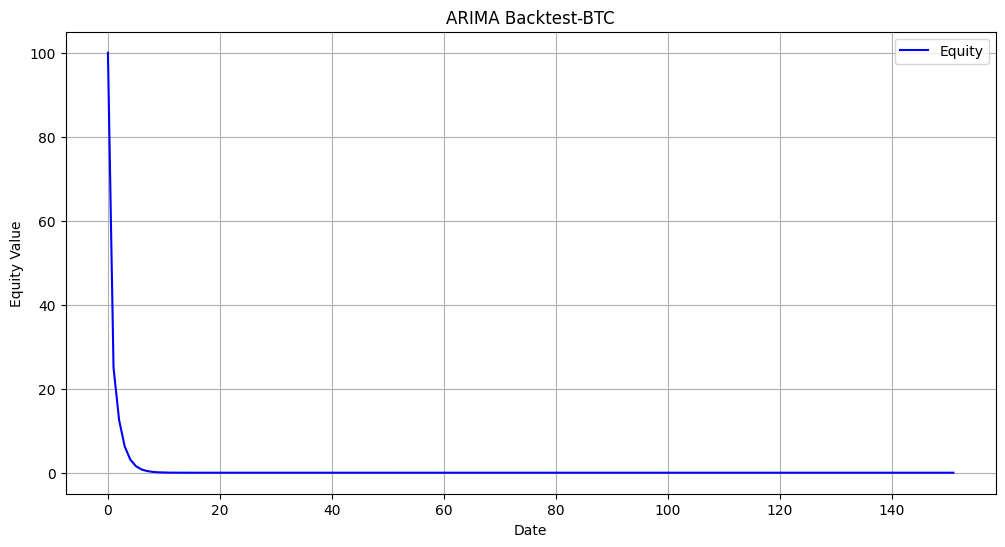

In [71]:
plt.figure(figsize=(12, 6))
plt.plot(equity_values_arima_BTC, label='Equity', color='blue')
plt.title('ARIMA Backtest-BTC')
plt.xlabel('Date')
plt.ylabel('Equity Value')
plt.grid(True)
plt.legend()
plt.show()

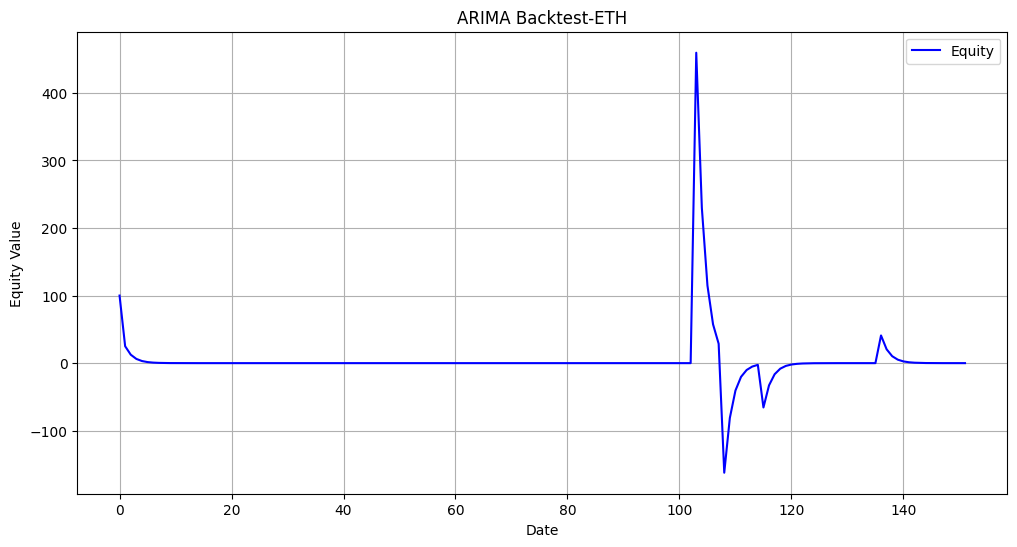

In [72]:
plt.figure(figsize=(12, 6))
plt.plot(equity_values_arima_ETH, label='Equity', color='blue')
plt.title('ARIMA Backtest-ETH')
plt.xlabel('Date')
plt.ylabel('Equity Value')
plt.grid(True)
plt.legend()
plt.show()

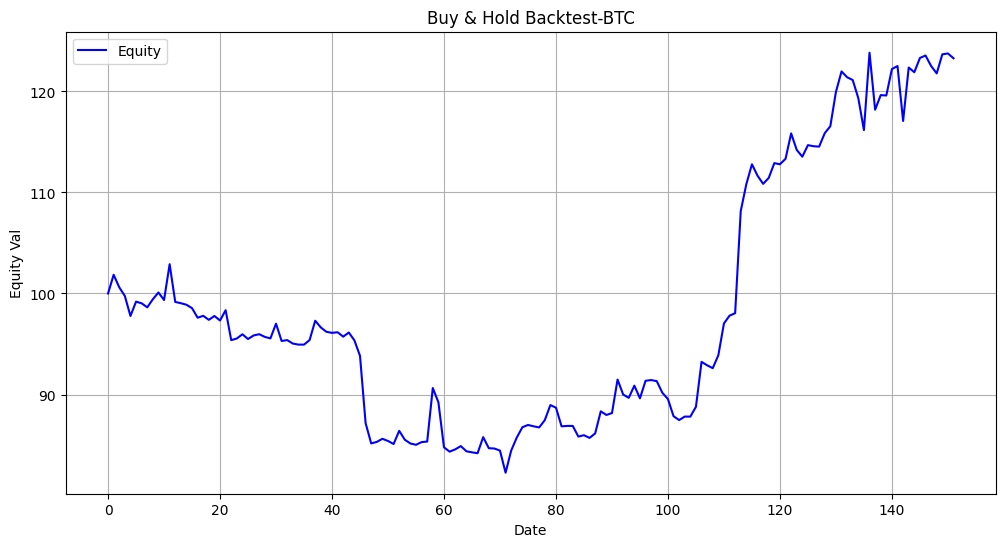

In [69]:
plt.figure(figsize=(12, 6))
plt.plot(buy_and_hold_equity_values_BTC, label='Equity', color='blue')
plt.title('Buy & Hold Backtest-BTC')
plt.xlabel('Date')
plt.ylabel('Equity Val')
plt.grid(True)
plt.legend()
plt.show()

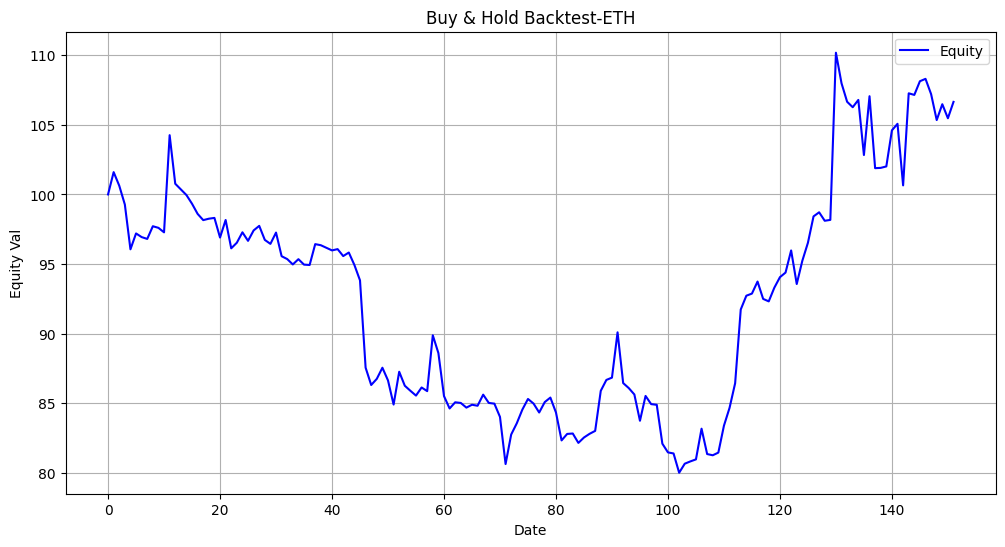

In [70]:
plt.figure(figsize=(12, 6))
plt.plot(buy_and_hold_equity_values_ETH, label='Equity', color='blue')
plt.title('Buy & Hold Backtest-ETH')
plt.xlabel('Date')
plt.ylabel('Equity Val')
plt.grid(True)
plt.legend()
plt.show()